In [1]:
from pathlib import Path

import submitit
import torch
import torch.nn as nn
from diffdrr.drr import DRR
from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d, MultiscaleNormalizedCrossCorrelation2dMasked
from pytorch_transformers.optimization import WarmupCosineSchedule
from timm.utils.agc import adaptive_clip_grad as adaptive_clip_grad_
from tqdm.notebook import tqdm
import ipdb
# import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

import tifffile as tiff

import matplotlib.pyplot as plt
from diffdrr.drr import DRR
import random
import skimage
from skimage.transform import resize


from pathlib import Path
from PIL import Image

import statistics
import gc
import cv2
from sklearn.model_selection import train_test_split

In [2]:
import wandb
# wandb.login(key = api)
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bananabond (kneedeeppose). Use `wandb login --relogin` to force relogin


True

In [3]:
#| export
from pathlib import Path
from typing import Optional, Union

import h5py
import numpy as np
import torch
from beartype import beartype
import nibabel as nib
import pandas as pd
import tifffile as tiff

import os
import sys

# Function to find the root directory of the project
def find_project_root(current_path, marker_file):
    while current_path != os.path.dirname(current_path):
        if marker_file in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None

# Get the current working directory
cwd = os.getcwd()

marker_file = '.git'

# Find the root directory
project_root = find_project_root(cwd, marker_file)

sys.path.append(project_root)

from diffpose.calibration import RigidTransform, perspective_projection, convert
from diffpose.kneefit import Transforms, get_random_offset
from diffpose.metrics import DoubleGeodesic, GeodesicSE3
from diffpose.registration import PoseRegressor

In [4]:
device = 'cuda'


In [5]:
# from diffpose.kneefit import  get_random_offset
# device = "cuda"
# # r1 = torch.distributions.Normal(1, 0).sample((1,))
# # print(r1)
# offset = get_random_offset(20,device=device)
# offset.get_rotation("euler_angles", "XYZ")

# `KneeFit`

In [6]:
#| export
@beartype
class KneeFitDataset(torch.utils.data.Dataset):
    """
    Get X-ray projections and poses from specimens in the `DeepFluoro` dataset.

    Given a specimen ID and projection index, returns the projection and the camera matrix for DiffDRR.
    """

    def __init__(
        self,
        id_number: int,  # Specimen number 
        filename: Optional[Union[str, Path]] = None,  # Path to Sipla dataset file
        preprocess: bool = True,  # Preprocess X-rays,
        volume_type: str = "femur"
    ):
        # Load the volume
        (
            self.projections,
            self.volume,
            self.spacing,
            self.lps2volume,
            self.intrinsic,
            self.extrinsic,
            self.focal_len,
            self.x0,
            self.y0,
            self.delx,
            self.li,
            self.re
        ) = load_kneefit_dataset(id_number, filename, volume_type)
        self.preprocess = preprocess
        self.volume_type = volume_type

        # Get the isocenter pose (AP viewing angle at volume isocenter)
        # TODO: probably have to change the viewing angle here to LAT viewing angle

        # isocenter_xyz = torch.tensor([100 , -175 , 100], dtype=torch.float32).unsqueeze(0)  ## Left Leg

        # isocenter_rot = torch.tensor([[0,0,0]], dtype=torch.float32) ## LEFT Leg
        if(self.li):
            isocenter_rot = torch.tensor([[-torch.pi / 2, -torch.pi, 0]])
        else:
            isocenter_rot = torch.tensor([[-torch.pi / 2, 0, 0]])

        isocenter_xyz = torch.tensor(self.volume.shape) * self.spacing / 2
        isocenter_xyz = isocenter_xyz.unsqueeze(0)
        shift = torch.tensor([[0, 0, -30]], dtype=torch.float32)
        # isocenter_xyz += shift


        self.isocenter_pose = RigidTransform(
            isocenter_rot, isocenter_xyz, "euler_angles", "XYZ"
        )

        if self.volume_type == "femur":
            if self.li:
                self.rot_z = RigidTransform(torch.tensor([0, 0, -torch.pi/4]), torch.zeros(3), "euler_angles", "XYZ")
            else:
                self.rot_z = RigidTransform(torch.tensor([0, 0, torch.pi/4]), torch.zeros(3), "euler_angles", "XYZ")
        else:
            # isocenter_xyz += shift
            if self.li:
                self.rot_z = RigidTransform(torch.tensor([0, 0, torch.pi/6]), torch.zeros(3), "euler_angles", "XYZ")
            else:
                self.rot_z = RigidTransform(torch.tensor([0, 0, -torch.pi/6]), torch.zeros(3), "euler_angles", "XYZ")

        self.rot_x = RigidTransform(torch.tensor([[1.0 , 0, 0], [0, -1, 0], [0, 0, -1]]), torch.zeros(3))

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_xz = RigidTransform(
            torch.tensor([[0.0, 0.0, -1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]),
            torch.zeros(3),
        )
        self.translate = RigidTransform(
            torch.eye(3),
            torch.tensor([-self.focal_len / 2, 0, 0]),
        )
        self.flip_180 = RigidTransform(
            torch.tensor([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]]),
            torch.zeros(3),
        )

    def __len__(self):
        return len(self.projections)

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        """
        (1) Swap the x- and z-axes
        (2) Reverse the x-axis to make the matrix E(3) -> SE(3)
        (3) Move the camera to the origin
        (4) Rotate the detector plane by 180, if offset
        (5) Form the full SE(3) transformation matrix
        """
        # print("get item called")
        projection = self.projections.iloc[idx]
        img = self.process_image(projection["img_path"])
        world2volume = self.get_gt_pose(projection)
        world2volume = RigidTransform(world2volume[:3, :3], world2volume[:3, 3])

        world2volume_femur = self.get_gt_pose_femur(projection)
        pose_femur = RigidTransform(world2volume_femur[:3, :3], world2volume_femur[:3, 3])
        pose_femur = convert_kneefit_to_diffdrr(self, pose_femur)

        world2volume_tibia = self.get_gt_pose_tibia(projection)
        pose_tibia = RigidTransform(world2volume_tibia[:3, :3], world2volume_tibia[:3, 3])
        pose_tibia = convert_kneefit_to_diffdrr(self, pose_tibia)

        
        # print(pose)

        # Handle rotations in the imaging dataset
        # if self._rot_180_for_up(idx):
        #     img = torch.rot90(img, k=2)
        #     pose = self.flip_180.compose(pose)

        # Optionally, preprocess the images
        # img = img.unsqueeze(0).unsqueeze(0)
        if self.preprocess:
            img = preprocess(img)

        img_raw = tiff.imread(projection["img_path"])

        return img, pose_femur, pose_tibia, img_raw
        return img, world2volume_femur, world2volume_tibia, img_raw
    
    def get_gt_pose(self, projection):
        # # print(projection)
        ## tibia local machine
        # gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], -116.402],
        #                         [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], -196.095],
        #                         [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], -947.326],
        #                         [0, 0, 0, 1]], dtype=torch.float32)
        

        ## femur local machine 
        # gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], -217.279],
        #                         [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], -34.6134],
        #                         [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], -973.889],
        #                         [0, 0, 0, 1]], dtype=torch.float32)
        gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], projection[f"{self.volume_type}_tx"]],
                        [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], projection[f"{self.volume_type}_ty"]],
                        [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], projection[f"{self.volume_type}_tz"]],
                        [0, 0, 0, 1]], dtype=torch.float32)
        return gt_pose
    
    def get_gt_pose_femur(self, projection):
        gt_pose = torch.tensor([[projection["femur_rxx"], projection["femur_rxy"], projection["femur_rxz"], projection["femur_tx"]],
                        [projection["femur_ryx"], projection["femur_ryy"], projection["femur_ryz"], projection["femur_ty"]],
                        [projection["femur_rzx"], projection["femur_rzy"], projection["femur_rzz"], projection["femur_tz"]],
                        [0, 0, 0, 1]], dtype=torch.float32)
        return gt_pose
    
    def get_gt_pose_tibia(self, projection):
        gt_pose = torch.tensor([[projection["tibia_rxx"], projection["tibia_rxy"], projection["tibia_rxz"], projection["tibia_tx"]],
                        [projection["tibia_ryx"], projection["tibia_ryy"], projection["tibia_ryz"], projection["tibia_ty"]],
                        [projection["tibia_rzx"], projection["tibia_rzy"], projection["tibia_rzz"], projection["tibia_tz"]],
                        [0, 0, 0, 1]], dtype=torch.float32)
        return gt_pose
    
    
    def process_image(self, img_path):
        # xray_img = tiff.imread(img_path)
        gt_img = Image.open(img_path).resize((256, 256))

        base_name = Path(img_path).stem
        if not os.path.exists(project_root+rf"\data\example\{base_name}-256_resize.tif"):
            gt_img.save(project_root+rf"\data\example\{base_name}-256_resize.tif")
        
        # gt_img = np.array(gt_img).astype(np.float32)
        # gt_img = torch.tensor(gt_img, dtype=torch.float32).unsqueeze(0)
        gt_img = skimage.img_as_float(gt_img)

        gt_img = torch.from_numpy(gt_img).unsqueeze(0)
        gt_img = np.array(gt_img).astype(np.float32)

        gt_img = torch.tensor(gt_img, dtype=torch.float32)

        # print(gt_img.shape)
        return gt_img


In [7]:
#| export
def convert_kneefit_to_diffdrr(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in Kneefit to the convention used by DiffDRR."""
    pose = specimen.lps2volume.inverse().compose(specimen.rot_z).compose(specimen.lps2volume).compose(pose)
    pose_inv = pose.inverse()
    return (
        specimen.rot_x
        .compose(specimen.translate)
        .compose(specimen.extrinsic.inverse())
        .compose(specimen.flip_xz)
        .compose(pose_inv)
        )

def convert_diffdrr_to_deepfluoro(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in DiffDRR to the convention used by DeepFluoro."""
    return pose
    return (
        # specimen.lps2volume.inverse()
        specimen.compose(pose.inverse())
        # .compose(specimen.translate)
        .compose(specimen.flip_xz)
    )

In [8]:
from torch.nn.functional import pad

from diffpose.calibration import perspective_projection


class Evaluator:
    def __init__(self, specimen, idx):
        # Save matrices to device
        self.translate = specimen.translate
        self.flip_xz = specimen.flip_xz
        self.intrinsic = specimen.intrinsic
        self.intrinsic_inv = specimen.intrinsic.inverse()

        # Get gt fiducial locations
        self.specimen = specimen
        self.fiducials = specimen.fiducials
        gt_pose = specimen[idx][1]
        self.true_projected_fiducials = self.project(gt_pose)

    def project(self, pose):
        extrinsic = convert_diffdrr_to_deepfluoro(self.specimen, pose)
        x = perspective_projection(extrinsic, self.intrinsic, self.fiducials)
        x = -self.specimen.focal_len * torch.einsum(
            "ij, bnj -> bni",
            self.intrinsic_inv,
            pad(x, (0, 1), value=1),  # Convert to homogenous coordinates
        )
        extrinsic = (
            self.flip_xz.inverse().compose(self.translate.inverse()).compose(pose)
        )
        return extrinsic.transform_points(x)

    def __call__(self, pose):
        pred_projected_fiducials = self.project(pose)
        registration_error = (
            (self.true_projected_fiducials - pred_projected_fiducials)
            .norm(dim=-1)
            .mean()
        )
        registration_error *= 0.194  # Pixel spacing is 0.194 mm / pixel isotropic
        return registration_error

In [9]:
#| export
from diffdrr.utils import parse_intrinsic_matrix, get_principal_point
def check_file_name(path):
    file_name = os.path.splitext(os.path.basename(path))[0]

    contains_li = "LI" in file_name
    contains_re = "RE" in file_name
    return file_name, contains_li, contains_re

def load_kneefit_dataset(id_number, filename, volume_type):
    # Open the H5 file for the dataset
    if filename is None:
        # root = Path(__file__).parent.parent.absolute()
        filename = Path.cwd().parent.parent.absolute() / "data/sipla_bone_local_preprocessed.csv"

    print(filename)
    f = pd.read_csv(filename)
    assert id_number in range(1, f["patient_id"].nunique())
    f = f[f["patient_id"] == id_number]
    (
        intrinsic,
        extrinsic,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    ) = parse_proj_params(f)

    # uncomment if focal length is in unit length
    focal_len = intrinsic[0,0]
    x0, y0 = intrinsic[0,2], intrinsic[1,2]

    # uncomment if focal length is in pixels
    # focal_len, x0, y0 = parse_intrinsic_matrix(
    #     intrinsic,
    #     num_rows,
    #     num_cols,
    #     proj_row_spacing,
    #     proj_col_spacing,
    # )


    # Try to load the particular specimen
    projections = f[f["patient_id"] == id_number]

    # Parse the volume
    volume, spacing, lps2volume, li, re = parse_volume(projections, volume_type)
    return (
        projections,
        volume,
        spacing,
        lps2volume,
        intrinsic,
        extrinsic,
        focal_len,
        x0,
        y0,
        proj_row_spacing, 
        li, re
    )

def get_volume_data(volume):
    nii_data = nib.load(volume)
    # Access the affine transformation matrix
    # affine = nii_data.affine
    # Access the image data as a NumPy array
    data = nii_data.get_fdata()
    # Access the affine transformation matrix
    affine = nii_data.affine
    return data, affine


def parse_volume(specimen, volume_type):
    # Parse the volume
    #TODO: use pitch as spacing if using stl converted to voxel grid OR use code from nii library nibabel from data_analysis notebook
    # spacing = specimen["vol/spacing"][:].flatten()
    print(specimen["spacing"].unique()[0])
    spacing = np.array(eval(specimen["spacing"].unique()[0])).astype(np.float32)
    #TODO: check shape of 3d array
    # import ipdb; ipdb.set_trace()
    vol_path = specimen[f"{volume_type}_nii"].unique()[0]
    _, li, re = check_file_name(vol_path)
    volume, affine = get_volume_data(vol_path)
    print("affine transformation matrix", affine)

    volume = volume.astype(np.float32)
    # volume = specimen["vol/pixels"][:].astype(np.float32)

    #TODO: is swapping the axis same as changing lateral to AP view?
    # volume = np.swapaxes(volume, 0, 2)[::-1].copy()

    # Parse the translation matrix from LPS coordinates to volume coordinates
    origin = torch.tensor(affine[:3, 3])
    # origin = torch.tensor([39, 39, -140], dtype=torch.float32)
    lps2volume = RigidTransform(torch.eye(3), origin)
    return volume, spacing, lps2volume, li, re


def parse_proj_params(f):
    # proj_params = f["proj-params"]
    # extrinsic parameters here do not matter, set to zeros
    try:
        fx = f["cal_focal_length"].unique()[0]
        px = f["cal_principalp_x"].unique()[0]
        py = f["cal_principalp_y"].unique()[0]
    except Exception as err:
        print("camera instrinsics must be the same for all frames of 1 patient")
        sys.exit()
    extrinsic = torch.eye(4, dtype=torch.float32)
    extrinsic[0, 3] = px
    extrinsic[1, 3] = py
    # extrinsic[2, 3] = fx

    

    # TODO: understand why extrinsic goes through RigidTransform
    extrinsic = RigidTransform(extrinsic[..., :3, :3], extrinsic[:3, 3])
    intrinsic = torch.tensor([[fx, 0, px],
                              [0, fx, py],
                              [0, 0, 1]], dtype=torch.float32)
    num_cols = num_rows = 1000
    proj_col_spacing = proj_row_spacing = float(f["cal_mm_per_pxl"].unique()[0])
    return intrinsic, extrinsic, num_cols, num_rows, proj_col_spacing, proj_row_spacing


In [10]:
#| export
from torchvision.transforms.functional import center_crop, gaussian_blur


def preprocess(img, size=None, initial_energy=torch.tensor(65487.0)):
    """
    Recover the line integral: $L[i,j] = \log I_0 - \log I_f[i,j]$

    (1) Remove edge due to collimator
    (2) Smooth the image to make less noisy
    (3) Subtract the log initial energy for each ray
    (4) Recover the line integral image
    (5) Rescale image to [0, 1]
    """
    img = center_crop(img, (1436, 1436))
    img = gaussian_blur(img, (5, 5), sigma=1.0)
    img = initial_energy.log() - img.log()
    img = (img - img.min()) / (img.max() - img.min())
    return img

In [11]:
def check_threshold(drr_values, threshold):
    negative_map = torch.tensor(drr_values < threshold).nonzero(as_tuple=True)[0]
    return negative_map

In [12]:
# offsets = get_random_offset(2, device)
# print(offsets[0][0])

In [13]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if p.grad is None:
            print('this layer grad is none', n)

        elif(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.abs().mean().detach().cpu())
            max_grads.append(p.abs().max().detach().cpu())
            # print("ok")

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=max(max_grads)) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")

    return plt

In [14]:
def gen_random_offset(batch_size, device, vol_type):

    # rotation along x is good
    # r1 = torch.distributions.Normal(0, 0.3*torch.pi).sample((batch_size,))
    # r2 = torch.distributions.Normal(0, 0.01*torch.pi).sample((batch_size,))
    # r3 = torch.distributions.Normal(0, 0.1*torch.pi).sample((batch_size,))
    
    # rot =  torch.stack([r1, r2, r3], dim=1).to(device)


    # rand_T = RigidTransform(rot, trans, "euler_angles", "XYZ")

    if vol_type is "femur":
        r1_se3 = torch.distributions.Normal(0, 2.1).sample((batch_size,))
        r2_se3 = torch.distributions.Normal(0, 1.5).sample((batch_size,))
        r3_se3 = torch.distributions.Normal(0, 0.5).sample((batch_size,))
        t1 = torch.distributions.Normal(-50, 1).sample((batch_size,))
        t2 = torch.distributions.Normal(0, 50).sample((batch_size,))
        t3 = torch.distributions.Normal(0, 50).sample((batch_size,))
    else:
        r1_se3 = torch.distributions.Normal(0, 1.5).sample((batch_size,))
        r2_se3 = torch.distributions.Normal(0, 1.1).sample((batch_size,))
        r3_se3 = torch.distributions.Normal(0, 0.5).sample((batch_size,))
        t1 = torch.distributions.Normal(-50, 1).sample((batch_size,))
        t2 = torch.distributions.Normal(0, 30).sample((batch_size,))
        t3 = torch.distributions.Normal(0, 30).sample((batch_size,))
    # r1_se3, r2_se3, r3_se3 = torch.tensor([2, -2, 2, -2]), torch.tensor([0.0, -0.0, 1, -1]), torch.tensor([0.1, -0.1,0.1, -0.1])


    
    t1 = torch.distributions.Normal(-50, 1).sample((batch_size,))
    t2 = torch.distributions.Normal(0, 50).sample((batch_size,))

    # if vol_type == "tibia":
    #     t3 = torch.distributions.Normal(-30, 50).sample((batch_size,))
    # else: 
    t3 = torch.distributions.Normal(0, 50).sample((batch_size,))


    rot_se3 =  torch.stack([r1_se3, r2_se3, r3_se3], dim=1).to(device)
    trans_se3 = torch.stack([t1, t2, t3], dim=1).to(device)

    rand_T_se3 =  convert(
        [rot_se3, trans_se3],
        "se3_log_map",
        "se3_exp_map",
    )

    # return rand_T
    return rand_T_se3


def log_memory_usage(epoch, prefix=""):
    """Logs GPU memory usage to Wandb."""
    memory_allocated = torch.cuda.memory_allocated()
    memory_reserved = torch.cuda.memory_reserved()
    
    wandb.log({
        f"{prefix}memory_allocated": memory_allocated,
        f"{prefix}memory_reserved": memory_reserved,
        "step": epoch
    })

def normalize_ncc(ncc_loss):
    return (ncc_loss - ncc_loss.min()) / (ncc_loss.max() - ncc_loss.min() + 1e-8)

def normalize_geodesic(geodesic_loss):
    return (geodesic_loss - geodesic_loss.min()) / (geodesic_loss.max() - geodesic_loss.min() + 1e-8)

<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Public Admin\AppData\Local\Temp\ipykernel_25012\491940734.py:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if vol_type is "femur":


In [15]:
transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([972/2, 0,0], dtype=torch.float32, device=device))


# DRR for knee pose

In [16]:
def gen_val_ids(file_path, projections):
    file_path = os.path.join(os.getcwd(), file_path)
    if os.path.exists(file_path):
        # Open and read the file
        with open(file_path, 'r') as file:
            val_indices = [int(line.strip()) for line in file]
    else:
        num_xrays = len(projections)
        # print(f'This patient has a total of {num_xrays} xrays ')

        indices = list(range(num_xrays))

        # Random split (80% train, 20% validation)
        train_indices, val_indices = train_test_split(
            indices,
            test_size=0.2,  # 20% for validation
            random_state=42,  # For reproducibility
            shuffle=True
        )

                # Sorting the indices
        sorted_indices = sorted(val_indices)

        # Storing the sorted indices in a .txt file
        with open(file_path, 'w') as file:
            for index in sorted_indices:
                file.write(f"{index}\n")

        # print(f"File created and saved as {file_path}")

    return val_indices




In [17]:
def cal_rot_loss(pred_pose, test_poses_batch):
    # print(pred_pose.get_rotation().shape)
    R_error = torch.bmm(test_poses_batch.get_rotation().transpose(-1, -2), pred_pose.get_rotation())
    
    # Extract the diagonal elements from each matrix in the batch
    diagonals = torch.diagonal(R_error, dim1=-2, dim2=-1)  # shape: (batch_size, 3)
    
    # Sum the diagonal elements to get the trace for each matrix
    trace_R_error = torch.sum(diagonals, dim=-1)  # shape: (batch_size,)

    # Compute the rotational error angle in radians using arccos
    theta = torch.acos((trace_R_error - 1) / 2)

    return theta  # Convert single tensor to Python scalar
        
def cal_trans_loss(pred_pose, test_poses_batch):
    # Compute the translation error vector
    t_error = test_poses_batch.get_translation() - pred_pose.get_translation()
    t_error_txty = test_poses_batch.get_translation()[:,1:] - pred_pose.get_translation()[:,1:]
    
    # Calculate the Euclidean distance (translation error)
    trans_error = torch.norm(t_error)
    trans_error_txty = torch.norm(t_error_txty)
    
    return trans_error, trans_error_txty

In [18]:
## I'm interested in this one for validation metrics

def val_synthetic_train(
    model,
    drr,
    transforms,
    specimen,
    isocenter_pose,
    device,
    val_path
):
    # initialize losses
    print("ISO = ", isocenter_pose.get_translation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    # geodesic = GeodesicSE3(geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    # double = DoubleGeodesic(drr.detector.sdr, geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    double = DoubleGeodesic(drr.detector.sdr)
    geodesic = GeodesicSE3()
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([specimen.focal_len/2, 0,0], dtype=torch.float32, device=device))

    # test_drr, test_poses = gen_random_dataset(specimen.focal_len, isocenter_pose, transforms, n_test_batches, batch_size, drr)
    val_indices = gen_val_ids(val_path, specimen.projections)

    _, test_poses, _ = process_specimens(specimen, isocenter_pose, val_indices, 16)
    n_test_batches = len(test_poses)

    print(f"Model will be tested on {len(test_poses)} batches of random poses")

    model = model.to(device)
    model.eval()

    rot_loss_ep = []
    trans_loss_ep = []
    trans_loss_txty_ep = []



        # metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64], patch_weights=[0.75, 0.25], eps=1e-4)
        # losses_ep = []

    for i in (itr := tqdm(range(n_test_batches), leave=False)):

        # test_imgs_batch = test_drr[i].to(device)
        with torch.no_grad():
            test_poses_batch = test_poses[i].to(device)
            imgs = drr(None, None, None, pose=test_poses_batch, bone_attenuation_multiplier=2.0)
            imgs = transforms(imgs)
            imgs = imgs.float()

            pred_offset = model(imgs)
            pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
            pred_img = drr(None, None, None, pose=pred_pose)
            pred_img = transforms(pred_img)
            pred_img = pred_img.float()

            rot_loss = cal_rot_loss(pred_pose, test_poses_batch)
            trans_loss, trans_loss_txty = cal_trans_loss(pred_pose, test_poses_batch)

            rot_loss_ep.append(rot_loss.mean().item()*180/torch.pi)
            trans_loss_ep.append(trans_loss.mean().item())
            trans_loss_txty_ep.append(trans_loss_txty.mean().item())

            # Update progress bar
            itr.set_postfix(
                rot_loss=rot_loss.mean().item(),
                trans_loss=trans_loss.mean().item()
            )
            for i in range(len(pred_img)):
                pred_img_log = wandb.Image(pred_img[i].detach().cpu().numpy())
                ip_img_log = wandb.Image(imgs[i].detach().cpu().numpy())
                wandb.log({"test_pred_img": wandb.Image(pred_img_log),
                            "test_inp_img" : wandb.Image(ip_img_log),
                            # "gradient_chart": plt,
                            })
    wandb.log({"rot_loss": statistics.mean(rot_loss_ep),
               "trans_loss": statistics.mean(trans_loss_ep)})

    rot_losses = torch.tensor(rot_loss_ep)
    trans_losses = torch.tensor(trans_loss_ep)
    trans_loss_xy = torch.tensor(trans_loss_txty_ep)

    tqdm.write(f"Rotation Loss {rot_losses.mean().item():.4f}, Translation loss {trans_losses.mean().item():.4f} , Translation loss txty {trans_loss_xy.mean().item():.4f}")

    torch.cuda.empty_cache()
    gc.collect()
    # return val_losses.mean().item()

In [19]:
def val_random_synthetic_train(
    model,
    drr,
    transforms,
    specimen,
    isocenter_pose,
    device, 
    batches = 50,
    batch_size = 10
):
    # initialize losses
    # print("ISO = ", isocenter_pose.get_translation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    # geodesic = GeodesicSE3(geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    # double = DoubleGeodesic(drr.detector.sdr, geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    double = DoubleGeodesic(drr.detector.sdr)
    geodesic = GeodesicSE3()
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([specimen.focal_len/2, 0,0], dtype=torch.float32, device=device))

    model = model.to(device)
    model.eval()

    rot_loss_ep = []
    trans_loss_ep = []
    trans_loss_txty_ep = []



        # metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64], patch_weights=[0.75, 0.25], eps=1e-4)
        # losses_ep = []

    for i in (itr := tqdm(range(batches), leave=False)):

        # test_imgs_batch = test_drr[i].to(device)
        with torch.no_grad():
            new_offsets = gen_random_offset(batch_size, device, specimen.volume_type)
            # test_poses_batch = test_poses[i].to(device)
            test_poses_batch = transito.compose(new_offsets.compose(isocenter_pose))
            imgs = drr(None, None, None, pose=test_poses_batch, bone_attenuation_multiplier=2.0)
            imgs = transforms(imgs)
            imgs = imgs.float()

            pred_offset = model(imgs)
            pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
            pred_img = drr(None, None, None, pose=pred_pose)
            pred_img = transforms(pred_img)
            pred_img = pred_img.float()

            rot_loss = cal_rot_loss(pred_pose, test_poses_batch)
            trans_loss, trans_loss_txty = cal_trans_loss(pred_pose, test_poses_batch)

            rot_loss_ep.append(rot_loss.mean().item()*180/torch.pi)
            trans_loss_ep.append(trans_loss.mean().item())
            trans_loss_txty_ep.append(trans_loss_txty.mean().item())

            # Update progress bar
            itr.set_postfix(
                rot_loss=rot_loss.mean().item(),
                trans_loss=trans_loss.mean().item()
            )
            for i in range(len(pred_img)):
                pred_img_log = wandb.Image(pred_img[i].detach().cpu().numpy())
                ip_img_log = wandb.Image(imgs[i].detach().cpu().numpy())
                wandb.log({"test_pred_img": wandb.Image(pred_img_log),
                            "test_inp_img" : wandb.Image(ip_img_log),
                            # "gradient_chart": plt,
                            })
    wandb.log({"rot_loss": statistics.mean(rot_loss_ep),
               "trans_loss": statistics.mean(trans_loss_ep)})

    rot_losses = torch.tensor(rot_loss_ep)
    trans_losses = torch.tensor(trans_loss_ep)
    trans_loss_xy = torch.tensor(trans_loss_txty_ep)

    tqdm.write(f"Rotation Loss {rot_losses.mean().item():.4f}, Translation loss {trans_losses.mean().item():.4f}, , Translation loss txty {trans_loss_xy.mean().item():.4f}")

    torch.cuda.empty_cache()
    gc.collect()
    # return val_losses.mean().item()

In [20]:
def synthetic_train(
    run_id,
    id_number,
    model,
    optimizer,
    scheduler,
    drr,
    transforms,
    specimen,
    isocenter_pose,
    device,
    batch_size,
    n_epochs,
    n_batches_per_epoch,
    model_params,
    volume_type,
    binary_imgs,
    use_ncc,
    ncc_factor,
    new_ncc
):
    # initialize losses
    print("ISO = ", isocenter_pose.get_translation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    # geodesic = GeodesicSE3(geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    # double = DoubleGeodesic(drr.detector.sdr, geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    double = DoubleGeodesic(drr.detector.sdr)
    geodesic = GeodesicSE3()
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([specimen.focal_len/2, 0,0], dtype=torch.float32, device=device))
    best_loss = torch.inf

    # n_test_batches = 100

    # test_drr, test_poses = gen_random_dataset(specimen.focal_len, isocenter_pose, transforms, n_test_batches, batch_size, drr)
    # test_drr, test_poses = process_specimens()
    # print(f"Model will be tested on {len(test_drr)} batches of random poses")

    model = model.to(device)
    model.train()

    if use_ncc:
        # metric = MultiscaleNormalizedCrossCorrelation2d(eps=1e-4)
        # metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[256], patch_weights=[1.0], eps=1e-4)
        # NormalizedCrossCorrelation2dMasked
        if new_ncc:
            metric = MultiscaleNormalizedCrossCorrelation2dMasked(patch_sizes=[256], patch_weights=[1.0], eps=1e-4)
        else:
            metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[256], patch_weights=[1.0], eps=1e-4)

        # metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64], patch_weights=[0.5, 0.5], eps=1e-4)
        for epoch in range(n_epochs + 1):
            
            # print("CTR Break triggered = ", ctr_break_ctr)
            losses_ep = []
            geodesic_ep = []
            ncc_ep = []
            double_geo_ep = []
            geo_xyz_ep = []
            geo_rot_ep = []
            # val_loss_ep = []



            for _ in (itr := tqdm(range(n_batches_per_epoch), leave=False)):
                # bone_attenuation is chosen randomly from a uniform distribution
                contrast = 2.0
                # generate random pose using normal distribution
                new_offsets = gen_random_offset(batch_size, device, specimen.volume_type)
                poses = transito.compose(new_offsets.compose(isocenter_pose))

                imgs = drr(None, None, None, pose=poses, bone_attenuation_multiplier=contrast)
                imgs = transforms(imgs)
                imgs = imgs.float()
                ip = imgs
                if binary_imgs:
                    actual_binary_images = (imgs> 0).float().cuda()
                    ip = actual_binary_images

                # apply predicted pose and generate predicted DRR
                
                pred_offset = model(ip)
                pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
                pred_img = drr(None, None, None, pose=pred_pose)
                pred_img = transforms(pred_img)
                pred_img = pred_img.float()

                # compute image reconstruction and numerical losses
                ncc = metric(pred_img, ip)
                log_geodesic = geodesic(pred_pose, poses)
                geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, poses)
                geodesic_weight = 1e-3

                # Calculate the final weighted loss
                if not use_ncc:
                    loss = ( geodesic_weight * (log_geodesic + double_geodesic))
                elif ncc_factor is not None:
                    ncc_new = 1 - ncc
                    loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (ncc_factor * ncc_new)
                    # loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + ((1*ncc_factor) - (ncc*ncc_factor))
                elif new_ncc:
                    ncc_scaled = torch.log1p(1 - ncc + 1e-5)
                    # ncc_scaled = torch.log2(2 - ncc + 1e-5)
                    loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + ncc_scaled
                #     loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + ncc
                else:
                    loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (1 - ncc)
                # loss = 1 - ncc + geodesic_weight*double_geodesic
                # loss = (1 - ncc) + geodesic_weight * (0.6*geodesic_rot + 0.4*geodesic_xyz)

                
                if loss.isnan().any():
                    print("Aaaaaaand we've crashed...")
                    # print(ncc)
                    # print(geodesic_rot)
                    # print(geodesic_xyz)
                    # print(geodesic_ep)
                    # print(double_geodesic)
                    # print(poses.get_matrix())
                    # print(pred_pose.get_matrix())
                    torch.save(
                        {
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "height": drr.detector.height,
                            "epoch": epoch,
                            "batch_size": batch_size,
                            "n_epochs": n_epochs,
                            "n_batches_per_epoch": n_batches_per_epoch,
                            "pose": poses.get_matrix().cpu(),
                            "pred_pose": pred_pose.get_matrix().cpu(),
                            "img": imgs.cpu(),
                            # "pred_img": pred_img.cpu()
                            **model_params,
                        },
                        f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_crashed.ckpt",
                    )
                    raise RuntimeError("NaN loss")

                optimizer.zero_grad()
                loss.mean().backward()
                adaptive_clip_grad_(model.parameters())
                optimizer.step()
                scheduler.step()

                ncc_ep.append(ncc.mean().item())
                geodesic_ep.append(log_geodesic.mean().item())
                double_geo_ep.append(double_geodesic.mean().item())
                geo_xyz_ep.append(geodesic_xyz.mean().item())
                geo_rot_ep.append(geodesic_rot.mean().item())
                losses_ep.append(loss.mean().item())

                # Update progress bar
                itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
                itr.set_postfix(
                    geodesic_rot=geodesic_rot.mean().item(),
                    geodesic_xyz=geodesic_xyz.mean().item(),
                    geodesic_dou=double_geodesic.mean().item(),
                    loss=loss.mean().item(),
                    ncc=ncc.mean().item(),
                )
                log_memory_usage(int(epoch*batch_size + _))
            
            
            # WANDB
            # print(model)
            # plt = plot_grad_flow(model.named_parameters())
            # plt.show()
            pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
            ip_img_log = wandb.Image(ip[0].detach().cpu().numpy())
            wandb.log({"pred_img": wandb.Image(pred_img_log),
                        "ip_img" : wandb.Image(ip_img_log),
                        # "gradient_chart": plt,
                        })
            wandb.log({"epoch": epoch,
                    "ncc": statistics.mean(ncc_ep),
                    "log_geodesic": statistics.mean(geodesic_ep),
                    "final_loss":statistics.mean(losses_ep),
                    "geodesic_rot":statistics.mean(geo_rot_ep),
                    "geodesic_xyz":statistics.mean(geo_xyz_ep),
                    "double_geodesic":statistics.mean(double_geo_ep)})
            


            losses = torch.tensor(losses_ep)
            tqdm.write(f"Epoch {epoch + 1:04d} | Train Loss {losses.mean().item():.4f}")
            # if losses.mean() < best_loss and not losses.isnan().any():
            #     best_loss = losses.mean().item()
            #     torch.save(
            #         {
            #             "model_state_dict": model.state_dict(),
            #             "optimizer_state_dict": optimizer.state_dict(),
            #             "height": drr.detector.height,
            #             "epoch": epoch,
            #             "loss": losses.mean().item(),
            #             "batch_size": batch_size,
            #             "n_epochs": n_epochs,
            #             "n_batches_per_epoch": n_batches_per_epoch,
            #             **model_params,
            #         },
            #         f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_best.ckpt",
            #     )

            # if epoch % 50 == 0:
            #     model.eval()
            #     for i in (itr := tqdm(range(n_test_batches), leave=False)):

            #         test_imgs_batch = test_drr[i].to(device)
            #         test_poses_batch = test_poses[i].to(device)

            #         with torch.no_grad():
            #             pred_offset = model(test_imgs_batch)
            #         pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
            #         pred_img = drr(None, None, None, pose=pred_pose)
            #         pred_img = transforms(pred_img)
            #         pred_img = pred_img.float()

            #         # compute image reconstruction and numerical losses
            #         ncc = metric(pred_img, test_imgs_batch)
            #         log_geodesic = geodesic(pred_pose, test_poses_batch)
            #         geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, test_poses_batch)
            #         geodesic_weight = 1e-3
            #         val_loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (1 - ncc)

            #         val_loss_ep.append(val_loss.mean().item())

            #         # Update progress bar
            #         itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
            #         itr.set_postfix(
            #             val_loss=val_loss.mean().item()
            #         )
                
            #     pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
            #     ip_img_log = wandb.Image(test_imgs_batch[0].detach().cpu().numpy())
            #     wandb.log({"test_pred_img": wandb.Image(pred_img_log),
            #                 "test_inp_img" : wandb.Image(ip_img_log),
            #                 # "gradient_chart": plt,
            #                 })
            #     wandb.log({"epoch": epoch, 
            #                "val_loss": statistics.mean(val_loss_ep)})

            #     val_losses = torch.tensor(val_loss_ep)
            #     tqdm.write(f"Epoch {epoch + 1:04d} | Test Loss {val_losses.mean().item():.4f}")


            if epoch % 50 == 0:
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "height": drr.detector.height,
                        "epoch": epoch,
                        "loss": losses.mean().item(),
                        "batch_size": batch_size,
                        "n_epochs": n_epochs,
                        "n_batches_per_epoch": n_batches_per_epoch,
                        **model_params,
                    },
                    f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_epoch{epoch:03d}.ckpt",
                )
            torch.cuda.empty_cache()
            gc.collect()
        return statistics.mean(losses_ep)
    else:
        for epoch in range(n_epochs + 1):
            
            losses_ep = []
            geodesic_ep = []
            double_geo_ep = []
            geo_xyz_ep = []
            geo_rot_ep = []
            # val_loss_ep = []

            for _ in (itr := tqdm(range(n_batches_per_epoch), leave=False)):
                # bone_attenuation is chosen randomly from a uniform distribution
                contrast = 2.0
                # generate random pose using normal distribution
                new_offsets = gen_random_offset(batch_size, device, specimen.volume_type)
                poses = transito.compose(new_offsets.compose(isocenter_pose))

                imgs = drr(None, None, None, pose=poses, bone_attenuation_multiplier=contrast)
                imgs = transforms(imgs)
                imgs = imgs.float()
                ip = imgs
                if binary_imgs:
                    actual_binary_images = (imgs> 0).float().cuda()
                    ip = actual_binary_images

                # apply predicted pose and generate predicted DRR
                
                pred_offset = model(ip)
                pred_pose = transito.compose(pred_offset.compose(isocenter_pose))

                # compute image reconstruction and numerical losses
                log_geodesic = geodesic(pred_pose, poses)
                geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, poses)
                geodesic_weight = 1e-3

                # Calculate the final weighted loss
                loss = ( geodesic_weight * (log_geodesic + double_geodesic))
                # loss = 1 - ncc + geodesic_weight*double_geodesic
                # loss = (1 - ncc) + geodesic_weight * (0.6*geodesic_rot + 0.4*geodesic_xyz)

                
                if loss.isnan().any():
                    print("Aaaaaaand we've crashed...")
                    # print(ncc)
                    print(geodesic_rot)
                    print(geodesic_xyz)
                    print(geodesic_ep)
                    print(double_geodesic)
                    print(poses.get_matrix())
                    print(pred_pose.get_matrix())
                    torch.save(
                        {
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "height": drr.detector.height,
                            "epoch": epoch,
                            "batch_size": batch_size,
                            "n_epochs": n_epochs,
                            "n_batches_per_epoch": n_batches_per_epoch,
                            "pose": poses.get_matrix().cpu(),
                            "pred_pose": pred_pose.get_matrix().cpu(),
                            "img": imgs.cpu(),
                            # "pred_img": pred_img.cpu()
                            **model_params,
                        },
                        f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_crashed.ckpt",
                    )
                    raise RuntimeError("NaN loss")

                optimizer.zero_grad()
                loss.mean().backward()
                adaptive_clip_grad_(model.parameters())
                optimizer.step()
                scheduler.step()

                geodesic_ep.append(log_geodesic.mean().item())
                double_geo_ep.append(double_geodesic.mean().item())
                geo_xyz_ep.append(geodesic_xyz.mean().item())
                geo_rot_ep.append(geodesic_rot.mean().item())
                losses_ep.append(loss.mean().item())

                # Update progress bar
                itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
                itr.set_postfix(
                    geodesic_rot=geodesic_rot.mean().item(),
                    geodesic_xyz=geodesic_xyz.mean().item(),
                    geodesic_dou=double_geodesic.mean().item(),
                    loss=loss.mean().item(),
                )
                log_memory_usage(int(epoch*batch_size + _))
            
            
            # WANDB
            # print(model)
            # plt = plot_grad_flow(model.named_parameters())
            # plt.show()
            # pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
            # ip_img_log = wandb.Image(ip[0].detach().cpu().numpy())
            # wandb.log({"pred_img": wandb.Image(pred_img_log),
            #             "ip_img" : wandb.Image(ip_img_log),
            #             # "gradient_chart": plt,
            #             })
            # pred_img = pred_img.detach().cpu()
            # del pred_img
            # torch.cuda.empty_cache()
            wandb.log({"epoch": epoch,
                    "log_geodesic": statistics.mean(geodesic_ep),
                    "final_loss":statistics.mean(losses_ep),
                    "geodesic_rot":statistics.mean(geo_rot_ep),
                    "geodesic_xyz":statistics.mean(geo_xyz_ep),
                    "double_geodesic":statistics.mean(double_geo_ep)})
            


            losses = torch.tensor(losses_ep)
            tqdm.write(f"Epoch {epoch + 1:04d} | Train Loss {losses.mean().item():.4f}")
            # if losses.mean() < best_loss and not losses.isnan().any():
            #     best_loss = losses.mean().item()
            #     torch.save(
            #         {
            #             "model_state_dict": model.state_dict(),
            #             "optimizer_state_dict": optimizer.state_dict(),
            #             "height": drr.detector.height,
            #             "epoch": epoch,
            #             "loss": losses.mean().item(),
            #             "batch_size": batch_size,
            #             "n_epochs": n_epochs,
            #             "n_batches_per_epoch": n_batches_per_epoch,
            #             **model_params,
            #         },
            #         f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_best.ckpt",
            #     )

            # if epoch % 50 == 0:
            #     model.eval()
            #     for i in (itr := tqdm(range(n_test_batches), leave=False)):

            #         test_imgs_batch = test_drr[i].to(device)
            #         test_poses_batch = test_poses[i].to(device)

            #         with torch.no_grad():
            #             pred_offset = model(test_imgs_batch)
            #         pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
            #         pred_img = drr(None, None, None, pose=pred_pose)
            #         pred_img = transforms(pred_img)
            #         pred_img = pred_img.float()

            #         # compute image reconstruction and numerical losses
            #         ncc = metric(pred_img, test_imgs_batch)
            #         log_geodesic = geodesic(pred_pose, test_poses_batch)
            #         geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, test_poses_batch)
            #         geodesic_weight = 1e-3
            #         val_loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (1 - ncc)

            #         val_loss_ep.append(val_loss.mean().item())

            #         # Update progress bar
            #         itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
            #         itr.set_postfix(
            #             val_loss=val_loss.mean().item()
            #         )
                
            #     pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
            #     ip_img_log = wandb.Image(test_imgs_batch[0].detach().cpu().numpy())
            #     wandb.log({"test_pred_img": wandb.Image(pred_img_log),
            #                 "test_inp_img" : wandb.Image(ip_img_log),
            #                 # "gradient_chart": plt,
            #                 })
            #     wandb.log({"epoch": epoch, 
            #                "val_loss": statistics.mean(val_loss_ep)})

            #     val_losses = torch.tensor(val_loss_ep)
            #     tqdm.write(f"Epoch {epoch + 1:04d} | Test Loss {val_losses.mean().item():.4f}")
            if epoch % 50 == 0:
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "height": drr.detector.height,
                        "epoch": epoch,
                        "loss": losses.mean().item(),
                        "batch_size": batch_size,
                        "n_epochs": n_epochs,
                        "n_batches_per_epoch": n_batches_per_epoch,
                        **model_params,
                    },
                    f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_epoch{epoch:03d}.ckpt",
                )

            torch.cuda.empty_cache()
            gc.collect()
        return statistics.mean(losses_ep)

In [21]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from torchvision import transforms, utils

def get_deeplab_model(device, ckpt):
    outputchannels = 3
    # Initialize DeepLabV3 with a ResNet backbone
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    
    model.classifier = DeepLabHead(2048, outputchannels)
    model.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    if ckpt is not None:
        print("Loading segnet from checkpoint = " + str(ckpt))
        ckpt = torch.load(ckpt)
        model.load_state_dict(ckpt)
    
    model = model.to(device)  # Move model to GPU

    return model

def get_masked_img(img_tensor, mask_tensor, mask_num, device):



    img_tensor = img_tensor.to(device)
    op = []
    for img, mask in zip(img_tensor, mask_tensor):
        binary_mask = (mask == mask_num).float().to(device)
        masked_image = img * binary_mask

        # plt.imshow(transforms.ToPILImage()(img), cmap="gray")
        # plt.title("true xray")
        # plt.show()
        # # print('masked image', masked_image)
        # plt.imshow(transforms.ToPILImage()(masked_image), cmap="gray")
        # plt.title("masked xray" + str(mask_num))
        # plt.show()


        op.append(masked_image)
    return torch.stack(op)

In [22]:
def finetune_train(
    run_id,
    id_number,
    model,
    optimizer,
    scheduler,
    drr,
    transforms,
    specimen,
    isocenter_pose,
    device,
    batch_size,
    n_epochs,
    n_batches_per_epoch,
    model_params,
    volume_type,
    validate = False,
    use_ncc = True,
    seg_ncc = True,
    new_ncc = False
):
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([specimen.focal_len/2, 0,0], dtype=torch.float32, device=device))
    
    if new_ncc:
        metric = MultiscaleNormalizedCrossCorrelation2dMasked(patch_sizes=[16, 64, 256], patch_weights=[0.5, 0.25, 0.25], eps=1e-4)
    else:
        metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64, 256], patch_weights=[0.5, 0.25, 0.25], eps=1e-4)
    geodesic = GeodesicSE3()
    double = DoubleGeodesic(drr.detector.sdr)
    contrast_distribution = torch.distributions.Uniform(1.0, 10.0)

    best_loss = torch.inf
    seg_ckpt = r"C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt"
    segnet = get_deeplab_model(device, ckpt=seg_ckpt)
    segnet.eval()
    model["femur"] = model["femur"].to(device)
    
    # model["tibia"].train()
    #  visualization part

    num_xrays = len(specimen.projections)
    # print(f'This patient has a total of {num_xrays} xrays ')

    indices = list(range(num_xrays))

    # Random split (80% train, 20% validation)
    train_indices, val_indices = train_test_split(
        indices,
        test_size=0.2,  # 20% for validation
        random_state=42,  # For reproducibility
    )

    # print(f"Training on {len(train_indices)} xrays, Testing on {len(val_indices)}")
    
    random.shuffle(train_indices)
    true_xray_tensor_batch, gt_pose_batch_femur, gt_pose_batch_tibia = process_specimens(specimen, isocenter_pose, train_indices, batch_size)
    n_test_batches = len(true_xray_tensor_batch)
    # print(len(true_xray_tensor_batch), len(true_xray_tensor_batch))
    val_epochs = 10
    val_xray, val_gt_pose_f, val_gt_pose_t = process_specimens(specimen, isocenter_pose, val_indices, batch_size = 10)
    val_gt_pose = val_gt_pose_f if volume_type == "femur" else val_gt_pose_t
    # visualize(drr=drr, pose=pose,device=device)
    for epoch in range(n_epochs + 1):
        model["femur"].train()
        losses = []
        losses_ep = []
        geodesic_ep = []
        ncc_ep = []
        double_geo_ep = []
        geo_xyz_ep = []
        geo_rot_ep = []
        
        # print('epoch entered')
        for i in (itr := tqdm(range(n_test_batches), leave=False)):
        # for itr, (true_xray, gt_pose_femur, gt_pose_tibia) in enumerate(tqdm(zip(true_xray_tensor_batch, gt_pose_batch_femur, gt_pose_batch_tibia), total=len(true_xray_tensor_batch), leave=False)):

            # print(true_xray, gt_pose_femur, gt_pose_tibia)
            true_xray = true_xray_tensor_batch[i].to(device)
            gt_pose_femur = gt_pose_batch_femur[i].to(device)
            gt_pose_tibia = gt_pose_batch_tibia[i].to(device)

            # bone_attenuation is chosen randomly from a uniform distribution
            # contrast = contrast_distribution.sample().item()
            contrast = 2
            # NOTE - This should be fine as long as the bone is in frame of the drr, can add a check for that
            # drr_gt_xray = drr(None, None, None, pose=gt_pose, bone_attenuation_multiplier=contrast)
            # drr_gt_xray = transforms(drr_gt_xray)
            # drr_gt_xray = drr_gt_xray.float()

            with torch.no_grad():
                output = segnet(true_xray)['out']
            masks = output.argmax(1).byte().cpu()


            mask_num = 1 if volume_type == "femur" else 2

            seg_img_f = get_masked_img(true_xray, masks, mask_num, device)

            pred_offset_f = model["femur"](seg_img_f)
            gt_pose_batch = gt_pose_femur if volume_type == "femur" else gt_pose_tibia
            gt_pose_batch = gt_pose_batch.to(device)
            # pred_offset_t = model["tibia"](seg_img_t)

            pred_pose_f = transito.compose(pred_offset_f.compose(isocenter_pose))
            


            if use_ncc:
            # If we want to ncc on seg masked image
                pred_img_f = drr(None, None, None, pose=pred_pose_f)
                pred_img_f = transforms(pred_img_f).float()
                if seg_ncc:
                    # ncc_t = metric(pred_img_t, seg_img_t)
                    ncc_f = metric(pred_img_f, seg_img_f)
                else: 
                    imgs_f = drr(None, None, None, pose=gt_pose_batch, bone_attenuation_multiplier=contrast)
                    imgs_f = transforms(imgs_f).float()

                    # ncc_t = metric(pred_img_t, imgs_t)
                    ncc_f = metric(pred_img_f, imgs_f)
                ncc = ncc_f 

            log_geodesic_f = geodesic(pred_pose_f, gt_pose_batch)
            # log_geodesic_t = geodesic(pred_pose_t, gt_pose_batch_tibia)
            # log_geodesic = (log_geodesic_f + log_geodesic_t)/2
            log_geodesic = log_geodesic_f

            geodesic_rot_f, geodesic_xyz_f, double_geodesic_f = double(pred_pose_f, gt_pose_batch)
            # geodesic_rot_t, geodesic_xyz_t, double_geodesic_t = double(pred_pose_t, gt_pose_batch_tibia)
            # geodesic_rot = (geodesic_rot_f + geodesic_rot_t)/2
            # geodesic_xyz = (geodesic_xyz_f + geodesic_xyz_t)/2
            # double_geodesic = (double_geodesic_f + double_geodesic_t)/2

            geodesic_weight = 1e-2
            # print('Others', geodesic_rot, geodesic_xyz, double_geodesic)
            if use_ncc:
                if new_ncc:
                    ncc_scaled = torch.log1p(1 - ncc + 1e-5)
                    # ncc_scaled = torch.log2(2 - ncc + 1e-5)
                    loss = (geodesic_weight * (log_geodesic + double_geodesic_f)) + ncc_scaled
                else:
                    loss = 1 - ncc +  geodesic_weight * (log_geodesic + double_geodesic_f)
            else:
                loss = geodesic_weight * (log_geodesic + double_geodesic_f)



            optimizer["femur"].zero_grad()
            loss.mean().backward()
            adaptive_clip_grad_(model["femur"].parameters())
            optimizer["femur"].step()
            scheduler["femur"].step()

            with torch.no_grad():
                losses.append(loss.mean().item())
                if use_ncc:
                    ncc_ep.append(ncc.mean().item())
                geodesic_ep.append(log_geodesic.mean().item())
                double_geo_ep.append(double_geodesic_f.mean().item())
                geo_xyz_ep.append(geodesic_xyz_f.mean().item())
                geo_rot_ep.append(geodesic_rot_f.mean().item())
                losses_ep.append(loss.mean().item())

                # Update progress bar
                itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
                postfix_dict = {
                    'geodesic_rot': geodesic_rot_f.mean().item(),
                    'geodesic_xyz': geodesic_xyz_f.mean().item(),
                    'geodesic_dou': double_geodesic_f.mean().item(),
                    'geodesic_se3': log_geodesic.mean().item(),
                    'loss': loss.mean().item(),
                    'ncc': ncc_f.mean().item()
                }

                if use_ncc:
                    postfix_dict['ncc'] = ncc.mean().item()

                itr.set_postfix(**postfix_dict)
        with torch.no_grad():
            
            losses = torch.tensor(losses)
            tqdm.write(f"Epoch {epoch + 1:04d} | Loss {losses.mean().item():.4f}")

            # pred_img_log = wandb.Image(pred_img_f[0].detach().cpu().numpy())
            # # print("pred_img_f", pred_img_f.dtype)
            # ip_img_log = wandb.Image(seg_img_f[0].detach().cpu().numpy())
            # print("seg_img_f", seg_img_f.dtype)
            
            # wandb.log({"pred_img": wandb.Image(pred_img_log),
            #             "ip_img" : wandb.Image(ip_img_log),
            #             # "gradient_chart": plt,
            #             })
            if use_ncc:
                wandb.log({ "ncc": statistics.mean(ncc_ep)})
            wandb.log({"epoch": epoch,
                    
                    "log_geodesic": statistics.mean(geodesic_ep),
                    "final_loss":statistics.mean(losses_ep),
                    "geodesic_rot":statistics.mean(geo_rot_ep),
                    "geodesic_xyz":statistics.mean(geo_xyz_ep),
                    "double_geodesic":statistics.mean(double_geo_ep)})

        if epoch > 1 and epoch % 10 == 0:
            torch.save(
                {
                    "model_state_dict": model["femur"].state_dict(),
                    "optimizer_state_dict": optimizer["femur"].state_dict(),
                    "height": drr.detector.height,
                    "epoch": epoch,
                    "loss": losses.mean().item(),
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "n_batches_per_epoch": n_batches_per_epoch,
                    **model_params,
                },
                f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_epoch{epoch:03d}.ckpt",
            )


        if validate and epoch % val_epochs == 0:
            model["femur"].eval()
            loss_val_ep = []
            loss_val_ep_no_ncc = []

            ncc_val_ep = []
            log_geodesic_val_ep = []
            double_geodesic_val_ep = []
            rot_loss_ep = []
            trans_loss_ep = []
            trans_loss_txty_ep = []

            with torch.no_grad():
                for i in (itr := tqdm(range(len(val_xray)), leave=False)):
                    val_gt_pose_ = val_gt_pose[i].to(device)
                    val_xray_ = val_xray[i].to(device)
                    output = segnet(val_xray_)['out']
                    masks_val = output.argmax(1).byte().cpu()
                    mask_num = 1 if volume_type == "femur" else 2
                    seg_img_val = get_masked_img(val_xray_, masks_val, mask_num, device)

                    pred_offset_val = model["femur"](seg_img_val)
                    pred_pose_val = transito.compose(pred_offset_val.compose(isocenter_pose))

                    # if use_ncc:
                    pred_img_val = drr(None, None, None, pose=pred_pose_val)
                    pred_img_val = transforms(pred_img_val).float()
                    ncc_val = metric(pred_img_val, seg_img_val)

                    log_geodesic_val = geodesic(pred_pose_val, val_gt_pose_)
                    geodesic_rot_val, geodesic_xyz_val, double_geodesic_val = double(pred_pose_val, val_gt_pose_)

                    # if use_ncc:
                    if new_ncc:
                        ncc_val_scaled = torch.log1p(1 - ncc_val)
                        loss_val_ncc = ncc_val_scaled +  geodesic_weight * (log_geodesic_val + double_geodesic_val)
                    else:
                        loss_val_ncc = (1-ncc) +  geodesic_weight * (log_geodesic_val + double_geodesic_val)

                    
                    loss_val_no_ncc = geodesic_weight * (log_geodesic_val + double_geodesic_val)


                    rot_loss = cal_rot_loss(pred_pose_val, val_gt_pose_)
                    trans_loss, trans_loss_txty = cal_trans_loss(pred_pose_val, val_gt_pose_)

                    rot_loss_ep.append(rot_loss.mean().item()*180/torch.pi)
                    trans_loss_ep.append(trans_loss.mean().item())
                    trans_loss_txty_ep.append(trans_loss_txty.mean().item())
                    loss_val_ep.append(loss_val_ncc.mean().item())
                    loss_val_ep_no_ncc.append(loss_val_no_ncc.mean().item())

                    # if use_ncc:
                    ncc_val_ep.append(ncc_val.mean().item())
                    log_geodesic_val_ep.append(log_geodesic_val.mean().item())
                    double_geodesic_val_ep.append(double_geodesic_val.mean().item())
                
                # if use_ncc:


                wandb.log({"epoch": epoch,
                        "loss_val": statistics.mean(loss_val_ep),
                        "loss_val_no_ncc": statistics.mean(loss_val_ep_no_ncc),

                        "ncc_val": statistics.mean(ncc_val_ep),
                        "log_geodesic_val": statistics.mean(log_geodesic_val_ep),
                        "double_geodesic_val": statistics.mean(double_geodesic_val_ep),
                        "rot_loss_val": statistics.mean(rot_loss_ep),
                        "trans_loss_val": statistics.mean(trans_loss_ep),
                        "trans_loss_txty_val": statistics.mean(trans_loss_txty_ep),
                })
            loss_val_ep = torch.tensor(loss_val_ep)
            tqdm.write(f"Validation Epoch {epoch + 1:04d} | Val Loss {loss_val_ep.mean().item():.4f}")




In [23]:
def apply_xavier_weights(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Linear):
            # Apply Xavier Uniform initialization to Linear layers
            torch.nn.init.xavier_uniform_(m.weight)
            # print(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)  # Initialize bias with a small constant value

In [24]:
#| eval: false
def load(id_number, height, device, volume_type="femur"):
    if volume_type not in ["femur", "tibia"]:
        raise Exception("Specify volume type between femur and tibia")
    sipla_path = Path.cwd().parent.parent.absolute() / "data/sipla_bone_local_preprocessed.csv"
    specimen = KneeFitDataset(id_number, filename=sipla_path, preprocess=False, volume_type=volume_type)
    isocenter_pose = specimen.isocenter_pose.to(device)

    # Take the height of xray sample and divide by image dimensions required by ResNet
    subsample = 1000 / height
    # TODO: delx to be retreived from combined csv file
    # delx is different for different samples, below hard-coded for SUB2
    delx = specimen.delx * subsample
    drr = DRR(
        specimen.volume,
        specimen.spacing,
        float(specimen.focal_len),
        height,
        delx,
        x0=specimen.x0,
        y0=specimen.y0,
        reverse_x_axis=False,
        bone_attenuation_multiplier=2.0,
        patch_size=64
    ).to(device)
    transforms = Transforms(height)

    return specimen, isocenter_pose, transforms, drr

In [25]:
def process_specimens(specimen, isocenter_pose, ids, batch_size):
    # specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="tibia")
    curr = 0
    true_xray = []
    iso_gt_pose_femur = []
    iso_gt_pose_tibia = []
    while curr <= len(ids):
        if curr+batch_size >= len(ids):
            batch_ids = ids[curr:]
        else:
            batch_ids = ids[curr:curr+batch_size]
        curr = curr+batch_size

        true_xray_batch = []
        iso_gt_pose_batch_femur = []
        iso_gt_pose_batch_tibia = []
        iso_gt_femur_rot = []
        iso_gt_femur_trans = []
        for id in batch_ids:
            # print(id)
            true_xray_tensor, pose_femur, pose_tibia, img_xray = specimen[id]
            pose_femur_rot = pose_femur.get_rotation()
            pose_femur_trans = pose_femur.get_translation()

            iso_gt_femur_rot.append(pose_femur_rot)
            iso_gt_femur_trans.append(pose_femur_trans)
            true_xray_batch.append(true_xray_tensor)

        iso_gt_femur_rot = torch.stack(iso_gt_femur_rot, dim=0)
        iso_gt_femur_trans = torch.stack(iso_gt_femur_trans, dim=0)

        iso_gt_pose_batch_femur = RigidTransform(iso_gt_femur_rot.squeeze(1), iso_gt_femur_trans.squeeze(1))

        # iso_gt_pose_batch_femur =  convert(
        # [iso_gt_femur_rot.squeeze(1), iso_gt_femur_trans.squeeze(1)],
        # "se3_log_map",
        # "se3_exp_map",
        # )
        iso_gt_pose_femur.append(iso_gt_pose_batch_femur)
        # iso_gt_pose_batch_tibia.append(pose_tibia)

        # true_xray.append(true_xray_batch)
        # iso_gt_pose_femur.append(iso_gt_pose_batch_femur)
        # iso_gt_pose_tibia.append(iso_gt_pose_batch_tibia)
        # Stack the current batch tensors along a new dimension (for batching)
        true_xray_batch = torch.stack(true_xray_batch, dim=0)
        true_xray.append(true_xray_batch)
        # print(iso_gt_femur_rot)
        # print(iso_gt_femur_trans)
    # Concatenate all batches into a single tensor (along the batch dimension)
    iso_gt_pose_tibia = iso_gt_pose_femur



    return true_xray, iso_gt_pose_femur, iso_gt_pose_tibia

In [26]:
def gen_random_dataset(focal_len, isocenter_pose, transforms, n_batches, batch_size, drr):
    # specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="tibia")
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([focal_len/2, 0,0], dtype=torch.float32, device=device))
    random_drr = []
    iso_random_pose = []
    for _ in range(n_batches):
        offsets  = gen_random_offset(batch_size=batch_size, device="cuda")
        poses = transito.compose(offsets.compose(isocenter_pose))

        # print(transito, offsets, isocenter_pose)

        imgs = drr(None, None, None, pose=poses, bone_attenuation_multiplier=2.0)
        imgs = transforms(imgs)
        imgs = imgs.float()

        random_drr.append(imgs)
        iso_random_pose.append(poses)


    return random_drr, iso_random_pose

In [27]:
def visualize( drr, pose , device):
    
    pred_xray = drr(None, None, None, pose=pose.to(device))
    print(pose.get_translation())
    print(pose.get_rotation())
    xray = pred_xray[0,:,:,:]
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR")
    plt.imshow(xray.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()

In [28]:
def vis_drr(drr, pose, device):
    pred_xray = drr(None, None, None, pose=pose.to(device))

    #| label: bone_attenuation_multiplier=1.0
#| code-fold: true
#| eval: false
    plt.figure(constrained_layout=True)
    plt.subplot(121)
    plt.title("DRR: " + str(pose.get_rotation("euler_angles", "XYZ")))
    plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")

    plt.show()

In [29]:
def main(
    run_id,
    id_number,
    device,
    height=256,
    volume_type="femur",
    restart=None,
    skip_training = False,
    skip_finetuning = False,
    model_name="resnet18",
    parameterization="se3_log_map",
    convention=None,
    lr=1e-3,
    batch_size_synth=3,
    batch_size_fine=3,
    n_epochs=5,
    n_batches_per_epoch=10,
    pretrained = True,
    binary_imgs = False,
    use_ncc = True,
    validate = False,
    ncc_factor=None,
    batch_norm = False,
    val_path = False,
    new_ncc = False,
    val_finetune = False,
    val_synth_random = False
):
    id_number = int(id_number)

    # load patient CT volume
    specimen, isocenter_pose, transforms, drr = load(id_number, height, device, volume_type=volume_type)

    # setup the model
    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
        "pretrained": pretrained,
        "batch_norm": batch_norm,
    }

    Path("checkpoints").mkdir(exist_ok=True)
    if not skip_training:
        model = PoseRegressor(**model_params)
        # apply_xavier_weights(model)
    
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        if restart is not None:
            print("Loading from checkpoint = " + str(restart))
            ckpt = torch.load(restart)
            model.load_state_dict(ckpt["model_state_dict"])
            model = model.to(device)
            optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        scheduler = WarmupCosineSchedule(
            optimizer,
            5 * n_batches_per_epoch,
            n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
        )
        final_loss = synthetic_train(run_id=run_id,
                        id_number=id_number,
                        model=model,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        drr=drr,
                        transforms=transforms,
                        specimen=specimen,
                        isocenter_pose=isocenter_pose,
                        device=device,
                        batch_size=batch_size_synth,
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        model_params=model_params,
                        volume_type=volume_type,
                        binary_imgs=binary_imgs,
                        use_ncc = use_ncc,
                        ncc_factor=ncc_factor,
                        new_ncc=new_ncc
                        )
    if val_path and not val_finetune:
        model = PoseRegressor(**model_params)
    
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        if restart is not None:
            print("Loading from checkpoint = " + str(restart))
            ckpt = torch.load(restart)
            model.load_state_dict(ckpt["model_state_dict"])
            model = model.to(device)
            optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        scheduler = WarmupCosineSchedule(
            optimizer,
            5 * n_batches_per_epoch,
            n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
        )

        val_synthetic_train(model=model,
                    drr=drr,
                    transforms=transforms,
                    specimen=specimen,
                    isocenter_pose=isocenter_pose,
                    device=device,
                    val_path=val_path
                    )
        

    if val_finetune:
        model = PoseRegressor(**model_params)
    
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        if restart is not None:
            print("Loading from checkpoint = " + str(restart))
            ckpt = torch.load(restart)
            model.load_state_dict(ckpt["model_state_dict"])
            model = model.to(device)
            # optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        val_finetune_train(
            model = model,
            drr = drr,
            transforms = transforms,
            specimen = specimen,
            isocenter_pose = isocenter_pose,
            device = device,
            volume_type = volume_type,
            val_path = val_path,
            seg_ckpt = None
        )
    if val_synth_random:
        model_femur = PoseRegressor(**model_params)
        # model_tibia = PoseRegressor(**model_params)
        optimizer_femur = torch.optim.Adam(model_femur.parameters(), lr=lr, weight_decay=1e-4)
        # optimizer_tibia = torch.optim.Adam(model_tibia.parameters(), lr=lr, weight_decay=1e-4)
        # code for joint training
        if restart is not None:
            print("Loading from femur checkpoint = " + str(restart))
            ckpt_femur = torch.load(restart)
            model_femur.load_state_dict(ckpt_femur["model_state_dict"])
            model_femur = model_femur.to(device)
            optimizer_femur.load_state_dict(ckpt_femur["optimizer_state_dict"])

        val_random_synthetic_train(
            model = model_femur,
            drr = drr,
            transforms = transforms,
            specimen = specimen,
            isocenter_pose = isocenter_pose,
            device= device, 
            batches = 100,
            batch_size = 10
        )
        model = model_femur

    if not skip_finetuning:
        model_femur = PoseRegressor(**model_params)
        # model_tibia = PoseRegressor(**model_params)
        optimizer_femur = torch.optim.Adam(model_femur.parameters(), lr=lr, weight_decay=1e-4)
        # optimizer_tibia = torch.optim.Adam(model_tibia.parameters(), lr=lr, weight_decay=1e-4)
        # code for joint training
        if restart is not None:
            print("Loading from femur checkpoint = " + str(restart))
            ckpt_femur = torch.load(restart)
            model_femur.load_state_dict(ckpt_femur["model_state_dict"])
            model_femur = model_femur.to(device)
            optimizer_femur.load_state_dict(ckpt_femur["optimizer_state_dict"])

            # print("Loading from tibia checkpoint = " + str(restart["tibia"]))
            # ckpt_tibia = torch.load(restart["tibia"])
            # model_tibia.load_state_dict(ckpt_tibia["model_state_dict"])
            # model_tibia = model_tibia.to(device)
            # optimizer_tibia.load_state_dict(ckpt_tibia["optimizer_state_dict"])

        scheduler_femur = WarmupCosineSchedule(
            optimizer_femur,
            5 * n_batches_per_epoch,
            n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
        )

        # scheduler_tibia = WarmupCosineSchedule(
        #     optimizer_tibia,
        #     5 * n_batches_per_epoch,
        #     n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
        # )

        finetune_train(
            run_id,
            id_number,
            {"femur": model_femur, "tibia": None},
            {"femur": optimizer_femur, "tibia": None},
            {"femur": scheduler_femur, "tibia": None},
            # {"femur": model_femur, "tibia": model_tibia},
            # {"femur": optimizer_femur, "tibia": optimizer_tibia},
            # {"femur": scheduler_femur, "tibia": scheduler_tibia},
            drr,
            transforms,
            specimen,
            isocenter_pose,
            device,
            batch_size_fine,
            n_epochs,
            n_batches_per_epoch,
            model_params,
            volume_type,
            validate = validate,
            use_ncc = use_ncc,
            seg_ncc = True,
            new_ncc=new_ncc
        )
        model = model_femur
        
    return model, specimen, drr, isocenter_pose



In [33]:
## I'm interested in this one for validation metrics

def val_finetune_train(
    model,
    drr,
    transforms,
    specimen,
    isocenter_pose,
    device,
    volume_type,
    val_path,
    seg_ckpt
):
    # initialize losses
    print("ISO = ", isocenter_pose.get_translation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    # geodesic = GeodesicSE3(geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    # double = DoubleGeodesic(drr.detector.sdr, geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
    double = DoubleGeodesic(drr.detector.sdr)
    geodesic = GeodesicSE3()
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([specimen.focal_len/2, 0,0], dtype=torch.float32, device=device))

    # test_drr, test_poses = gen_random_dataset(specimen.focal_len, isocenter_pose, transforms, n_test_batches, batch_size, drr)
    val_indices = gen_val_ids(val_path, specimen.projections)

    true_xrays, test_poses, _ = process_specimens(specimen, isocenter_pose, val_indices, 16)
    n_test_batches = len(test_poses)

    print(f"Model will be tested on {len(test_poses)} batches of random poses")
    if seg_ckpt is None:
        seg_ckpt = r"C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt"
    segnet = get_deeplab_model(device, ckpt=seg_ckpt)
    segnet.eval()

    model = model.to(device)
    model.eval()

    rot_loss_ep = []
    trans_loss_ep = []
    trans_loss_txty_ep = []



        # metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64], patch_weights=[0.75, 0.25], eps=1e-4)
        # losses_ep = []

    for i in (itr := tqdm(range(n_test_batches), leave=False)):

        # test_imgs_batch = test_drr[i].to(device)
        with torch.no_grad():
            test_poses_batch = test_poses[i].to(device)
            true_xray = true_xrays[i].to(device)



            with torch.no_grad():
                output = segnet(true_xray)['out']
            masks = output.argmax(1).byte().cpu()


            mask_num = 1 if volume_type == "femur" else 2

            seg_img_f = get_masked_img(true_xray, masks, mask_num, device)

            pred_offset = model(seg_img_f)
            pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
            pred_img = drr(None, None, None, pose=pred_pose)
            pred_img = transforms(pred_img)
            pred_img = pred_img.float()

            rot_loss = cal_rot_loss(pred_pose, test_poses_batch)
            trans_loss, trans_loss_txty = cal_trans_loss(pred_pose, test_poses_batch)

            rot_loss_ep.append(rot_loss.mean().item()*180/torch.pi)
            trans_loss_ep.append(trans_loss.mean().item())
            trans_loss_txty_ep.append(trans_loss_txty.mean().item())

            # Update progress bar
            itr.set_postfix(
                rot_loss=rot_loss.mean().item(),
                trans_loss=trans_loss.mean().item()
            )
            for i in range(len(pred_img)):
                pred_img_log = wandb.Image(pred_img[i].detach().cpu().numpy())
                ip_img_log = wandb.Image(seg_img_f[i].detach().cpu().numpy())
                wandb.log({"test_pred_img": wandb.Image(pred_img_log),
                            "test_inp_img" : wandb.Image(ip_img_log),
                            # "gradient_chart": plt,
                            })
    wandb.log({"rot_loss": statistics.mean(rot_loss_ep),
               "trans_loss": statistics.mean(trans_loss_ep)})

    rot_losses = torch.tensor(rot_loss_ep)
    trans_losses = torch.tensor(trans_loss_ep)
    trans_loss_xy = torch.tensor(trans_loss_txty_ep)

    tqdm.write(f"Rotation Loss {rot_losses.mean().item():.4f}, Translation loss {trans_losses.mean().item():.4f}, Translation loss {trans_loss_xy.mean().item():.4f}")

    torch.cuda.empty_cache()
    gc.collect()
    # return val_losses.mean().item()

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:01.489392, resuming normal operation.


In [30]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=5e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
validate = True
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\788_specimen_10_femur_epoch1000.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 200
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, No NCC, instance norm",
        "batch_norm": batch_norm
    },
    # name = "finetune_no_ncc_"+str(run_id)
    name = "finetune_ncc788_" + str(run_id)
)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None, 
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, validate = validate, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, new_ncc=True)


# del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

KeyboardInterrupt: 

In [ ]:
from diffdrr.metrics import NormalizedCrossCorrelation2dMasked, NormalizedCrossCorrelation2d, MultiscaleNormalizedCrossCorrelation2dMasked


def evaluate_metric(specimen_id, volume_type, device):
    height = 256
    model_name="resnet18"
    parameterization="se3_log_map"
    convention=None
    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
    }
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([972/2, 0,0], dtype=torch.float32, device=device))

    # model = PoseRegressor(**model_params)
    metric = MultiscaleNormalizedCrossCorrelation2dMasked(patch_sizes=[16, 64], patch_weights=[0.5, 0.5], eps=1e-5)

# metric2 = NormalizedCrossCorrelation2d(256)
    metric2 = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[256], patch_weights=[1.0], eps=1e-5)

    # if model_checkpoint is not None:
    #     print("Loading from checkpoint = " + str(model_checkpoint))
    #     ckpt = torch.load(model_checkpoint)
    #     model.load_state_dict(ckpt["model_state_dict"])
    # model = model.to(device)
    # # model.eval()

    

    


    specimen, isocenter_pose, transforms, drr = load(specimen_id, height, device, volume_type=volume_type)

    # print("gt_pose", gt_pose.get_translation())
    # print("gt_pose", gt_pose.get_rotation("euler_angles","XYZ"))
    contrast_distribution = torch.distributions.Uniform(1.0, 10.0)
    contrast = 2.0

    # drr_pixels = torch.zeros(batch_size)
    # ctr = 0

    # map = drr_pixels > 4000

    # while not all(i > 4000 for i in drr_pixels):
    offset1 = gen_random_offset(5, device, volume_type)
    offset2 = gen_random_offset(5, device, volume_type)
    # offset1 = RigidTransform(torch.tensor([torch.pi, torch.pi, torch.pi,]), torch.tensor([400.0, 300, 330]), "euler_angles", "XYZ").to(device)

    #     # print("Iso_Rot ", isocenter_pose.get_rotation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    #     ctr+=1
        # generate artificial xray image (DRR) given a random pose 
    pose1 = transito.compose(offset1.compose(isocenter_pose))
    pose2 = transito.compose(offset2.compose(isocenter_pose))

    # vis_drr(drr, pose1,  device=device)
    # vis_drr(drr, pose2,  device=device)


    # pose = isocenter_pose
    img1 = drr(None, None, None, pose=pose1, bone_attenuation_multiplier=contrast)
    img1 = transforms(img1)
    img1 = img1.float()

    img2 = drr(None, None, None, pose=pose2, bone_attenuation_multiplier=contrast)
    img2 = transforms(img2)

    # img2 = torch.zeros_like(img1)
    # img2 = img2.float()


    x1_pixels = torch.sum(img1>0)
    x2_pixels = torch.sum(img2>0)
    print("pixels", x1_pixels , x2_pixels)


    loss = metric(img1, img1)
    print("score ", loss)
    # loss2 = metric2(img1, img1)
    # print("score 2", loss2)

    
    # print("img_size", img.squeeze().size())
    # drr_pixels = torch.sum(torch.sum(img.squeeze().cpu()>0, 1),1)
    # print(drr_pixels)
    # print("drr_pixels", drr_pixels)

    # print("img_drr", torch.sum(torch.sum(img.squeeze().cpu()>0, 1),1))
    # plt = plot_grad_flow(model.named_parameters())
    # plt.show()

    # for i in pose1.shape[0]:
    #     vis_drr(drr, pose1[i],  device=device)
    #     vis_drr(drr, pose2[i], device=device)

    visualize(drr, pose1, device=device)
    visualize(drr, pose2, device=device)

    



    # plt.figure(constrained_layout=False)
    # plt.subplot(121)
    # plt.title("Input DRR")
    # # drr_xray = pred_xray[0,:,:,:]
    # plt.imshow(img1.squeeze().cpu().numpy(), cmap="gray")

    # plt.show()
    
    # plt.figure(constrained_layout=False)
    # plt.subplot(122)
    # plt.title("Input DRR")
    # # drr_xray = pred_xray[0,:,:,:]
    # plt.imshow(img2.squeeze().cpu().numpy(), cmap="gray")
    # plt.show()


    # x = (img1 - img2).abs() > 1e-3
    # plt.imshow((x * 1.0).squeeze().cpu().numpy(), cmap="gray")
    # torch.sum(x)
    # plt.show()

    # pred_offset = model(img)
    # pred_pose = transito.compose(pred_offset.compose(isocenter_pose))


    # vis_drr(drr, pred_pose, transforms=transforms, device=device, title="Train Pred Pose")
# 
# return ctr
evaluate_metric(10, "femur", device)


    

c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


KeyboardInterrupt: 

In [ ]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\7030_specimen_10_femur_epoch1000.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 1000
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "7030 "
)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

## Evaluate ckpt

In [34]:
# overall results cell

from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"
# "7870", "4577"
# 7266 at 400 epochs
# "8059", "3704", 
#  "238"
# ckpt_ids = ["3590", "5457", "238", "8059", "3704", "7870", "4577"]

# ckpt_ids = ["7981", "971", "2870"]
# ckpt_ids = ["10101"]
ckpt_ids = ["788", "7030", "8668"]   # Femur 10
ckpt_ids = ["7981", "2870", "971"]   # Femur 10 finetunes

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
# ckpt_train = rf"checkpoints\\save\\{ckpt_id}_specimen_10_femur_epoch500.ckpt"
epochs = 500
binary_inputs = False


for i in ckpt_ids:
    if i == "5457":
        batch_norm = True
    else:
        batch_norm = False
    ckpt_train = rf"checkpoints\\{i}_specimen_10_femur_epoch200.ckpt"
    run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "val chceking tibia 10 1k epoch",
        "batch_norm": batch_norm
    },
    name = "1000_val_" + str(vol_type)+ "_" +str(specimen_id) + "_" + i + "_2"
    )
    model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                                restart=ckpt_train, skip_training=True, skip_finetuning=True, model_name="resnet18",
                                                parameterization="se3_log_map", convention=None,
                                                lr=lr, batch_size_synth=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                                binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, val_path="train_indices.txt", val_finetune=True, val_synth_random=False)


    del model, specimen, drr, isocenter_pose
    torch.cuda.empty_cache()

rot_loss,▁
trans_loss,▁
rot_loss,2.6412
trans_loss,116.68144


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\7981_specimen_10_femur_epoch200.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading segnet from checkpoint = C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 2.9361, Translation loss 81.9822, Translation loss 71.9857


rot_loss,▁
trans_loss,▁
rot_loss,2.93608
trans_loss,81.98221


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\2870_specimen_10_femur_epoch200.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading segnet from checkpoint = C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 3.2347, Translation loss 126.0247, Translation loss 89.9667


rot_loss,▁
trans_loss,▁
rot_loss,3.23469
trans_loss,126.02467


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\971_specimen_10_femur_epoch200.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading segnet from checkpoint = C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 2.6412, Translation loss 116.6814, Translation loss 81.7849


wandb: Network error resolved after 0:00:03.842997, resuming normal operation.


In [ ]:
# Synth Validation
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"
# "7870", "4577"
# 7266 at 400 epochs
# "8059", "3704", 
#  "238"
# ckpt_ids = ["3590", "5457", "238", "8059", "3704", "7870", "4577"]
# ckpt_ids = ["1847", "8668", "7030"]
ckpt_ids = ["971", "2870"]
ckpt_ids = ["9676"]
ckpt_ids = ["788", "7030", "8668" ]
run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
# ckpt_train = rf"checkpoints\\save\\{ckpt_id}_specimen_10_femur_epoch500.ckpt"
epochs = 500
binary_inputs = False



# model, specimen, drr, isocenter_pose, in_lr_final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
#                                             restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
#                                             parameterization="se3_log_map", convention=None,
#                                             lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
#                                             binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)
for i in ckpt_ids:
    if i == "5457":
        batch_norm = True
    else:
        batch_norm = False
    ckpt_train = rf"checkpoints\\{i}_specimen_10_femur_epoch1000.ckpt"
    run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "val_exp" + str(vol_type)+"_" +str(specimen_id) + "_" + i
    )
    model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                                restart=ckpt_train, skip_training=True, skip_finetuning=True, model_name="resnet18",
                                                parameterization="se3_log_map", convention=None,
                                                lr=lr, batch_size_synth=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                                binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, val_path=None, val_finetune=False, val_synth_random=True)


    del model, specimen, drr, isocenter_pose
    torch.cuda.empty_cache()

c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from femur checkpoint = checkpoints\\788_specimen_10_femur_epoch1000.ckpt


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:506: RuntimeWarning: invalid value encountered in divide
  data = (data - np.min(data)) / np.ptp(data)
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:511: RuntimeWarning: invalid value encountered in cast
  return data.clip(0, 255).astype(np.uint8)


Rotation Loss 10.1900, Translation loss 342.4765, , Translation loss txty 283.1004


rot_loss,▁
trans_loss,▁
rot_loss,10.19002
trans_loss,342.47654


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from femur checkpoint = checkpoints\\7030_specimen_10_femur_epoch1000.ckpt


  0%|          | 0/100 [00:00<?, ?it/s]

Rotation Loss 16.5078, Translation loss 478.1445, , Translation loss txty 398.4930


rot_loss,▁
trans_loss,▁
rot_loss,16.50776
trans_loss,478.14453


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from femur checkpoint = checkpoints\\8668_specimen_10_femur_epoch1000.ckpt


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:506: RuntimeWarning: invalid value encountered in divide
  data = (data - np.min(data)) / np.ptp(data)
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:511: RuntimeWarning: invalid value encountered in cast
  return data.clip(0, 255).astype(np.uint8)


: 

In [45]:
file_path = os.path.join(os.getcwd(), "train_indices.txt")
file_path


what ze fak


## Normal test

In [ ]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=5e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size_synth = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_train = None
epochs = 1000
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size_synth,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "amazing_ncc_log2p" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size_synth, batch_size_fine = batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, new_ncc=True)


torch.cuda.empty_cache()

In [ ]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = "11111" 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size_synth = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_train = None
epochs = 500
binary_inputs = True
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size_synth,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size_synth, batch_size_fine = batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=1, batch_norm=batch_norm, new_ncc=False)


torch.cuda.empty_cache()

In [34]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(9, 9999)
batch_norm = False
lr=5e-4
vol_type = "tibia"
n_batches_per_epoch = 10
specimen_id = 10
batch_size_synth = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_train = None
epochs = 1000
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size_synth,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "tibia" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size_synth, batch_size_fine = batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, new_ncc=True)


torch.cuda.empty_cache()

c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0001 | Train Loss 2.9629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0002 | Train Loss 2.9431


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0003 | Train Loss 2.9417


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0004 | Train Loss 2.8092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0005 | Train Loss 2.8515


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0006 | Train Loss 2.7100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0007 | Train Loss 2.7012


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0008 | Train Loss 2.7974


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0009 | Train Loss 2.5944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0010 | Train Loss 2.6205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0011 | Train Loss 2.4938


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0012 | Train Loss 2.3967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0013 | Train Loss 2.3502


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0014 | Train Loss 2.5882


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0015 | Train Loss 2.6352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0016 | Train Loss 2.6167


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0017 | Train Loss 2.6358


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0018 | Train Loss 2.4167


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0019 | Train Loss 2.5054


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0020 | Train Loss 2.4512


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0021 | Train Loss 2.5346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0022 | Train Loss 2.3678


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0023 | Train Loss 2.4518


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0024 | Train Loss 2.5910


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0025 | Train Loss 2.3824


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0026 | Train Loss 2.5043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0027 | Train Loss 2.4473


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0028 | Train Loss 2.1651


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0029 | Train Loss 2.2504


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0030 | Train Loss 2.4544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0031 | Train Loss 2.4398


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0032 | Train Loss 2.2866


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0033 | Train Loss 2.4127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0034 | Train Loss 2.5036


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0035 | Train Loss 2.3281


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0036 | Train Loss 2.3493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0037 | Train Loss 2.4542


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0038 | Train Loss 2.1873


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0039 | Train Loss 2.4098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0040 | Train Loss 2.1781


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0041 | Train Loss 2.3514


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0042 | Train Loss 2.3718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0043 | Train Loss 2.1388


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0044 | Train Loss 2.2926


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0045 | Train Loss 2.1439


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0046 | Train Loss 2.4465


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0047 | Train Loss 2.1668


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0048 | Train Loss 2.2773


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0049 | Train Loss 2.2440


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0050 | Train Loss 2.2374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0051 | Train Loss 2.1941


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0052 | Train Loss 2.1873


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0053 | Train Loss 2.0511


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0054 | Train Loss 2.4245


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0055 | Train Loss 2.2696


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0056 | Train Loss 2.2288


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0057 | Train Loss 2.3971


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0058 | Train Loss 2.1311


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0059 | Train Loss 2.0773


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0060 | Train Loss 2.2853


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0061 | Train Loss 2.3465


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0062 | Train Loss 2.3831


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0063 | Train Loss 2.3354


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0064 | Train Loss 2.1062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0065 | Train Loss 2.1526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0066 | Train Loss 2.0626


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0067 | Train Loss 2.1980


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0068 | Train Loss 2.0420


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0069 | Train Loss 2.2515


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0070 | Train Loss 2.1530


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0071 | Train Loss 2.4246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0072 | Train Loss 2.2143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0073 | Train Loss 2.2499


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0074 | Train Loss 2.2060


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0075 | Train Loss 2.1111


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0076 | Train Loss 2.2686


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0077 | Train Loss 2.0107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0078 | Train Loss 2.1392


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0079 | Train Loss 2.4213


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0080 | Train Loss 2.1863


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0081 | Train Loss 2.1379


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0082 | Train Loss 1.9692


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0083 | Train Loss 2.4594


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0084 | Train Loss 2.1128


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0085 | Train Loss 2.1416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0086 | Train Loss 1.9705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0087 | Train Loss 2.0763


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0088 | Train Loss 2.0916


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0089 | Train Loss 2.2124


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0090 | Train Loss 2.1632


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0091 | Train Loss 2.1757


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0092 | Train Loss 1.8825


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0093 | Train Loss 2.3150


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0094 | Train Loss 2.0544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0095 | Train Loss 2.0243


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0096 | Train Loss 2.1153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0097 | Train Loss 2.1995


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0098 | Train Loss 2.1812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0099 | Train Loss 2.0123


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0100 | Train Loss 2.0752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0101 | Train Loss 2.0982


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0102 | Train Loss 2.1393


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0103 | Train Loss 2.0214


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0104 | Train Loss 1.9352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0105 | Train Loss 2.0103


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0106 | Train Loss 1.9327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0107 | Train Loss 1.8919


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0108 | Train Loss 1.9850


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0109 | Train Loss 2.0094


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0110 | Train Loss 2.1307


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0111 | Train Loss 1.9869


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0112 | Train Loss 1.8765


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0113 | Train Loss 2.1190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0114 | Train Loss 1.9085


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0115 | Train Loss 2.0502


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0116 | Train Loss 2.0418


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0117 | Train Loss 1.9911


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0118 | Train Loss 1.9506


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0119 | Train Loss 1.9812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0120 | Train Loss 2.0281


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0121 | Train Loss 1.9783


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0122 | Train Loss 2.1768


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0123 | Train Loss 1.9897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0124 | Train Loss 1.8850


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0125 | Train Loss 2.0391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0126 | Train Loss 2.0010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0127 | Train Loss 2.0979


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0128 | Train Loss 2.0562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0129 | Train Loss 2.1003


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0130 | Train Loss 2.0387


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0131 | Train Loss 2.1566


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0132 | Train Loss 1.9252


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0133 | Train Loss 1.9085


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0134 | Train Loss 2.1993


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0135 | Train Loss 2.0900


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0136 | Train Loss 1.8667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0137 | Train Loss 1.8135


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0138 | Train Loss 2.1018


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0139 | Train Loss 2.0901


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0140 | Train Loss 2.0269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0141 | Train Loss 1.8374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0142 | Train Loss 2.0950


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0143 | Train Loss 1.9054


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0144 | Train Loss 2.1019


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0145 | Train Loss 2.0751


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0146 | Train Loss 1.8597


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0147 | Train Loss 1.8426


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0148 | Train Loss 1.9507


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0149 | Train Loss 2.0138


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0150 | Train Loss 2.1251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0151 | Train Loss 2.2118


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0152 | Train Loss 2.0522


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0153 | Train Loss 1.9664


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0154 | Train Loss 1.9368


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0155 | Train Loss 1.7957


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0156 | Train Loss 2.1260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0157 | Train Loss 1.9184


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0158 | Train Loss 2.1299


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0159 | Train Loss 2.0153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0160 | Train Loss 1.9725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0161 | Train Loss 1.9379


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0162 | Train Loss 1.9490


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0163 | Train Loss 1.8826


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0164 | Train Loss 1.9234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0165 | Train Loss 2.0217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0166 | Train Loss 1.8789


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0167 | Train Loss 1.9452


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0168 | Train Loss 2.0532


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0169 | Train Loss 1.8333


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0170 | Train Loss 1.8324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0171 | Train Loss 1.8294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0172 | Train Loss 2.0371


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0173 | Train Loss 1.8562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0174 | Train Loss 1.7378


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0175 | Train Loss 1.8199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0176 | Train Loss 1.7516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0177 | Train Loss 1.9011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0178 | Train Loss 1.8264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0179 | Train Loss 1.8960


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0180 | Train Loss 2.0872


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0181 | Train Loss 1.9129


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0182 | Train Loss 1.9522


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0183 | Train Loss 1.8241


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0184 | Train Loss 1.7755


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0185 | Train Loss 1.9091


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0186 | Train Loss 1.7710


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0187 | Train Loss 1.8373


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0188 | Train Loss 1.7274


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0189 | Train Loss 1.7815


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0190 | Train Loss 1.7598


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0191 | Train Loss 1.8697


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0192 | Train Loss 1.7367


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0193 | Train Loss 1.9001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0194 | Train Loss 1.7672


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0195 | Train Loss 1.9425


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0196 | Train Loss 1.7759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0197 | Train Loss 1.9769


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0198 | Train Loss 1.8502


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0199 | Train Loss 1.8279


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0200 | Train Loss 1.8530


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0201 | Train Loss 1.8630


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0202 | Train Loss 1.9080


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0203 | Train Loss 1.8195


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0204 | Train Loss 1.9740


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0205 | Train Loss 1.8980


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0206 | Train Loss 1.8967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0207 | Train Loss 1.7670


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0208 | Train Loss 1.6629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0209 | Train Loss 1.9202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0210 | Train Loss 1.7749


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0211 | Train Loss 1.6428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0212 | Train Loss 1.6365


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0213 | Train Loss 2.0188


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0214 | Train Loss 1.7010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0215 | Train Loss 1.6555


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0216 | Train Loss 1.9769


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0217 | Train Loss 1.8455


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0218 | Train Loss 1.5696


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0219 | Train Loss 1.7208


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0220 | Train Loss 1.9347


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0221 | Train Loss 1.8462


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0222 | Train Loss 1.9088


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0223 | Train Loss 1.9198


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0224 | Train Loss 1.7772


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0225 | Train Loss 1.8272


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0226 | Train Loss 1.8107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0227 | Train Loss 1.6749


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0228 | Train Loss 1.7548


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0229 | Train Loss 1.7468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0230 | Train Loss 1.7363


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0231 | Train Loss 1.7867


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0232 | Train Loss 1.7057


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0233 | Train Loss 1.8883


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0234 | Train Loss 1.7673


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0235 | Train Loss 1.9003


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0236 | Train Loss 1.6640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0237 | Train Loss 1.6978


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0238 | Train Loss 1.7126


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0239 | Train Loss 1.7652


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0240 | Train Loss 1.6520


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0241 | Train Loss 1.8199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0242 | Train Loss 1.6315


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0243 | Train Loss 1.7513


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0244 | Train Loss 1.6706


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0245 | Train Loss 1.8013


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0246 | Train Loss 1.6890


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0247 | Train Loss 1.6257


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0248 | Train Loss 1.7167


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0249 | Train Loss 1.9039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0250 | Train Loss 1.7937


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0251 | Train Loss 1.7656


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0252 | Train Loss 1.6338


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0253 | Train Loss 1.7660


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0254 | Train Loss 1.8168


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0255 | Train Loss 1.8136


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0256 | Train Loss 1.7269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0257 | Train Loss 1.6876


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0258 | Train Loss 1.8493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0259 | Train Loss 1.8693


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0260 | Train Loss 1.8180


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0261 | Train Loss 1.8688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0262 | Train Loss 1.8600


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0263 | Train Loss 1.7837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0264 | Train Loss 1.8310


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0265 | Train Loss 1.7071


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0266 | Train Loss 1.8785


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0267 | Train Loss 1.7545


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0268 | Train Loss 1.7734


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0269 | Train Loss 1.9391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0270 | Train Loss 1.7133


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0271 | Train Loss 1.9653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0272 | Train Loss 1.7541


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0273 | Train Loss 1.7285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0274 | Train Loss 1.6875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0275 | Train Loss 1.7063


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0276 | Train Loss 1.7311


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0277 | Train Loss 1.5968


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0278 | Train Loss 1.7121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0279 | Train Loss 1.6490


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0280 | Train Loss 1.6291


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0281 | Train Loss 1.6004


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0282 | Train Loss 1.6748


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0283 | Train Loss 1.8059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0284 | Train Loss 1.6730


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0285 | Train Loss 1.6426


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0286 | Train Loss 1.4649


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0287 | Train Loss 1.6309


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0288 | Train Loss 1.7558


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0289 | Train Loss 1.6185


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0290 | Train Loss 1.6439


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0291 | Train Loss 1.5974


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0292 | Train Loss 1.7606


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0293 | Train Loss 1.5351


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0294 | Train Loss 1.6952


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0295 | Train Loss 1.6594


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0296 | Train Loss 1.6720


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0297 | Train Loss 1.6945


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0298 | Train Loss 1.6374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0299 | Train Loss 1.5905


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0300 | Train Loss 1.5969


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0301 | Train Loss 1.6131


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0302 | Train Loss 1.4681


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0303 | Train Loss 1.3864


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0304 | Train Loss 1.4827


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0305 | Train Loss 1.6162


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0306 | Train Loss 1.6158


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0307 | Train Loss 1.5328


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0308 | Train Loss 1.5576


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0309 | Train Loss 1.7685


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0310 | Train Loss 1.7421


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0311 | Train Loss 1.5901


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0312 | Train Loss 1.6817


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0313 | Train Loss 1.7322


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0314 | Train Loss 1.7383


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0315 | Train Loss 1.7009


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0316 | Train Loss 1.6566


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0317 | Train Loss 1.5202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0318 | Train Loss 1.5041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0319 | Train Loss 1.5938


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0320 | Train Loss 1.5805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0321 | Train Loss 1.6801


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0322 | Train Loss 1.5245


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0323 | Train Loss 1.6190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0324 | Train Loss 1.6381


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0325 | Train Loss 1.6304


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0326 | Train Loss 1.6022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0327 | Train Loss 1.5705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0328 | Train Loss 1.7246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0329 | Train Loss 1.5860


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0330 | Train Loss 1.6302


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0331 | Train Loss 1.7782


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0332 | Train Loss 1.7216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0333 | Train Loss 1.6850


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0334 | Train Loss 1.7185


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0335 | Train Loss 1.7259


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0336 | Train Loss 1.7515


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0337 | Train Loss 1.5818


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0338 | Train Loss 1.5878


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0339 | Train Loss 1.7979


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0340 | Train Loss 1.6006


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0341 | Train Loss 1.5974


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0342 | Train Loss 1.4665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0343 | Train Loss 1.5328


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0344 | Train Loss 1.6014


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0345 | Train Loss 1.8665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0346 | Train Loss 1.6375


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0347 | Train Loss 1.6669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0348 | Train Loss 1.6961


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0349 | Train Loss 1.6177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0350 | Train Loss 1.5701


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0351 | Train Loss 1.5164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0352 | Train Loss 1.6596


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0353 | Train Loss 1.6120


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0354 | Train Loss 1.4622


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0355 | Train Loss 1.4656


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0356 | Train Loss 1.3823


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0357 | Train Loss 1.4039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0358 | Train Loss 1.4645


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0359 | Train Loss 1.6217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0360 | Train Loss 1.5311


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0361 | Train Loss 1.6843


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0362 | Train Loss 1.5526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0363 | Train Loss 1.5335


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0364 | Train Loss 1.4841


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0365 | Train Loss 1.5266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0366 | Train Loss 1.6313


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0367 | Train Loss 1.5085


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0368 | Train Loss 1.5892


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0369 | Train Loss 1.6892


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0370 | Train Loss 1.5621


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0371 | Train Loss 1.3689


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0372 | Train Loss 1.5130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0373 | Train Loss 1.4848


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0374 | Train Loss 1.5426


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0375 | Train Loss 1.4786


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0376 | Train Loss 1.6277


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0377 | Train Loss 1.4148


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0378 | Train Loss 1.6394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0379 | Train Loss 1.5260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0380 | Train Loss 1.5472


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0381 | Train Loss 1.5677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0382 | Train Loss 1.4933


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0383 | Train Loss 1.6149


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0384 | Train Loss 1.5377


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0385 | Train Loss 1.3951


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0386 | Train Loss 1.4176


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0387 | Train Loss 1.6564


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0388 | Train Loss 1.5391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0389 | Train Loss 1.5380


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0390 | Train Loss 1.6388


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0391 | Train Loss 1.5848


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0392 | Train Loss 1.4886


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0393 | Train Loss 1.4735


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0394 | Train Loss 1.5514


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0395 | Train Loss 1.3353


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0396 | Train Loss 1.5010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0397 | Train Loss 1.3629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0398 | Train Loss 1.5109


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0399 | Train Loss 1.5112


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0400 | Train Loss 1.4533


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0401 | Train Loss 1.3399


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0402 | Train Loss 1.4104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0403 | Train Loss 1.4404


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0404 | Train Loss 1.5434


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0405 | Train Loss 1.5226


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0406 | Train Loss 1.3907


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0407 | Train Loss 1.4959


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0408 | Train Loss 1.4353


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0409 | Train Loss 1.5391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0410 | Train Loss 1.4581


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0411 | Train Loss 1.4539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0412 | Train Loss 1.6588


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0413 | Train Loss 1.4083


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0414 | Train Loss 1.6105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0415 | Train Loss 1.5046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0416 | Train Loss 1.7123


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0417 | Train Loss 1.2857


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0418 | Train Loss 1.4322


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0419 | Train Loss 1.6526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0420 | Train Loss 1.4872


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0421 | Train Loss 1.3832


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0422 | Train Loss 1.6266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0423 | Train Loss 1.4339


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0424 | Train Loss 1.4351


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0425 | Train Loss 1.4665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0426 | Train Loss 1.5178


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0427 | Train Loss 1.4516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0428 | Train Loss 1.5428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0429 | Train Loss 1.4105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0430 | Train Loss 1.3707


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0431 | Train Loss 1.4936


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0432 | Train Loss 1.4958


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0433 | Train Loss 1.4986


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0434 | Train Loss 1.4477


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0435 | Train Loss 1.4861


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0436 | Train Loss 1.3948


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0437 | Train Loss 1.3973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0438 | Train Loss 1.6179


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0439 | Train Loss 1.5720


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0440 | Train Loss 1.3206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0441 | Train Loss 1.4076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0442 | Train Loss 1.3821


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0443 | Train Loss 1.3523


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0444 | Train Loss 1.4419


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0445 | Train Loss 1.3334


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:506: RuntimeWarning: invalid value encountered in divide
  data = (data - np.min(data)) / np.ptp(data)
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\wandb\sdk\data_types\image.py:511: RuntimeWarning: invalid value encountered in cast
  return data.clip(0, 255).astype(np.uint8)


Epoch 0446 | Train Loss 1.4973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0447 | Train Loss 1.5191


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0448 | Train Loss 1.4519


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0449 | Train Loss 1.6188


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0450 | Train Loss 1.4182


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0451 | Train Loss 1.2985


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0452 | Train Loss 1.2944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0453 | Train Loss 1.4510


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0454 | Train Loss 1.3906


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0455 | Train Loss 1.2866


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0456 | Train Loss 1.5943


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0457 | Train Loss 1.3828


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0458 | Train Loss 1.4519


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0459 | Train Loss 1.6639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0460 | Train Loss 1.4140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0461 | Train Loss 1.2682


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0462 | Train Loss 1.2201


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0463 | Train Loss 1.3934


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0464 | Train Loss 1.3788


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0465 | Train Loss 1.4126


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0466 | Train Loss 1.2809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0467 | Train Loss 1.4849


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0468 | Train Loss 1.3874


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0469 | Train Loss 1.3547


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0470 | Train Loss 1.3023


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0471 | Train Loss 1.2454


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0472 | Train Loss 1.4168


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0473 | Train Loss 1.2975


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0474 | Train Loss 1.4703


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0475 | Train Loss 1.3555


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0476 | Train Loss 1.3387


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0477 | Train Loss 1.3368


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0478 | Train Loss 1.4217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0479 | Train Loss 1.5050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0480 | Train Loss 1.4437


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0481 | Train Loss 1.3925


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0482 | Train Loss 1.3622


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0483 | Train Loss 1.3212


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0484 | Train Loss 1.3216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0485 | Train Loss 1.3322


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0486 | Train Loss 1.4546


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0487 | Train Loss 1.4249


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0488 | Train Loss 1.3933


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0489 | Train Loss 1.4090


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0490 | Train Loss 1.4007


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0491 | Train Loss 1.4309


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0492 | Train Loss 1.1877


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0493 | Train Loss 1.4507


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0494 | Train Loss 1.3758


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0495 | Train Loss 1.4849


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0496 | Train Loss 1.3221


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0497 | Train Loss 1.3321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0498 | Train Loss 1.3327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0499 | Train Loss 1.3162


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0500 | Train Loss 1.3564


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0501 | Train Loss 1.2833


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0502 | Train Loss 1.4146


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0503 | Train Loss 1.3298


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0504 | Train Loss 1.3187


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0505 | Train Loss 1.3401


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0506 | Train Loss 1.3346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0507 | Train Loss 1.3145


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0508 | Train Loss 1.4238


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0509 | Train Loss 1.3820


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0510 | Train Loss 1.3401


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0511 | Train Loss 1.2742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0512 | Train Loss 1.4029


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0513 | Train Loss 1.3816


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0514 | Train Loss 1.2673


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0515 | Train Loss 1.2786


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0516 | Train Loss 1.2902


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0517 | Train Loss 1.2915


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0518 | Train Loss 1.3748


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0519 | Train Loss 1.2013


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0520 | Train Loss 1.4204


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0521 | Train Loss 1.1942


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0522 | Train Loss 1.3413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0523 | Train Loss 1.1856


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0524 | Train Loss 1.3483


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0525 | Train Loss 1.2846


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0526 | Train Loss 1.2880


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0527 | Train Loss 1.3738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0528 | Train Loss 1.1905


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0529 | Train Loss 1.4019


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0530 | Train Loss 1.3368


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0531 | Train Loss 1.2846


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0532 | Train Loss 1.2505


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0533 | Train Loss 1.2805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0534 | Train Loss 1.4264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0535 | Train Loss 1.2786


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0536 | Train Loss 1.2990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0537 | Train Loss 1.2427


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0538 | Train Loss 1.2503


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0539 | Train Loss 1.3023


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0540 | Train Loss 1.2723


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0541 | Train Loss 1.1104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0542 | Train Loss 1.3527


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0543 | Train Loss 1.2089


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0544 | Train Loss 1.2298


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0545 | Train Loss 1.2618


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0546 | Train Loss 1.1677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0547 | Train Loss 1.2332


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0548 | Train Loss 1.1731


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0549 | Train Loss 1.2653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0550 | Train Loss 1.3598


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0551 | Train Loss 1.2527


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0552 | Train Loss 1.1317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0553 | Train Loss 1.3118


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0554 | Train Loss 1.2533


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0555 | Train Loss 1.1593


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0556 | Train Loss 1.2171


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0557 | Train Loss 1.3664


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0558 | Train Loss 1.3058


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0559 | Train Loss 1.1442


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0560 | Train Loss 1.2997


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0561 | Train Loss 1.2962


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0562 | Train Loss 1.2188


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0563 | Train Loss 1.1982


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0564 | Train Loss 1.2927


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0565 | Train Loss 1.3664


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0566 | Train Loss 1.2761


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0567 | Train Loss 1.4940


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0568 | Train Loss 1.2973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0569 | Train Loss 1.2850


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0570 | Train Loss 1.2255


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0571 | Train Loss 1.4092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0572 | Train Loss 1.3383


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0573 | Train Loss 1.3940


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0574 | Train Loss 1.2397


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0575 | Train Loss 1.2805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0576 | Train Loss 1.2610


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0577 | Train Loss 1.2637


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0578 | Train Loss 1.1966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0579 | Train Loss 1.1875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0580 | Train Loss 1.2622


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0581 | Train Loss 1.2568


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0582 | Train Loss 1.2703


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0583 | Train Loss 1.3808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0584 | Train Loss 1.2357


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0585 | Train Loss 1.2281


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0586 | Train Loss 1.1946


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0587 | Train Loss 1.2714


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0588 | Train Loss 1.1032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0589 | Train Loss 1.2046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0590 | Train Loss 1.1803


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0591 | Train Loss 1.2452


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0592 | Train Loss 1.3915


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0593 | Train Loss 1.2797


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0594 | Train Loss 1.3047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0595 | Train Loss 1.2092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0596 | Train Loss 1.2423


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0597 | Train Loss 1.3276


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0598 | Train Loss 1.1705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0599 | Train Loss 1.0986


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0600 | Train Loss 1.2428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0601 | Train Loss 1.2619


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0602 | Train Loss 1.2007


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0603 | Train Loss 1.3526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0604 | Train Loss 1.0614


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0605 | Train Loss 1.2358


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0606 | Train Loss 1.1809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0607 | Train Loss 1.2709


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0608 | Train Loss 1.2213


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0609 | Train Loss 1.3296


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0610 | Train Loss 1.2531


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0611 | Train Loss 1.2287


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0612 | Train Loss 1.3127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0613 | Train Loss 1.2845


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0614 | Train Loss 1.1646


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0615 | Train Loss 1.1893


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0616 | Train Loss 1.1539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0617 | Train Loss 1.1979


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0618 | Train Loss 1.2151


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0619 | Train Loss 1.1557


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0620 | Train Loss 1.3137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0621 | Train Loss 1.2985


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0622 | Train Loss 1.2493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0623 | Train Loss 1.2053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0624 | Train Loss 1.2098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0625 | Train Loss 1.1288


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0626 | Train Loss 1.2104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0627 | Train Loss 1.2308


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0628 | Train Loss 1.1925


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0629 | Train Loss 1.2281


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0630 | Train Loss 1.1347


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0631 | Train Loss 1.1861


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0632 | Train Loss 1.1039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0633 | Train Loss 0.9945


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0634 | Train Loss 1.2095


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0635 | Train Loss 1.1444


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0636 | Train Loss 1.2725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0637 | Train Loss 1.1880


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0638 | Train Loss 1.2530


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0639 | Train Loss 1.1125


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0640 | Train Loss 1.0688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0641 | Train Loss 1.2677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0642 | Train Loss 1.2590


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0643 | Train Loss 1.1639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0644 | Train Loss 1.1152


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0645 | Train Loss 1.2261


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0646 | Train Loss 1.1649


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0647 | Train Loss 1.3402


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0648 | Train Loss 1.2046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0649 | Train Loss 1.2536


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0650 | Train Loss 1.0003


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0651 | Train Loss 1.1446


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0652 | Train Loss 1.1438


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0653 | Train Loss 1.1360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0654 | Train Loss 1.2321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0655 | Train Loss 1.1330


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0656 | Train Loss 1.2725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0657 | Train Loss 1.1177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0658 | Train Loss 1.1316


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0659 | Train Loss 1.1331


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0660 | Train Loss 1.2860


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0661 | Train Loss 1.1624


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0662 | Train Loss 1.3161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0663 | Train Loss 1.1730


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0664 | Train Loss 1.0211


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0665 | Train Loss 1.0759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0666 | Train Loss 1.1738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0667 | Train Loss 1.2205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0668 | Train Loss 1.1789


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0669 | Train Loss 1.1059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0670 | Train Loss 1.0696


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0671 | Train Loss 1.2012


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0672 | Train Loss 1.2887


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0673 | Train Loss 1.2713


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0674 | Train Loss 1.2245


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0675 | Train Loss 1.0106


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0676 | Train Loss 1.2405


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0677 | Train Loss 1.1202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0678 | Train Loss 1.1186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0679 | Train Loss 1.0837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0680 | Train Loss 1.0827


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0681 | Train Loss 1.1650


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0682 | Train Loss 1.1641


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0683 | Train Loss 1.1331


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0684 | Train Loss 1.0354


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0685 | Train Loss 1.0226


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0686 | Train Loss 1.3070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0687 | Train Loss 1.2077


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0688 | Train Loss 1.1751


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0689 | Train Loss 1.2549


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0690 | Train Loss 1.0741


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0691 | Train Loss 1.1251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0692 | Train Loss 1.0908


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0693 | Train Loss 1.0366


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0694 | Train Loss 1.0887


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0695 | Train Loss 1.0768


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0696 | Train Loss 1.1591


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0697 | Train Loss 1.2259


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0698 | Train Loss 1.1467


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0699 | Train Loss 1.1125


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0700 | Train Loss 1.1871


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0701 | Train Loss 1.2625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0702 | Train Loss 1.1443


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0703 | Train Loss 0.9890


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0704 | Train Loss 1.1931


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0705 | Train Loss 1.0451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0706 | Train Loss 1.0242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0707 | Train Loss 1.1888


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0708 | Train Loss 1.1571


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0709 | Train Loss 1.1154


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0710 | Train Loss 1.2178


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0711 | Train Loss 1.2383


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0712 | Train Loss 1.1127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0713 | Train Loss 1.2142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0714 | Train Loss 1.2735


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0715 | Train Loss 1.0730


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0716 | Train Loss 1.1366


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0717 | Train Loss 1.0948


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0718 | Train Loss 1.2529


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0719 | Train Loss 1.1493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0720 | Train Loss 1.0132


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0721 | Train Loss 1.1959


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0722 | Train Loss 1.0934


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0723 | Train Loss 1.0763


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0724 | Train Loss 1.1430


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0725 | Train Loss 1.0926


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0726 | Train Loss 1.1465


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0727 | Train Loss 1.2314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0728 | Train Loss 1.0815


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0729 | Train Loss 1.0971


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0730 | Train Loss 1.1038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0731 | Train Loss 1.2196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0732 | Train Loss 1.1881


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0733 | Train Loss 1.0644


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0734 | Train Loss 1.1177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0735 | Train Loss 1.1801


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0736 | Train Loss 0.9514


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0737 | Train Loss 1.0703


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0738 | Train Loss 1.1213


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0739 | Train Loss 1.1385


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0740 | Train Loss 1.1702


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0741 | Train Loss 1.1196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0742 | Train Loss 1.1708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0743 | Train Loss 1.2149


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0744 | Train Loss 1.2541


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0745 | Train Loss 1.1482


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0746 | Train Loss 1.0667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0747 | Train Loss 1.1427


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0748 | Train Loss 1.1747


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0749 | Train Loss 1.0368


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0750 | Train Loss 1.2296


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0751 | Train Loss 1.0545


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0752 | Train Loss 1.1529


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0753 | Train Loss 1.0762


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0754 | Train Loss 1.0674


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0755 | Train Loss 1.0890


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0756 | Train Loss 1.0311


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0757 | Train Loss 1.0324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0758 | Train Loss 1.0941


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0759 | Train Loss 0.9816


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0760 | Train Loss 1.1331


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0761 | Train Loss 0.9319


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0762 | Train Loss 1.0392


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0763 | Train Loss 1.1639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0764 | Train Loss 1.0228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0765 | Train Loss 1.1110


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0766 | Train Loss 1.1147


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0767 | Train Loss 1.0775


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0768 | Train Loss 1.0347


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0769 | Train Loss 1.1216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0770 | Train Loss 1.0039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0771 | Train Loss 1.0868


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0772 | Train Loss 1.1834


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0773 | Train Loss 1.0199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0774 | Train Loss 1.1652


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0775 | Train Loss 1.0983


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0776 | Train Loss 1.1519


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0777 | Train Loss 1.2170


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0778 | Train Loss 1.1032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0779 | Train Loss 1.3112


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0780 | Train Loss 0.8477


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0781 | Train Loss 1.2159


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0782 | Train Loss 1.0697


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0783 | Train Loss 1.1315


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0784 | Train Loss 1.2361


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0785 | Train Loss 1.1406


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0786 | Train Loss 1.1963


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0787 | Train Loss 1.2399


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0788 | Train Loss 1.1163


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0789 | Train Loss 1.0374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0790 | Train Loss 1.1295


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0791 | Train Loss 1.0900


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0792 | Train Loss 1.0044


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0793 | Train Loss 1.1046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0794 | Train Loss 1.0539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0795 | Train Loss 1.1093


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0796 | Train Loss 1.0554


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0797 | Train Loss 1.0753


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0798 | Train Loss 1.0706


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0799 | Train Loss 0.9802


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0800 | Train Loss 1.1917


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0801 | Train Loss 1.1909


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0802 | Train Loss 1.0936


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0803 | Train Loss 1.0253


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0804 | Train Loss 1.0191


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0805 | Train Loss 1.0960


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0806 | Train Loss 1.0278


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0807 | Train Loss 1.0678


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0808 | Train Loss 1.1456


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0809 | Train Loss 1.0557


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0810 | Train Loss 1.0631


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0811 | Train Loss 0.9577


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0812 | Train Loss 1.0488


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0813 | Train Loss 1.0727


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0814 | Train Loss 1.0182


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0815 | Train Loss 1.1638


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0816 | Train Loss 1.0367


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0817 | Train Loss 1.0378


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0818 | Train Loss 1.1534


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0819 | Train Loss 1.1811


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0820 | Train Loss 1.0868


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0821 | Train Loss 1.1061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0822 | Train Loss 1.0040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0823 | Train Loss 0.9968


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0824 | Train Loss 1.2161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0825 | Train Loss 1.0594


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0826 | Train Loss 1.0922


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0827 | Train Loss 1.1532


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0828 | Train Loss 1.0794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0829 | Train Loss 1.0709


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0830 | Train Loss 1.1371


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0831 | Train Loss 0.9697


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0832 | Train Loss 1.0045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0833 | Train Loss 1.1756


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0834 | Train Loss 1.1685


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0835 | Train Loss 1.0174


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0836 | Train Loss 0.9805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0837 | Train Loss 1.0667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0838 | Train Loss 1.1080


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0839 | Train Loss 0.9420


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0840 | Train Loss 1.0782


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0841 | Train Loss 1.0182


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0842 | Train Loss 1.0016


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0843 | Train Loss 0.9170


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0844 | Train Loss 1.1068


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0845 | Train Loss 1.0846


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0846 | Train Loss 1.0730


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0847 | Train Loss 0.9583


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0848 | Train Loss 1.0813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0849 | Train Loss 1.1739


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0850 | Train Loss 1.0991


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0851 | Train Loss 1.0307


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0852 | Train Loss 1.0226


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0853 | Train Loss 1.1095


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0854 | Train Loss 1.0008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0855 | Train Loss 1.2241


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0856 | Train Loss 0.9437


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0857 | Train Loss 1.0110


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0858 | Train Loss 1.1340


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0859 | Train Loss 0.9933


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0860 | Train Loss 1.0688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0861 | Train Loss 1.0809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0862 | Train Loss 1.0030


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0863 | Train Loss 1.0468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0864 | Train Loss 0.9935


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0865 | Train Loss 1.1852


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0866 | Train Loss 1.1329


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0867 | Train Loss 1.0955


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0868 | Train Loss 1.0683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0869 | Train Loss 1.0273


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0870 | Train Loss 1.0092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0871 | Train Loss 1.0586


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0872 | Train Loss 0.9416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0873 | Train Loss 1.2112


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0874 | Train Loss 1.0708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0875 | Train Loss 1.0742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0876 | Train Loss 0.9745


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0877 | Train Loss 1.0593


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0878 | Train Loss 0.9328


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0879 | Train Loss 0.9700


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0880 | Train Loss 1.1040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0881 | Train Loss 1.0312


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0882 | Train Loss 1.0596


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0883 | Train Loss 1.1983


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0884 | Train Loss 0.9314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0885 | Train Loss 1.0471


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0886 | Train Loss 1.1683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0887 | Train Loss 0.9780


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0888 | Train Loss 0.9875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0889 | Train Loss 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0890 | Train Loss 0.9322


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0891 | Train Loss 1.0484


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0892 | Train Loss 1.2551


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0893 | Train Loss 1.0513


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0894 | Train Loss 1.0820


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0895 | Train Loss 1.1157


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0896 | Train Loss 1.0302


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0897 | Train Loss 0.9818


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0898 | Train Loss 1.0824


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0899 | Train Loss 1.1352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0900 | Train Loss 0.9642


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0901 | Train Loss 0.9544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0902 | Train Loss 0.9540


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0903 | Train Loss 1.0008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0904 | Train Loss 1.0966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0905 | Train Loss 1.0736


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0906 | Train Loss 0.9912


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0907 | Train Loss 1.2580


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0908 | Train Loss 1.0056


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0909 | Train Loss 1.0453


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0910 | Train Loss 1.0443


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0911 | Train Loss 1.0245


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0912 | Train Loss 1.1197


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0913 | Train Loss 1.0544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0914 | Train Loss 1.0873


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0915 | Train Loss 1.1414


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0916 | Train Loss 0.9232


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0917 | Train Loss 1.0069


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0918 | Train Loss 1.1775


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0919 | Train Loss 1.1118


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0920 | Train Loss 1.1413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0921 | Train Loss 0.9839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0922 | Train Loss 1.0546


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0923 | Train Loss 1.2470


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0924 | Train Loss 1.0422


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0925 | Train Loss 1.0645


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0926 | Train Loss 1.0081


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0927 | Train Loss 0.9718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0928 | Train Loss 1.0433


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0929 | Train Loss 1.0222


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0930 | Train Loss 1.0126


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0931 | Train Loss 0.8574


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0932 | Train Loss 1.1182


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0933 | Train Loss 0.9960


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0934 | Train Loss 1.0867


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0935 | Train Loss 0.9543


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0936 | Train Loss 0.9448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0937 | Train Loss 1.0661


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0938 | Train Loss 1.1196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0939 | Train Loss 1.0202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0940 | Train Loss 0.9240


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0941 | Train Loss 0.9871


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0942 | Train Loss 1.1330


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0943 | Train Loss 1.0746


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0944 | Train Loss 0.9697


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0945 | Train Loss 1.0195


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0946 | Train Loss 1.1104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0947 | Train Loss 1.0282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0948 | Train Loss 1.0967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0949 | Train Loss 1.1435


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0950 | Train Loss 1.0647


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0951 | Train Loss 1.0266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0952 | Train Loss 0.9976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0953 | Train Loss 1.0006


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0954 | Train Loss 1.1563


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0955 | Train Loss 1.1349


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0956 | Train Loss 1.1255


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0957 | Train Loss 1.0030


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0958 | Train Loss 1.1136


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0959 | Train Loss 0.8392


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0960 | Train Loss 1.0490


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0961 | Train Loss 1.0609


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0962 | Train Loss 1.0167


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0963 | Train Loss 0.9662


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0964 | Train Loss 1.0885


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0965 | Train Loss 1.0379


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0966 | Train Loss 1.1417


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0967 | Train Loss 1.0814


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0968 | Train Loss 1.0324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0969 | Train Loss 1.1164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0970 | Train Loss 1.0691


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0971 | Train Loss 1.0011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0972 | Train Loss 0.9183


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0973 | Train Loss 1.1040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0974 | Train Loss 1.0004


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0975 | Train Loss 1.0772


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0976 | Train Loss 0.9024


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0977 | Train Loss 0.9105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0978 | Train Loss 0.9751


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0979 | Train Loss 0.9717


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0980 | Train Loss 0.9785


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0981 | Train Loss 1.0433


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0982 | Train Loss 1.1622


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0983 | Train Loss 1.0228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0984 | Train Loss 1.0130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0985 | Train Loss 1.0624


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0986 | Train Loss 0.9393


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0987 | Train Loss 1.0236


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0988 | Train Loss 1.0210


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0989 | Train Loss 1.0839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0990 | Train Loss 1.0185


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0991 | Train Loss 1.0889


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0992 | Train Loss 1.0337


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0993 | Train Loss 0.9543


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0994 | Train Loss 1.0411


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0995 | Train Loss 0.9661


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0996 | Train Loss 1.1664


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0997 | Train Loss 1.0049


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0998 | Train Loss 0.8636


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0999 | Train Loss 0.9579


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1000 | Train Loss 0.8942


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1001 | Train Loss 1.1489


In [ ]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = "54321" 
batch_norm = False
lr=5e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
validate = True
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\54321_specimen_1_femur_epoch1000.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 200
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, No NCC, instance norm",
        "batch_norm": batch_norm
    },
    # name = "finetune_no_ncc_"+str(run_id)
    name = "finetune_rightfemur_" + str(run_id)
)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None, 
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, validate = validate, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, new_ncc=True)


# del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

In [ ]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=5e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
validate = True
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\788_specimen_10_femur_epoch1000.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 200
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, No NCC, instance norm",
        "batch_norm": batch_norm
    },
    # name = "finetune_no_ncc_"+str(run_id)
    name = "finetune_ncc788_" + str(run_id)
)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None, 
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, validate = validate, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, new_ncc=False)


# del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

In [36]:
# Synth Validation
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"
# "7870", "4577"
# 7266 at 400 epochs
# "8059", "3704", 
#  "238"
# ckpt_ids = ["3590", "5457", "238", "8059", "3704", "7870", "4577"]
# ckpt_ids = ["1847", "8668", "7030"]
ckpt_ids = ["971", "2870"]
ckpt_ids = ["9676"]
# ckpt_ids = ["788", "7030", "8668" ]
run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
# ckpt_train = rf"checkpoints\\save\\{ckpt_id}_specimen_10_femur_epoch500.ckpt"
epochs = 500
binary_inputs = False



# model, specimen, drr, isocenter_pose, in_lr_final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
#                                             restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
#                                             parameterization="se3_log_map", convention=None,
#                                             lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
#                                             binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)
for i in ckpt_ids:
    if i == "5457":
        batch_norm = True
    else:
        batch_norm = False
    ckpt_train = rf"checkpoints\\{i}_specimen_10_femur_epoch500.ckpt"
    run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "val_exp" + str(vol_type)+"_" +str(specimen_id) + "_" + i
    )
    model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                                restart=ckpt_train, skip_training=True, skip_finetuning=True, model_name="resnet18",
                                                parameterization="se3_log_map", convention=None,
                                                lr=lr, batch_size_synth=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                                binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, val_path="train_indices.txt", val_finetune=False, val_synth_random=False)


    del model, specimen, drr, isocenter_pose
    torch.cuda.empty_cache()

c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\9676_specimen_10_femur_epoch500.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 40.1434, Translation loss 1111.0951 , Translation loss txty 674.8389


In [38]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"
# "7870", "4577"
# 7266 at 400 epochs
# "8059", "3704", 
#  "238"
# ckpt_ids = ["3590", "5457", "238", "8059", "3704", "7870", "4577"]
# ckpt_ids = ["1847", "8668", "7030"]
ckpt_ids = ["971", "2870"]
ckpt_ids = ["9676"]
run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
# ckpt_train = rf"checkpoints\\save\\{ckpt_id}_specimen_10_femur_epoch500.ckpt"
epochs = 500
binary_inputs = False



# model, specimen, drr, isocenter_pose, in_lr_final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
#                                             restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
#                                             parameterization="se3_log_map", convention=None,
#                                             lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
#                                             binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)
for i in ckpt_ids:
    if i == "5457":
        batch_norm = True
    else:
        batch_norm = False
    ckpt_train = rf"checkpoints\\{i}_specimen_10_femur_epoch200.ckpt"
    run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "val_exp" + str(vol_type)+"_" +str(specimen_id) + "_" + i
    )
    model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                                restart=ckpt_train, skip_training=True, skip_finetuning=True, model_name="resnet18",
                                                parameterization="se3_log_map", convention=None,
                                                lr=lr, batch_size_synth=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                                binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm, val_path="train_indices.txt")


    del model, specimen, drr, isocenter_pose
    torch.cuda.empty_cache()

rot_loss,▁
trans_loss,▁
rot_loss,0.34064
trans_loss,519.76046


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\971_specimen_10_femur_epoch200.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 23.5640, Translation loss 571.1733


rot_loss,▁
trans_loss,▁
rot_loss,23.56401
trans_loss,571.17329


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from checkpoint = checkpoints\\2870_specimen_10_femur_epoch200.ckpt
ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
Model will be tested on 15 batches of random poses


  0%|          | 0/15 [00:00<?, ?it/s]

Rotation Loss 19.5170, Translation loss 519.7604


In [32]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\10101_specimen_10_femur_epoch1000.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 200
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "Higher LR, NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "10101_finetune"
)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

double_geodesic,█▅▆▄▅▄▅▄▃▃▃▃▂▃▂▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▁▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▆▆▅▅▄▅▄▃▃▃▃▂▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▁▂▂▂▂
geodesic_rot,█▅▅▄▅▄▄▄▃▃▃▃▂▃▂▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂▂▂
geodesic_xyz,███▆▇▇▇▇▅▅▅▄▃▄▃▄▄▃▄▃▃▂▃▂▂▂▁▃▁▂▁▂▂▂▃▁▃▂▂▂
log_geodesic,█▇█▆▇▆▇▆▄▄▄▄▃▄▃▃▄▃▄▃▃▂▃▂▂▂▁▃▁▂▁▂▂▂▃▁▃▂▂▂
memory_allocated,██▁▁▇▁▄▃█▁▂▁▄▁▁▄▃▆▄▃▄▃▁▅▄▇▄▄▃▇▄▁▄▄▁▁▁▁▄▃
memory_reserved,▁▄▂▄▆▆▆▄▅▅▅▆▅▆▇▆▅▄▆▇▆▇▆▅▇▆▆▆▆▆▆▆▅▆▆▆█▆▇▅
ncc,▁▂▄▄▄▅▄▆▆▅▆▆▆▇▆▇▇▇▇▇▇██▇▇▇█▇█▇▇▇▇███████
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,734.96763


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from femur checkpoint = checkpoints\\10101_specimen_10_femur_epoch1000.ckpt
Loading segnet from checkpoint = C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0001 | Loss 1.7012
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0001 | Val Loss 1.4344


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0002 | Loss 1.3026
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0003 | Loss 1.2128
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0004 | Loss 1.1609
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0005 | Loss 1.1428
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0006 | Loss 1.1176
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0007 | Loss 1.1055
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0008 | Loss 1.0952
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0009 | Loss 1.0795
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0010 | Loss 1.0690
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0011 | Loss 1.0610
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0011 | Val Loss 1.0646


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0012 | Loss 1.0544
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0013 | Loss 1.0508
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0014 | Loss 1.0473
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0015 | Loss 1.0449
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0016 | Loss 1.0430
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0017 | Loss 1.0425
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0018 | Loss 1.0427
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0019 | Loss 1.0434
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0020 | Loss 1.0429
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0021 | Loss 1.0418
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0021 | Val Loss 1.0503


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0022 | Loss 1.0400
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0023 | Loss 1.0370
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0024 | Loss 1.0323
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0025 | Loss 1.0306
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0026 | Loss 1.0265
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0027 | Loss 1.0252
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0028 | Loss 1.0297
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0029 | Loss 1.0191
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0030 | Loss 1.0167
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0031 | Loss 1.0033
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0031 | Val Loss 1.0302


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0032 | Loss 0.9962
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0033 | Loss 0.9957
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0034 | Loss 0.9825
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0035 | Loss 0.9777
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0036 | Loss 0.9578
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0037 | Loss 0.9595
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0038 | Loss 0.9545
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0039 | Loss 0.9462
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0040 | Loss 0.9403
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0041 | Loss 0.9328
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0041 | Val Loss 0.9418


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0042 | Loss 0.9256
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0043 | Loss 0.9207
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0044 | Loss 0.9150
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0045 | Loss 0.9098
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0046 | Loss 0.9074
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0047 | Loss 0.9051
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0048 | Loss 0.9031
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0049 | Loss 0.9024
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0050 | Loss 0.9024
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0051 | Loss 0.9032
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0051 | Val Loss 0.9184


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0052 | Loss 0.9037
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0053 | Loss 0.9044
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0054 | Loss 0.9033
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0055 | Loss 0.9029
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0056 | Loss 0.9024
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0057 | Loss 0.9032
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0058 | Loss 0.9041
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0059 | Loss 0.9054
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0060 | Loss 0.9191
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0061 | Loss 0.9090
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0061 | Val Loss 0.9458


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0062 | Loss 0.9096
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0063 | Loss 0.9159
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0064 | Loss 0.9090
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0065 | Loss 0.9153
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0066 | Loss 0.9026
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0067 | Loss 0.9016
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0068 | Loss 0.8999
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0069 | Loss 0.9023
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0070 | Loss 0.8960
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0071 | Loss 0.8899
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0071 | Val Loss 0.8996


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0072 | Loss 0.8877
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0073 | Loss 0.8826
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0074 | Loss 0.8790
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0075 | Loss 0.8738
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0076 | Loss 0.8703
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0077 | Loss 0.8667
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0078 | Loss 0.8628
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0079 | Loss 0.8601
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0080 | Loss 0.8583
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0081 | Loss 0.8575
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0081 | Val Loss 0.8747


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0082 | Loss 0.8573
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0083 | Loss 0.8581
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0084 | Loss 0.8586
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0085 | Loss 0.8593
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0086 | Loss 0.8610
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0087 | Loss 0.8593
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0088 | Loss 0.8569
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0089 | Loss 0.8583
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0090 | Loss 0.8589
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0091 | Loss 0.8643
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0091 | Val Loss 0.8905


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0092 | Loss 0.8676
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0093 | Loss 0.8682
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0094 | Loss 0.8683
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0095 | Loss 0.8709
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0096 | Loss 0.8663
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0097 | Loss 0.8578
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0098 | Loss 0.8607
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0099 | Loss 0.8565
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0100 | Loss 0.8628
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0101 | Loss 0.8524
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0101 | Val Loss 0.8646


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0102 | Loss 0.8496
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0103 | Loss 0.8492
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0104 | Loss 0.8423
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0105 | Loss 0.8338
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0106 | Loss 0.8295
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0107 | Loss 0.8313
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0108 | Loss 0.8250
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0109 | Loss 0.8239
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0110 | Loss 0.8185
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0111 | Loss 0.8166
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0111 | Val Loss 0.8417


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0112 | Loss 0.8144
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0113 | Loss 0.8130
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0114 | Loss 0.8127
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0115 | Loss 0.8134
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0116 | Loss 0.8145
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0117 | Loss 0.8153
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0118 | Loss 0.8159
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0119 | Loss 0.8160
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0120 | Loss 0.8151
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0121 | Loss 0.8145
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0121 | Val Loss 0.8400


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0122 | Loss 0.8160
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0123 | Loss 0.8206
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0124 | Loss 0.8228
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0125 | Loss 0.8276
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0126 | Loss 0.8298
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0127 | Loss 0.8327
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0128 | Loss 0.8238
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0129 | Loss 0.8315
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0130 | Loss 0.8266
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0131 | Loss 0.8309
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0131 | Val Loss 0.8475


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0132 | Loss 0.8244
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0133 | Loss 0.8252
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0134 | Loss 0.8207
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0135 | Loss 0.8224
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0136 | Loss 0.8146
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0137 | Loss 0.8115
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0138 | Loss 0.8033
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0139 | Loss 0.8003
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0140 | Loss 0.7983
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0141 | Loss 0.7948
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0141 | Val Loss 0.8157


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0142 | Loss 0.7901
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0143 | Loss 0.7869
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0144 | Loss 0.7842
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0145 | Loss 0.7821
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0146 | Loss 0.7816
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0147 | Loss 0.7822
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0148 | Loss 0.7837
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0149 | Loss 0.7845
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0150 | Loss 0.7863
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0151 | Loss 0.7850
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0151 | Val Loss 0.8134


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0152 | Loss 0.7824
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0153 | Loss 0.7850
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0154 | Loss 0.7848
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0155 | Loss 0.7859
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0156 | Loss 0.7910
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0157 | Loss 0.7957
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0158 | Loss 0.7964
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0159 | Loss 0.8030
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0160 | Loss 0.7968
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0161 | Loss 0.7964
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0161 | Val Loss 0.8215


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0162 | Loss 0.7961
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0163 | Loss 0.7946
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0164 | Loss 0.7962
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0165 | Loss 0.7906
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0166 | Loss 0.7864
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0167 | Loss 0.7858
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0168 | Loss 0.7875
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0169 | Loss 0.7783
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0170 | Loss 0.7733
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0171 | Loss 0.7738
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0171 | Val Loss 0.7942


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0172 | Loss 0.7692
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0173 | Loss 0.7687
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0174 | Loss 0.7645
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0175 | Loss 0.7619
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0176 | Loss 0.7596
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0177 | Loss 0.7569
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0178 | Loss 0.7559
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0179 | Loss 0.7563
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0180 | Loss 0.7582
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0181 | Loss 0.7588
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0181 | Val Loss 0.7877


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0182 | Loss 0.7606
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0183 | Loss 0.7601
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0184 | Loss 0.7581
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0185 | Loss 0.7589
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0186 | Loss 0.7611
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0187 | Loss 0.7625
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0188 | Loss 0.7704
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0189 | Loss 0.7697
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0190 | Loss 0.7792
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0191 | Loss 0.7768
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0191 | Val Loss 0.8068


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0192 | Loss 0.7790
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0193 | Loss 0.7834
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0194 | Loss 0.7818
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0195 | Loss 0.7775
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0196 | Loss 0.7746
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0197 | Loss 0.7749
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0198 | Loss 0.7731
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0199 | Loss 0.7795
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0200 | Loss 0.7709
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0201 | Loss 0.7703
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0201 | Val Loss 0.7944


## Instance Norm wth higher learning rate

In [32]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size_synth = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_train = None
epochs = 1000
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "No_Ncc_IN_patch" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size_synth, batch_size_fine = batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=False, ncc_factor=1, batch_norm=batch_norm)


torch.cuda.empty_cache()

double_geodesic,█▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▆▆▅▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂
geodesic_rot,█▆▅▄▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
geodesic_xyz,███▇█▇▆▄▄▄▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▁▂▁▁▂▂
log_geodesic,██▇▆▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▂▂
memory_allocated,▅▅▇▅▆▃▃▁▂▅▃▅█▄▇▆▃▃▂▆▃▄▃▄▂▄▅▅▂▅▄▁▃▄▅▃▃█▅▄
memory_reserved,▁▂▂▂▆▆▅▃▅▇▆▅▇▆▆▅▆▆▆▇▅▆▆▇▇▆▆▅▆▆▇▇▇▇▆█▇▅█▅
ncc,▁▂▂▃▁▁▄▂▅▃▁▆▂▃▄▃▅▆▄▄▄▇▅▄▂▆█▄▅▅▂▃▁▃▂▄▆▅▂▅
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,372.38553


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0001 | Train Loss 2.4752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0002 | Train Loss 2.4981


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0003 | Train Loss 2.6742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0004 | Train Loss 2.5209


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0005 | Train Loss 2.6350


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0006 | Train Loss 2.5715


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0007 | Train Loss 2.4055


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0008 | Train Loss 2.6139


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0009 | Train Loss 2.6249


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0010 | Train Loss 2.4121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0011 | Train Loss 2.6050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0012 | Train Loss 2.3443


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0013 | Train Loss 2.5714


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0014 | Train Loss 2.5852


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0015 | Train Loss 2.4960


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0016 | Train Loss 2.3397


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0017 | Train Loss 2.4161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0018 | Train Loss 2.4282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0019 | Train Loss 2.4039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0020 | Train Loss 2.2246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0021 | Train Loss 2.1861


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0022 | Train Loss 2.0823


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0023 | Train Loss 2.0947


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0024 | Train Loss 2.1445


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0025 | Train Loss 2.2549


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0026 | Train Loss 2.2004


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0027 | Train Loss 1.9479


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0028 | Train Loss 1.8540


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0029 | Train Loss 1.9640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0030 | Train Loss 1.9616


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0031 | Train Loss 1.8803


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0032 | Train Loss 1.8101


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0033 | Train Loss 1.9927


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0034 | Train Loss 1.8819


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0035 | Train Loss 1.9431


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0036 | Train Loss 2.0430


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0037 | Train Loss 1.7856


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0038 | Train Loss 2.0183


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0039 | Train Loss 1.7675


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0040 | Train Loss 1.7484


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0041 | Train Loss 2.0014


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0042 | Train Loss 1.7700


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0043 | Train Loss 1.8260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0044 | Train Loss 1.6769


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0045 | Train Loss 1.7820


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0046 | Train Loss 1.8883


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0047 | Train Loss 1.7708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0048 | Train Loss 1.7759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0049 | Train Loss 1.8038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0050 | Train Loss 1.9327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0051 | Train Loss 1.8000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0052 | Train Loss 1.6813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0053 | Train Loss 1.8757


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0054 | Train Loss 2.0264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0055 | Train Loss 1.7330


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0056 | Train Loss 1.6294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0057 | Train Loss 1.6739


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0058 | Train Loss 1.9008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0059 | Train Loss 1.6310


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0060 | Train Loss 1.8155


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0061 | Train Loss 1.5779


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0062 | Train Loss 1.6754


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0063 | Train Loss 1.6252


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0064 | Train Loss 1.4576


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0065 | Train Loss 1.7433


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0066 | Train Loss 1.8019


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0067 | Train Loss 1.9256


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0068 | Train Loss 1.8462


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0069 | Train Loss 1.7963


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0070 | Train Loss 1.6438


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0071 | Train Loss 1.6067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0072 | Train Loss 1.8150


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0073 | Train Loss 1.9033


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0074 | Train Loss 1.6294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0075 | Train Loss 1.5711


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0076 | Train Loss 1.4589


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0077 | Train Loss 1.5861


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0078 | Train Loss 1.3806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0079 | Train Loss 1.7507


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0080 | Train Loss 1.6201


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0081 | Train Loss 1.5200


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0082 | Train Loss 1.5050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0083 | Train Loss 1.4738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0084 | Train Loss 1.6593


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0085 | Train Loss 1.5146


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0086 | Train Loss 1.4785


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0087 | Train Loss 1.4362


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0088 | Train Loss 1.6238


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0089 | Train Loss 1.6104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0090 | Train Loss 1.4909


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0091 | Train Loss 1.7392


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0092 | Train Loss 1.6258


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0093 | Train Loss 1.3922


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0094 | Train Loss 1.5665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0095 | Train Loss 1.6239


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0096 | Train Loss 1.3285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0097 | Train Loss 1.6492


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0098 | Train Loss 1.2977


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0099 | Train Loss 1.2976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0100 | Train Loss 1.2040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0101 | Train Loss 1.3456


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0102 | Train Loss 1.3324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0103 | Train Loss 1.2502


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0104 | Train Loss 1.4013


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0105 | Train Loss 1.4890


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0106 | Train Loss 1.3451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0107 | Train Loss 1.4304


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0108 | Train Loss 1.2107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0109 | Train Loss 1.4766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0110 | Train Loss 1.2490


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0111 | Train Loss 1.4652


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0112 | Train Loss 1.3234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0113 | Train Loss 1.4263


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0114 | Train Loss 1.2340


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0115 | Train Loss 1.2516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0116 | Train Loss 1.2076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0117 | Train Loss 1.1980


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0118 | Train Loss 1.2582


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0119 | Train Loss 1.2419


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0120 | Train Loss 1.1216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0121 | Train Loss 1.3280


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0122 | Train Loss 1.2759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0123 | Train Loss 1.3164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0124 | Train Loss 1.1575


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0125 | Train Loss 1.2550


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0126 | Train Loss 1.2269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0127 | Train Loss 1.3237


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0128 | Train Loss 1.3389


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0129 | Train Loss 1.0623


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0130 | Train Loss 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0131 | Train Loss 1.2732


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0132 | Train Loss 1.4253


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0133 | Train Loss 1.1216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0134 | Train Loss 1.0987


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0135 | Train Loss 1.1762


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0136 | Train Loss 1.1661


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0137 | Train Loss 1.1439


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0138 | Train Loss 1.1558


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0139 | Train Loss 1.1251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0140 | Train Loss 1.2089


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0141 | Train Loss 1.2967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0142 | Train Loss 1.0679


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0143 | Train Loss 1.0643


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0144 | Train Loss 1.2592


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0145 | Train Loss 1.2643


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0146 | Train Loss 1.3254


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0147 | Train Loss 1.0969


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0148 | Train Loss 1.3240


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0149 | Train Loss 1.3143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0150 | Train Loss 1.1516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0151 | Train Loss 0.9878


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0152 | Train Loss 1.1968


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0153 | Train Loss 0.9704


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0154 | Train Loss 1.1019


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0155 | Train Loss 0.9981


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0156 | Train Loss 1.0725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0157 | Train Loss 1.0615


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0158 | Train Loss 1.0713


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0159 | Train Loss 1.0665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0160 | Train Loss 1.0423


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0161 | Train Loss 1.0787


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0162 | Train Loss 0.9875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0163 | Train Loss 1.0579


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0164 | Train Loss 1.1243


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0165 | Train Loss 0.9953


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0166 | Train Loss 0.9348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0167 | Train Loss 1.0995


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0168 | Train Loss 1.1214


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0169 | Train Loss 1.1092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0170 | Train Loss 1.2261


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0171 | Train Loss 1.1376


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0172 | Train Loss 1.0469


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0173 | Train Loss 1.1101


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0174 | Train Loss 1.1050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0175 | Train Loss 1.2037


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0176 | Train Loss 1.0357


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0177 | Train Loss 1.0862


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0178 | Train Loss 1.1871


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0179 | Train Loss 1.0038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0180 | Train Loss 1.1032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0181 | Train Loss 1.0709


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0182 | Train Loss 0.9400


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0183 | Train Loss 1.0749


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0184 | Train Loss 0.9461


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0185 | Train Loss 1.0527


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0186 | Train Loss 0.9279


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0187 | Train Loss 1.0412


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0188 | Train Loss 1.0217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0189 | Train Loss 0.9565


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0190 | Train Loss 1.0269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0191 | Train Loss 1.0248


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0192 | Train Loss 1.0321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0193 | Train Loss 1.0473


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0194 | Train Loss 1.0013


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0195 | Train Loss 0.9212


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0196 | Train Loss 0.8492


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0197 | Train Loss 0.9676


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0198 | Train Loss 1.1062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0199 | Train Loss 0.9792


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0200 | Train Loss 0.9407


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0201 | Train Loss 0.9697


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0202 | Train Loss 0.9730


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0203 | Train Loss 1.0809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0204 | Train Loss 1.0436


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0205 | Train Loss 0.8807


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0206 | Train Loss 0.8766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0207 | Train Loss 0.8800


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0208 | Train Loss 0.8725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0209 | Train Loss 0.8708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0210 | Train Loss 0.9773


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0211 | Train Loss 1.2452


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0212 | Train Loss 1.0221


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0213 | Train Loss 1.0062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0214 | Train Loss 0.8768


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0215 | Train Loss 0.9143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0216 | Train Loss 1.1149


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0217 | Train Loss 0.9671


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0218 | Train Loss 0.8913


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0219 | Train Loss 0.7593


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0220 | Train Loss 1.1008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0221 | Train Loss 0.8609


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0222 | Train Loss 0.9498


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0223 | Train Loss 0.9561


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0224 | Train Loss 0.9285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0225 | Train Loss 1.0344


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0226 | Train Loss 0.7875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0227 | Train Loss 0.9838


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0228 | Train Loss 0.9103


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0229 | Train Loss 0.9518


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0230 | Train Loss 0.9614


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0231 | Train Loss 0.9223


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0232 | Train Loss 0.9794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0233 | Train Loss 0.8193


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0234 | Train Loss 0.7304


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0235 | Train Loss 0.9779


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0236 | Train Loss 0.9533


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0237 | Train Loss 0.7974


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0238 | Train Loss 0.9435


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0239 | Train Loss 0.8345


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0240 | Train Loss 0.8530


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0241 | Train Loss 0.8119


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0242 | Train Loss 0.9553


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0243 | Train Loss 0.7933


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0244 | Train Loss 0.9472


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0245 | Train Loss 0.8299


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0246 | Train Loss 0.9381


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0247 | Train Loss 1.0097


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0248 | Train Loss 0.8760


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0249 | Train Loss 0.7944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0250 | Train Loss 0.8928


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0251 | Train Loss 1.0234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0252 | Train Loss 0.8857


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0253 | Train Loss 0.8747


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0254 | Train Loss 0.8743


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0255 | Train Loss 0.8203


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0256 | Train Loss 0.7705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0257 | Train Loss 0.7983


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0258 | Train Loss 0.8260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0259 | Train Loss 0.9724


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0260 | Train Loss 0.8858


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0261 | Train Loss 0.8737


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0262 | Train Loss 0.9718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0263 | Train Loss 0.7595


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0264 | Train Loss 0.7397


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0265 | Train Loss 0.8556


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0266 | Train Loss 0.9430


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0267 | Train Loss 0.9038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0268 | Train Loss 0.7755


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0269 | Train Loss 0.8626


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0270 | Train Loss 0.8802


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0271 | Train Loss 0.9416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0272 | Train Loss 0.8132


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0273 | Train Loss 0.8607


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0274 | Train Loss 0.8521


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0275 | Train Loss 0.8060


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0276 | Train Loss 0.7990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0277 | Train Loss 0.7870


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0278 | Train Loss 0.8746


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0279 | Train Loss 0.6847


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0280 | Train Loss 0.7703


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0281 | Train Loss 0.8116


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0282 | Train Loss 0.7448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0283 | Train Loss 0.6657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0284 | Train Loss 0.9687


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0285 | Train Loss 0.8259


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0286 | Train Loss 0.8206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0287 | Train Loss 0.7808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0288 | Train Loss 0.7860


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0289 | Train Loss 0.8074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0290 | Train Loss 0.7852


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0291 | Train Loss 0.8353


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0292 | Train Loss 0.8564


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0293 | Train Loss 0.7967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0294 | Train Loss 0.7879


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0295 | Train Loss 0.7070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0296 | Train Loss 0.7041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0297 | Train Loss 0.8006


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0298 | Train Loss 0.7691


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0299 | Train Loss 0.7220


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0300 | Train Loss 0.7232


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0301 | Train Loss 0.7020


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0302 | Train Loss 0.7435


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0303 | Train Loss 0.8641


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0304 | Train Loss 0.8569


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0305 | Train Loss 0.6390


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0306 | Train Loss 0.7632


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0307 | Train Loss 0.6737


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0308 | Train Loss 0.7380


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0309 | Train Loss 0.7717


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0310 | Train Loss 0.6812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0311 | Train Loss 0.7921


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0312 | Train Loss 0.7624


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0313 | Train Loss 0.8225


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0314 | Train Loss 0.8496


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0315 | Train Loss 0.7249


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0316 | Train Loss 0.8314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0317 | Train Loss 0.8506


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0318 | Train Loss 0.8719


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0319 | Train Loss 0.7502


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0320 | Train Loss 0.7932


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0321 | Train Loss 0.7177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0322 | Train Loss 0.8269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0323 | Train Loss 0.6976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0324 | Train Loss 0.7627


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0325 | Train Loss 0.8207


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0326 | Train Loss 0.7104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0327 | Train Loss 0.6719


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0328 | Train Loss 0.7145


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0329 | Train Loss 0.7084


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0330 | Train Loss 0.8283


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0331 | Train Loss 0.7009


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0332 | Train Loss 0.7449


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0333 | Train Loss 0.6382


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0334 | Train Loss 0.7416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0335 | Train Loss 0.7897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0336 | Train Loss 0.7784


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0337 | Train Loss 0.8963


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0338 | Train Loss 0.7394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0339 | Train Loss 0.8157


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0340 | Train Loss 0.7629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0341 | Train Loss 0.7360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0342 | Train Loss 0.6957


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0343 | Train Loss 0.8596


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0344 | Train Loss 0.6810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0345 | Train Loss 0.6527


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0346 | Train Loss 0.6745


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0347 | Train Loss 0.7654


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0348 | Train Loss 0.6904


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0349 | Train Loss 0.7248


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0350 | Train Loss 0.7205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0351 | Train Loss 0.6863


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0352 | Train Loss 0.7113


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0353 | Train Loss 0.7671


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0354 | Train Loss 0.7766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0355 | Train Loss 0.5609


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0356 | Train Loss 0.7516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0357 | Train Loss 0.8202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0358 | Train Loss 0.7018


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0359 | Train Loss 0.7622


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0360 | Train Loss 0.7258


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0361 | Train Loss 0.6899


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0362 | Train Loss 0.6075


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0363 | Train Loss 0.5416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0364 | Train Loss 0.7385


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0365 | Train Loss 0.6705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0366 | Train Loss 0.7723


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0367 | Train Loss 0.6592


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0368 | Train Loss 0.7683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0369 | Train Loss 0.7473


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0370 | Train Loss 0.7796


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0371 | Train Loss 0.8070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0372 | Train Loss 0.7734


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0373 | Train Loss 0.8162


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0374 | Train Loss 0.7837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0375 | Train Loss 0.8063


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0376 | Train Loss 0.7042


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0377 | Train Loss 0.6737


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0378 | Train Loss 0.6787


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0379 | Train Loss 0.5855


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0380 | Train Loss 0.6929


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0381 | Train Loss 0.5500


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0382 | Train Loss 0.6239


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0383 | Train Loss 0.6135


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0384 | Train Loss 0.6166


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0385 | Train Loss 0.6270


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0386 | Train Loss 0.6260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0387 | Train Loss 0.6799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0388 | Train Loss 0.8118


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0389 | Train Loss 0.6535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0390 | Train Loss 0.6390


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0391 | Train Loss 0.7375


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0392 | Train Loss 0.6242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0393 | Train Loss 0.7714


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0394 | Train Loss 0.6866


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0395 | Train Loss 0.5381


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0396 | Train Loss 0.6815


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0397 | Train Loss 0.6822


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0398 | Train Loss 0.6351


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0399 | Train Loss 0.5677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0400 | Train Loss 0.6963


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0401 | Train Loss 0.5497


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0402 | Train Loss 0.6912


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0403 | Train Loss 0.5399


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0404 | Train Loss 0.5868


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0405 | Train Loss 0.5953


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0406 | Train Loss 0.5529


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0407 | Train Loss 0.6555


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0408 | Train Loss 0.6859


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0409 | Train Loss 0.6953


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0410 | Train Loss 0.6072


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0411 | Train Loss 0.7199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0412 | Train Loss 0.5968


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0413 | Train Loss 0.6687


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0414 | Train Loss 0.6649


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0415 | Train Loss 0.6286


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0416 | Train Loss 0.6336


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0417 | Train Loss 0.6601


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0418 | Train Loss 0.6858


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0419 | Train Loss 0.6361


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0420 | Train Loss 0.6731


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0421 | Train Loss 0.5646


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0422 | Train Loss 0.5991


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0423 | Train Loss 0.5916


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0424 | Train Loss 0.7142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0425 | Train Loss 0.6916


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0426 | Train Loss 0.6257


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0427 | Train Loss 0.6215


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0428 | Train Loss 0.6365


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0429 | Train Loss 0.6638


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0430 | Train Loss 0.5580


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0431 | Train Loss 0.7546


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0432 | Train Loss 0.6779


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0433 | Train Loss 0.6002


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0434 | Train Loss 0.7290


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0435 | Train Loss 0.6617


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0436 | Train Loss 0.6333


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0437 | Train Loss 0.5971


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0438 | Train Loss 0.6283


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0439 | Train Loss 0.6777


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0440 | Train Loss 0.6068


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0441 | Train Loss 0.6264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0442 | Train Loss 0.6689


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0443 | Train Loss 0.6184


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0444 | Train Loss 0.5274


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0445 | Train Loss 0.5396


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0446 | Train Loss 0.5394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0447 | Train Loss 0.5573


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0448 | Train Loss 0.5535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0449 | Train Loss 0.5604


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0450 | Train Loss 0.5895


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0451 | Train Loss 0.6802


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0452 | Train Loss 0.6326


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0453 | Train Loss 0.7010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0454 | Train Loss 0.6099


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0455 | Train Loss 0.6147


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0456 | Train Loss 0.4842


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0457 | Train Loss 0.6926


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0458 | Train Loss 0.7342


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0459 | Train Loss 0.5493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0460 | Train Loss 0.6231


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0461 | Train Loss 0.5740


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0462 | Train Loss 0.5628


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0463 | Train Loss 0.5002


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0464 | Train Loss 0.5684


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0465 | Train Loss 0.6083


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0466 | Train Loss 0.7306


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0467 | Train Loss 0.5446


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0468 | Train Loss 0.6604


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0469 | Train Loss 0.4672


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0470 | Train Loss 0.5902


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0471 | Train Loss 0.5277


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0472 | Train Loss 0.5810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0473 | Train Loss 0.5705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0474 | Train Loss 0.5477


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0475 | Train Loss 0.7043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0476 | Train Loss 0.5934


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0477 | Train Loss 0.6534


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0478 | Train Loss 0.6434


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0479 | Train Loss 0.5429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0480 | Train Loss 0.6450


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0481 | Train Loss 0.6837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0482 | Train Loss 0.5086


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0483 | Train Loss 0.5785


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0484 | Train Loss 0.6317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0485 | Train Loss 0.4675


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0486 | Train Loss 0.5583


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0487 | Train Loss 0.5124


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0488 | Train Loss 0.5247


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0489 | Train Loss 0.5177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0490 | Train Loss 0.5493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0491 | Train Loss 0.6436


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0492 | Train Loss 0.6237


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0493 | Train Loss 0.5371


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0494 | Train Loss 0.5165


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0495 | Train Loss 0.6919


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0496 | Train Loss 0.4873


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0497 | Train Loss 0.6609


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0498 | Train Loss 0.5136


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0499 | Train Loss 0.5586


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0500 | Train Loss 0.6603


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0501 | Train Loss 0.6636


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0502 | Train Loss 0.5148


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0503 | Train Loss 0.5840


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0504 | Train Loss 0.5565


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0505 | Train Loss 0.6074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0506 | Train Loss 0.5762


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0507 | Train Loss 0.5545


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0508 | Train Loss 0.6184


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0509 | Train Loss 0.5666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0510 | Train Loss 0.5333


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0511 | Train Loss 0.6321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0512 | Train Loss 0.5313


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0513 | Train Loss 0.5258


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0514 | Train Loss 0.4724


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0515 | Train Loss 0.5417


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0516 | Train Loss 0.6011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0517 | Train Loss 0.5445


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0518 | Train Loss 0.5234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0519 | Train Loss 0.5301


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0520 | Train Loss 0.5327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0521 | Train Loss 0.4173


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0522 | Train Loss 0.5144


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0523 | Train Loss 0.5307


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0524 | Train Loss 0.6340


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0525 | Train Loss 0.5048


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0526 | Train Loss 0.5750


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0527 | Train Loss 0.6185


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0528 | Train Loss 0.5409


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0529 | Train Loss 0.5693


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0530 | Train Loss 0.5066


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0531 | Train Loss 0.6187


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0532 | Train Loss 0.5156


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0533 | Train Loss 0.4359


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0534 | Train Loss 0.5990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0535 | Train Loss 0.6391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0536 | Train Loss 0.5667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0537 | Train Loss 0.4791


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0538 | Train Loss 0.6403


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0539 | Train Loss 0.5912


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0540 | Train Loss 0.4739


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0541 | Train Loss 0.5011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0542 | Train Loss 0.4599


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0543 | Train Loss 0.5818


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0544 | Train Loss 0.5720


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0545 | Train Loss 0.5161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0546 | Train Loss 0.5821


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0547 | Train Loss 0.5504


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0548 | Train Loss 0.4985


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0549 | Train Loss 0.5277


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0550 | Train Loss 0.5027


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0551 | Train Loss 0.5542


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0552 | Train Loss 0.4509


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0553 | Train Loss 0.5627


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0554 | Train Loss 0.4813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0555 | Train Loss 0.6465


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0556 | Train Loss 0.4303


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0557 | Train Loss 0.4130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0558 | Train Loss 0.5171


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0559 | Train Loss 0.6141


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0560 | Train Loss 0.4793


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0561 | Train Loss 0.5669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0562 | Train Loss 0.5257


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0563 | Train Loss 0.5361


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0564 | Train Loss 0.6484


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0565 | Train Loss 0.5544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0566 | Train Loss 0.5980


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0567 | Train Loss 0.4862


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0568 | Train Loss 0.5640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0569 | Train Loss 0.4818


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0570 | Train Loss 0.5641


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0571 | Train Loss 0.5585


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0572 | Train Loss 0.4568


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0573 | Train Loss 0.5367


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0574 | Train Loss 0.4634


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0575 | Train Loss 0.5189


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0576 | Train Loss 0.4991


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0577 | Train Loss 0.5766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0578 | Train Loss 0.4952


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0579 | Train Loss 0.6190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0580 | Train Loss 0.4468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0581 | Train Loss 0.4748


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0582 | Train Loss 0.4867


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0583 | Train Loss 0.4552


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0584 | Train Loss 0.5183


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0585 | Train Loss 0.4685


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0586 | Train Loss 0.3913


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0587 | Train Loss 0.5089


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0588 | Train Loss 0.5427


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0589 | Train Loss 0.5280


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0590 | Train Loss 0.5489


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0591 | Train Loss 0.6424


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0592 | Train Loss 0.4630


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0593 | Train Loss 0.5478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0594 | Train Loss 0.5061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0595 | Train Loss 0.4637


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0596 | Train Loss 0.4357


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0597 | Train Loss 0.6155


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0598 | Train Loss 0.4702


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0599 | Train Loss 0.4743


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0600 | Train Loss 0.5167


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0601 | Train Loss 0.6016


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0602 | Train Loss 0.5673


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0603 | Train Loss 0.4752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0604 | Train Loss 0.4413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0605 | Train Loss 0.5068


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0606 | Train Loss 0.4537


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0607 | Train Loss 0.5449


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0608 | Train Loss 0.5158


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0609 | Train Loss 0.4573


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0610 | Train Loss 0.5343


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0611 | Train Loss 0.4944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0612 | Train Loss 0.4962


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0613 | Train Loss 0.5206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0614 | Train Loss 0.4448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0615 | Train Loss 0.4295


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0616 | Train Loss 0.5135


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0617 | Train Loss 0.3878


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0618 | Train Loss 0.4512


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0619 | Train Loss 0.4944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0620 | Train Loss 0.4897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0621 | Train Loss 0.4509


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0622 | Train Loss 0.4429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0623 | Train Loss 0.4828


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0624 | Train Loss 0.4775


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0625 | Train Loss 0.4880


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0626 | Train Loss 0.6213


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0627 | Train Loss 0.4999


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0628 | Train Loss 0.4792


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0629 | Train Loss 0.4589


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0630 | Train Loss 0.3954


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0631 | Train Loss 0.5256


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0632 | Train Loss 0.4426


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0633 | Train Loss 0.4508


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0634 | Train Loss 0.4121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0635 | Train Loss 0.4329


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0636 | Train Loss 0.4683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0637 | Train Loss 0.4795


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0638 | Train Loss 0.4994


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0639 | Train Loss 0.4616


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0640 | Train Loss 0.5017


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0641 | Train Loss 0.5914


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0642 | Train Loss 0.4866


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0643 | Train Loss 0.4614


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0644 | Train Loss 0.4165


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0645 | Train Loss 0.4290


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0646 | Train Loss 0.4425


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0647 | Train Loss 0.4453


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0648 | Train Loss 0.4174


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0649 | Train Loss 0.4729


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0650 | Train Loss 0.5156


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0651 | Train Loss 0.4799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0652 | Train Loss 0.5028


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0653 | Train Loss 0.4975


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0654 | Train Loss 0.4348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0655 | Train Loss 0.5523


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0656 | Train Loss 0.4568


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0657 | Train Loss 0.4501


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0658 | Train Loss 0.4634


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0659 | Train Loss 0.4469


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0660 | Train Loss 0.4613


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0661 | Train Loss 0.5120


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0662 | Train Loss 0.5207


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0663 | Train Loss 0.5294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0664 | Train Loss 0.4541


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0665 | Train Loss 0.3791


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0666 | Train Loss 0.3851


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0667 | Train Loss 0.4388


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0668 | Train Loss 0.4998


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0669 | Train Loss 0.4478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0670 | Train Loss 0.4070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0671 | Train Loss 0.3601


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0672 | Train Loss 0.4619


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0673 | Train Loss 0.4579


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0674 | Train Loss 0.5001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0675 | Train Loss 0.3876


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0676 | Train Loss 0.5143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0677 | Train Loss 0.4539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0678 | Train Loss 0.5285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0679 | Train Loss 0.4946


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0680 | Train Loss 0.3653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0681 | Train Loss 0.5124


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0682 | Train Loss 0.4105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0683 | Train Loss 0.4870


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0684 | Train Loss 0.4858


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0685 | Train Loss 0.3921


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0686 | Train Loss 0.4898


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0687 | Train Loss 0.4083


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0688 | Train Loss 0.5202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0689 | Train Loss 0.5021


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0690 | Train Loss 0.4401


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0691 | Train Loss 0.6346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0692 | Train Loss 0.3727


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0693 | Train Loss 0.4566


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0694 | Train Loss 0.4585


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0695 | Train Loss 0.4780


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0696 | Train Loss 0.4143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0697 | Train Loss 0.5485


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0698 | Train Loss 0.4886


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0699 | Train Loss 0.4535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0700 | Train Loss 0.4010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0701 | Train Loss 0.4022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0702 | Train Loss 0.4315


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0703 | Train Loss 0.3594


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0704 | Train Loss 0.4248


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0705 | Train Loss 0.4262


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0706 | Train Loss 0.4195


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0707 | Train Loss 0.4955


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0708 | Train Loss 0.4332


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0709 | Train Loss 0.3930


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0710 | Train Loss 0.4549


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0711 | Train Loss 0.5141


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0712 | Train Loss 0.4774


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0713 | Train Loss 0.4520


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0714 | Train Loss 0.4743


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0715 | Train Loss 0.4046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0716 | Train Loss 0.4920


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0717 | Train Loss 0.4863


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0718 | Train Loss 0.3806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0719 | Train Loss 0.5606


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0720 | Train Loss 0.4594


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0721 | Train Loss 0.5441


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0722 | Train Loss 0.4672


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0723 | Train Loss 0.4823


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0724 | Train Loss 0.3895


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0725 | Train Loss 0.3665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0726 | Train Loss 0.3977


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0727 | Train Loss 0.4717


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0728 | Train Loss 0.4249


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0729 | Train Loss 0.3653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0730 | Train Loss 0.5605


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0731 | Train Loss 0.4840


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0732 | Train Loss 0.4684


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0733 | Train Loss 0.4316


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0734 | Train Loss 0.4224


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0735 | Train Loss 0.5339


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0736 | Train Loss 0.5143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0737 | Train Loss 0.3847


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0738 | Train Loss 0.4316


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0739 | Train Loss 0.4599


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0740 | Train Loss 0.3445


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0741 | Train Loss 0.4856


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0742 | Train Loss 0.4246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0743 | Train Loss 0.4653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0744 | Train Loss 0.5155


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0745 | Train Loss 0.4520


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0746 | Train Loss 0.5130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0747 | Train Loss 0.4404


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0748 | Train Loss 0.4022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0749 | Train Loss 0.5342


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0750 | Train Loss 0.5150


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0751 | Train Loss 0.4827


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0752 | Train Loss 0.6910


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0753 | Train Loss 0.4474


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0754 | Train Loss 0.4447


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0755 | Train Loss 0.4369


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0756 | Train Loss 0.3478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0757 | Train Loss 0.4814


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0758 | Train Loss 0.5869


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0759 | Train Loss 0.4607


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0760 | Train Loss 0.4186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0761 | Train Loss 0.5269


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0762 | Train Loss 0.5010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0763 | Train Loss 0.3842


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0764 | Train Loss 0.4301


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0765 | Train Loss 0.5294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0766 | Train Loss 0.4814


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0767 | Train Loss 0.3724


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0768 | Train Loss 0.5453


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0769 | Train Loss 0.4780


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0770 | Train Loss 0.4428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0771 | Train Loss 0.4717


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0772 | Train Loss 0.4486


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0773 | Train Loss 0.4140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0774 | Train Loss 0.4340


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0775 | Train Loss 0.4464


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0776 | Train Loss 0.4806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0777 | Train Loss 0.4569


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0778 | Train Loss 0.4823


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0779 | Train Loss 0.4503


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0780 | Train Loss 0.4808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0781 | Train Loss 0.3721


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0782 | Train Loss 0.4926


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0783 | Train Loss 0.3727


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0784 | Train Loss 0.3797


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0785 | Train Loss 0.4363


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0786 | Train Loss 0.5069


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0787 | Train Loss 0.5361


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0788 | Train Loss 0.4573


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0789 | Train Loss 0.4782


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0790 | Train Loss 0.3914


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0791 | Train Loss 0.4258


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0792 | Train Loss 0.4631


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0793 | Train Loss 0.4033


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0794 | Train Loss 0.4639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0795 | Train Loss 0.4989


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0796 | Train Loss 0.4121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0797 | Train Loss 0.4549


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0798 | Train Loss 0.5735


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0799 | Train Loss 0.3744


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0800 | Train Loss 0.3572


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0801 | Train Loss 0.4414


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0802 | Train Loss 0.4327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0803 | Train Loss 0.3778


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0804 | Train Loss 0.4418


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0805 | Train Loss 0.4451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0806 | Train Loss 0.4652


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0807 | Train Loss 0.4558


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0808 | Train Loss 0.4810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0809 | Train Loss 0.4123


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0810 | Train Loss 0.3752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0811 | Train Loss 0.4076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0812 | Train Loss 0.3417


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0813 | Train Loss 0.3670


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0814 | Train Loss 0.4267


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0815 | Train Loss 0.6496


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0816 | Train Loss 0.3954


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0817 | Train Loss 0.5805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0818 | Train Loss 0.4425


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0819 | Train Loss 0.5152


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0820 | Train Loss 0.5649


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0821 | Train Loss 0.5424


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0822 | Train Loss 0.3790


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0823 | Train Loss 0.3982


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0824 | Train Loss 0.4296


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0825 | Train Loss 0.4990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0826 | Train Loss 0.4198


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0827 | Train Loss 0.3808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0828 | Train Loss 0.5034


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0829 | Train Loss 0.3460


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0830 | Train Loss 0.4011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0831 | Train Loss 0.4764


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0832 | Train Loss 0.4592


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0833 | Train Loss 0.3975


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0834 | Train Loss 0.4428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0835 | Train Loss 0.4128


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0836 | Train Loss 0.4400


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0837 | Train Loss 0.4638


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0838 | Train Loss 0.4040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0839 | Train Loss 0.4521


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0840 | Train Loss 0.3625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0841 | Train Loss 0.4052


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0842 | Train Loss 0.4164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0843 | Train Loss 0.4260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0844 | Train Loss 0.5283


  0%|          | 0/10 [00:00<?, ?it/s]

wandb: 500 encountered ({"errors":[{"message":"context deadline exceeded","path":["project"]}],"data":{"project":null}}), retrying request
wandb: Network error resolved after 0:00:29.396045, resuming normal operation.


Epoch 0845 | Train Loss 0.4091


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0846 | Train Loss 0.4319


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0847 | Train Loss 0.4360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0848 | Train Loss 0.5023


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0849 | Train Loss 0.4205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0850 | Train Loss 0.5207


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0851 | Train Loss 0.3312


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0852 | Train Loss 0.5285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0853 | Train Loss 0.3647


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0854 | Train Loss 0.4380


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0855 | Train Loss 0.4148


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0856 | Train Loss 0.4114


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0857 | Train Loss 0.4216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0858 | Train Loss 0.4192


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0859 | Train Loss 0.3599


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0860 | Train Loss 0.4478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0861 | Train Loss 0.4804


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0862 | Train Loss 0.4104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0863 | Train Loss 0.5421


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0864 | Train Loss 0.4949


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0865 | Train Loss 0.5158


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0866 | Train Loss 0.3792


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0867 | Train Loss 0.3599


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0868 | Train Loss 0.4195


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0869 | Train Loss 0.4925


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0870 | Train Loss 0.4520


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0871 | Train Loss 0.4474


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0872 | Train Loss 0.4350


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0873 | Train Loss 0.4200


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0874 | Train Loss 0.5117


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0875 | Train Loss 0.4263


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0876 | Train Loss 0.4455


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0877 | Train Loss 0.4552


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0878 | Train Loss 0.4152


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0879 | Train Loss 0.4974


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0880 | Train Loss 0.3952


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0881 | Train Loss 0.4428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0882 | Train Loss 0.5329


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0883 | Train Loss 0.3464


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0884 | Train Loss 0.3710


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0885 | Train Loss 0.4476


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0886 | Train Loss 0.4735


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0887 | Train Loss 0.4224


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0888 | Train Loss 0.5124


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0889 | Train Loss 0.3509


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0890 | Train Loss 0.3251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0891 | Train Loss 0.4312


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0892 | Train Loss 0.3658


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0893 | Train Loss 0.3820


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0894 | Train Loss 0.4826


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0895 | Train Loss 0.3902


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0896 | Train Loss 0.4966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0897 | Train Loss 0.5256


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0898 | Train Loss 0.4784


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0899 | Train Loss 0.3616


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0900 | Train Loss 0.6498


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0901 | Train Loss 0.4036


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0902 | Train Loss 0.4308


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0903 | Train Loss 0.4545


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0904 | Train Loss 0.3838


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0905 | Train Loss 0.4282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0906 | Train Loss 0.5213


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0907 | Train Loss 0.4673


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0908 | Train Loss 0.3805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0909 | Train Loss 0.4138


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0910 | Train Loss 0.4345


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0911 | Train Loss 0.4076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0912 | Train Loss 0.4115


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0913 | Train Loss 0.3442


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0914 | Train Loss 0.4309


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0915 | Train Loss 0.3786


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0916 | Train Loss 0.5990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0917 | Train Loss 0.4094


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0918 | Train Loss 0.4567


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0919 | Train Loss 0.4199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0920 | Train Loss 0.3972


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0921 | Train Loss 0.4623


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0922 | Train Loss 0.4420


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0923 | Train Loss 0.4560


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0924 | Train Loss 0.3759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0925 | Train Loss 0.4121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0926 | Train Loss 0.4281


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0927 | Train Loss 0.3543


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0928 | Train Loss 0.5570


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0929 | Train Loss 0.5096


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0930 | Train Loss 0.4055


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0931 | Train Loss 0.5059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0932 | Train Loss 0.4603


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0933 | Train Loss 0.3582


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0934 | Train Loss 0.4353


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0935 | Train Loss 0.4350


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0936 | Train Loss 0.4275


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0937 | Train Loss 0.4443


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0938 | Train Loss 0.4257


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0939 | Train Loss 0.4776


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0940 | Train Loss 0.5053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0941 | Train Loss 0.3057


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0942 | Train Loss 0.4681


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0943 | Train Loss 0.4374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0944 | Train Loss 0.4657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0945 | Train Loss 0.4531


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0946 | Train Loss 0.4242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0947 | Train Loss 0.4066


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0948 | Train Loss 0.3891


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0949 | Train Loss 0.5038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0950 | Train Loss 0.4767


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0951 | Train Loss 0.3490


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0952 | Train Loss 0.4543


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0953 | Train Loss 0.4815


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0954 | Train Loss 0.4282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0955 | Train Loss 0.5348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0956 | Train Loss 0.3726


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0957 | Train Loss 0.4657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0958 | Train Loss 0.3694


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0959 | Train Loss 0.3966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0960 | Train Loss 0.3488


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0961 | Train Loss 0.4460


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0962 | Train Loss 0.5163


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0963 | Train Loss 0.3914


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0964 | Train Loss 0.4256


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0965 | Train Loss 0.4556


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0966 | Train Loss 0.4219


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0967 | Train Loss 0.4292


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0968 | Train Loss 0.4360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0969 | Train Loss 0.3833


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0970 | Train Loss 0.3621


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0971 | Train Loss 0.4204


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0972 | Train Loss 0.3431


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0973 | Train Loss 0.4788


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0974 | Train Loss 0.3645


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0975 | Train Loss 0.3888


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0976 | Train Loss 0.4539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0977 | Train Loss 0.3516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0978 | Train Loss 0.3840


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0979 | Train Loss 0.4620


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0980 | Train Loss 0.5190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0981 | Train Loss 0.4098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0982 | Train Loss 0.4468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0983 | Train Loss 0.4944


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0984 | Train Loss 0.5655


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0985 | Train Loss 0.3688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0986 | Train Loss 0.3963


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0987 | Train Loss 0.4218


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0988 | Train Loss 0.4629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0989 | Train Loss 0.3662


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0990 | Train Loss 0.4300


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0991 | Train Loss 0.5013


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0992 | Train Loss 0.4439


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0993 | Train Loss 0.4085


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0994 | Train Loss 0.4745


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0995 | Train Loss 0.3752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0996 | Train Loss 0.4541


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0997 | Train Loss 0.3913


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0998 | Train Loss 0.3542


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0999 | Train Loss 0.3857


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1000 | Train Loss 0.4142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1001 | Train Loss 0.3959


In [34]:
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-3
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size_synth = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_train = None
epochs = 1000
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "IN_patch_weight" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=None, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size_synth, batch_size_fine = batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=1, batch_norm=batch_norm)


torch.cuda.empty_cache()

double_geodesic,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
geodesic_rot,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
geodesic_xyz,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
log_geodesic,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ncc,▃▁▆▇▇██▇▆▆▆▅▆▆▆▆▆▇▇▇▇▇▆▇▇▆▇▆▆▆▆▅▅▅▅▅▄▄▄▄
double_geodesic,68.403
epoch,500
final_loss,1.10787
geodesic_rot,38.56279


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0001 | Train Loss 3.5632


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0002 | Train Loss 3.5134


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0003 | Train Loss 3.5247


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0004 | Train Loss 3.4460


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0005 | Train Loss 3.5266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0006 | Train Loss 3.3657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0007 | Train Loss 3.6291


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0008 | Train Loss 3.5156


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0009 | Train Loss 3.4390


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0010 | Train Loss 3.2562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0011 | Train Loss 3.3184


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0012 | Train Loss 3.2246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0013 | Train Loss 3.3562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0014 | Train Loss 3.1852


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0015 | Train Loss 3.1953


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0016 | Train Loss 3.1809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0017 | Train Loss 3.1753


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0018 | Train Loss 3.0096


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0019 | Train Loss 3.1303


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0020 | Train Loss 3.0753


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0021 | Train Loss 2.9709


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0022 | Train Loss 3.0976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0023 | Train Loss 2.8073


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0024 | Train Loss 2.9464


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0025 | Train Loss 2.8537


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0026 | Train Loss 2.8914


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0027 | Train Loss 2.8863


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0028 | Train Loss 2.8124


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0029 | Train Loss 2.7291


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0030 | Train Loss 2.8191


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0031 | Train Loss 2.7839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0032 | Train Loss 2.7996


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0033 | Train Loss 2.7955


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0034 | Train Loss 2.7984


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0035 | Train Loss 2.9106


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0036 | Train Loss 3.0137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0037 | Train Loss 2.6121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0038 | Train Loss 2.7243


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0039 | Train Loss 2.9613


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0040 | Train Loss 2.7935


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0041 | Train Loss 2.5458


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0042 | Train Loss 2.7292


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0043 | Train Loss 2.7814


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0044 | Train Loss 2.7354


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0045 | Train Loss 2.8619


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0046 | Train Loss 2.7869


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0047 | Train Loss 2.6451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0048 | Train Loss 2.6539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0049 | Train Loss 2.9573


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0050 | Train Loss 2.8015


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0051 | Train Loss 2.7000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0052 | Train Loss 2.7781


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0053 | Train Loss 2.6979


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0054 | Train Loss 2.6138


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0055 | Train Loss 2.8354


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0056 | Train Loss 2.8919


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0057 | Train Loss 2.9787


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0058 | Train Loss 2.9360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0059 | Train Loss 2.6903


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0060 | Train Loss 2.9064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0061 | Train Loss 2.8430


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0062 | Train Loss 2.6022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0063 | Train Loss 2.6512


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0064 | Train Loss 2.7823


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0065 | Train Loss 2.6419


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0066 | Train Loss 2.5558


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0067 | Train Loss 2.8105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0068 | Train Loss 2.5812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0069 | Train Loss 2.6413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0070 | Train Loss 2.5658


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0071 | Train Loss 2.6882


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0072 | Train Loss 2.5695


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0073 | Train Loss 2.6298


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0074 | Train Loss 2.7047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0075 | Train Loss 2.6553


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0076 | Train Loss 2.5347


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0077 | Train Loss 2.7535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0078 | Train Loss 2.7487


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0079 | Train Loss 2.8050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0080 | Train Loss 2.8052


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0081 | Train Loss 2.8579


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0082 | Train Loss 2.7396


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0083 | Train Loss 2.7660


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0084 | Train Loss 2.6864


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0085 | Train Loss 2.6196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0086 | Train Loss 2.7512


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0087 | Train Loss 2.6067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0088 | Train Loss 2.7317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0089 | Train Loss 2.5973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0090 | Train Loss 2.6413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0091 | Train Loss 2.4329


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0092 | Train Loss 2.6994


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0093 | Train Loss 2.5390


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0094 | Train Loss 2.9133


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0095 | Train Loss 2.4011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0096 | Train Loss 2.2377


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0097 | Train Loss 2.5131


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0098 | Train Loss 2.7053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0099 | Train Loss 2.7049


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0100 | Train Loss 2.7393


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0101 | Train Loss 2.6171


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0102 | Train Loss 2.6795


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0103 | Train Loss 2.5066


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0104 | Train Loss 2.5705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0105 | Train Loss 2.5315


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0106 | Train Loss 2.5682


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0107 | Train Loss 2.3327


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0108 | Train Loss 2.5240


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0109 | Train Loss 2.4325


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0110 | Train Loss 2.4054


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0111 | Train Loss 2.5763


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0112 | Train Loss 2.6607


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0113 | Train Loss 2.7839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0114 | Train Loss 2.3976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0115 | Train Loss 2.6972


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0116 | Train Loss 2.6078


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0117 | Train Loss 2.5521


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0118 | Train Loss 2.8567


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0119 | Train Loss 2.6982


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0120 | Train Loss 2.6342


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0121 | Train Loss 2.4402


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0122 | Train Loss 2.6907


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0123 | Train Loss 2.7450


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0124 | Train Loss 2.5805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0125 | Train Loss 2.4929


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0126 | Train Loss 2.5629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0127 | Train Loss 2.5346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0128 | Train Loss 2.6060


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0129 | Train Loss 2.5258


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0130 | Train Loss 2.5904


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0131 | Train Loss 2.6813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0132 | Train Loss 2.4645


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0133 | Train Loss 2.4899


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0134 | Train Loss 2.5449


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0135 | Train Loss 2.2662


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0136 | Train Loss 2.4986


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0137 | Train Loss 2.3847


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0138 | Train Loss 2.5900


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0139 | Train Loss 2.7103


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0140 | Train Loss 2.4012


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0141 | Train Loss 2.4734


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0142 | Train Loss 2.5104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0143 | Train Loss 2.4394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0144 | Train Loss 2.5956


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0145 | Train Loss 2.3422


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0146 | Train Loss 2.5873


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0147 | Train Loss 2.4233


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0148 | Train Loss 2.5398


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0149 | Train Loss 2.6241


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0150 | Train Loss 2.5352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0151 | Train Loss 2.5674


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0152 | Train Loss 2.2902


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0153 | Train Loss 2.6522


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0154 | Train Loss 2.7071


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0155 | Train Loss 2.5320


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0156 | Train Loss 2.6362


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0157 | Train Loss 2.5046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0158 | Train Loss 2.5220


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0159 | Train Loss 2.4563


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0160 | Train Loss 2.5993


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0161 | Train Loss 2.3160


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0162 | Train Loss 2.5749


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0163 | Train Loss 2.6884


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0164 | Train Loss 2.3224


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0165 | Train Loss 2.5081


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0166 | Train Loss 2.4027


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0167 | Train Loss 2.5351


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0168 | Train Loss 2.6953


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0169 | Train Loss 2.4663


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0170 | Train Loss 2.5935


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0171 | Train Loss 2.6605


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0172 | Train Loss 2.2201


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0173 | Train Loss 2.6761


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0174 | Train Loss 2.4739


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0175 | Train Loss 2.5658


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0176 | Train Loss 2.4549


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0177 | Train Loss 2.4572


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0178 | Train Loss 2.5228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0179 | Train Loss 2.4344


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0180 | Train Loss 2.4142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0181 | Train Loss 2.5672


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0182 | Train Loss 2.5553


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0183 | Train Loss 2.5261


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0184 | Train Loss 2.6135


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0185 | Train Loss 2.6360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0186 | Train Loss 2.4909


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0187 | Train Loss 2.5069


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0188 | Train Loss 2.4121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0189 | Train Loss 2.4378


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0190 | Train Loss 2.5480


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0191 | Train Loss 2.3650


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0192 | Train Loss 2.3994


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0193 | Train Loss 2.5100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0194 | Train Loss 2.3024


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0195 | Train Loss 2.4525


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0196 | Train Loss 2.5034


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0197 | Train Loss 2.4035


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0198 | Train Loss 2.6257


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0199 | Train Loss 2.4781


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0200 | Train Loss 2.3137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0201 | Train Loss 2.2008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0202 | Train Loss 2.5379


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0203 | Train Loss 2.2976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0204 | Train Loss 2.3317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0205 | Train Loss 2.4003


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0206 | Train Loss 2.3698


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0207 | Train Loss 2.5232


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0208 | Train Loss 2.3850


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0209 | Train Loss 2.5617


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0210 | Train Loss 2.3471


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0211 | Train Loss 2.3744


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0212 | Train Loss 2.5656


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0213 | Train Loss 2.5115


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0214 | Train Loss 2.3770


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0215 | Train Loss 2.4505


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0216 | Train Loss 2.4858


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0217 | Train Loss 2.4363


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0218 | Train Loss 2.3092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0219 | Train Loss 2.4152


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0220 | Train Loss 2.5561


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0221 | Train Loss 2.5802


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0222 | Train Loss 2.5673


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0223 | Train Loss 2.3785


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0224 | Train Loss 2.3362


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0225 | Train Loss 2.5346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0226 | Train Loss 2.4409


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0227 | Train Loss 2.3764


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0228 | Train Loss 2.3750


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0229 | Train Loss 2.5755


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0230 | Train Loss 2.6193


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0231 | Train Loss 2.6338


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0232 | Train Loss 2.3770


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0233 | Train Loss 2.4455


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0234 | Train Loss 2.3816


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0235 | Train Loss 2.5114


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0236 | Train Loss 2.5134


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0237 | Train Loss 2.5452


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0238 | Train Loss 2.4544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0239 | Train Loss 2.5067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0240 | Train Loss 2.4870


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0241 | Train Loss 2.5733


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0242 | Train Loss 2.4593


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0243 | Train Loss 2.3841


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0244 | Train Loss 2.3918


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0245 | Train Loss 2.3784


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0246 | Train Loss 2.5853


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0247 | Train Loss 2.3912


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0248 | Train Loss 2.3447


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0249 | Train Loss 2.6535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0250 | Train Loss 2.3617


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0251 | Train Loss 2.6725


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0252 | Train Loss 2.4708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0253 | Train Loss 2.3693


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0254 | Train Loss 2.3698


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0255 | Train Loss 2.4486


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0256 | Train Loss 2.4448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0257 | Train Loss 2.5839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0258 | Train Loss 2.5290


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0259 | Train Loss 2.3218


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0260 | Train Loss 2.4826


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0261 | Train Loss 2.5634


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0262 | Train Loss 2.4050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0263 | Train Loss 2.6271


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0264 | Train Loss 2.5270


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0265 | Train Loss 2.5919


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0266 | Train Loss 2.4216


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0267 | Train Loss 2.6527


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0268 | Train Loss 2.6705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0269 | Train Loss 2.6018


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0270 | Train Loss 2.4738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0271 | Train Loss 2.8346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0272 | Train Loss 2.6191


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0273 | Train Loss 2.4160


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0274 | Train Loss 2.4153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0275 | Train Loss 2.4984


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0276 | Train Loss 2.3563


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0277 | Train Loss 2.4669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0278 | Train Loss 2.4062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0279 | Train Loss 2.4405


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0280 | Train Loss 2.3635


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0281 | Train Loss 2.4288


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0282 | Train Loss 2.4875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0283 | Train Loss 2.4209


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0284 | Train Loss 2.4552


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0285 | Train Loss 2.5024


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0286 | Train Loss 2.3728


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0287 | Train Loss 2.2816


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0288 | Train Loss 2.4317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0289 | Train Loss 2.5087


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0290 | Train Loss 2.3027


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0291 | Train Loss 2.5429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0292 | Train Loss 2.4299


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0293 | Train Loss 2.5233


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0294 | Train Loss 2.4144


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0295 | Train Loss 2.4415


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0296 | Train Loss 2.5481


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0297 | Train Loss 2.4540


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0298 | Train Loss 2.2374


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0299 | Train Loss 2.3650


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0300 | Train Loss 2.3515


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0301 | Train Loss 2.3705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0302 | Train Loss 2.3452


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0303 | Train Loss 2.3168


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0304 | Train Loss 2.4943


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0305 | Train Loss 2.6548


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0306 | Train Loss 2.3609


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0307 | Train Loss 2.4959


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0308 | Train Loss 2.4718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0309 | Train Loss 2.3199


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0310 | Train Loss 2.2983


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0311 | Train Loss 2.3516


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0312 | Train Loss 2.3767


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0313 | Train Loss 2.4780


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0314 | Train Loss 2.2896


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0315 | Train Loss 2.3858


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0316 | Train Loss 2.4722


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0317 | Train Loss 2.5567


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0318 | Train Loss 2.4282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0319 | Train Loss 2.2806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0320 | Train Loss 2.4283


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0321 | Train Loss 2.3695


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0322 | Train Loss 2.3753


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0323 | Train Loss 2.6133


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0324 | Train Loss 2.3321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0325 | Train Loss 2.4991


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0326 | Train Loss 2.4875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0327 | Train Loss 2.3772


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0328 | Train Loss 2.4263


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0329 | Train Loss 2.4608


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0330 | Train Loss 2.3644


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0331 | Train Loss 2.2030


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0332 | Train Loss 2.3215


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0333 | Train Loss 2.4496


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0334 | Train Loss 2.5279


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0335 | Train Loss 2.3403


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0336 | Train Loss 2.3196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0337 | Train Loss 2.3727


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0338 | Train Loss 2.5011


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0339 | Train Loss 2.4752


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0340 | Train Loss 2.2445


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0341 | Train Loss 2.2519


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0342 | Train Loss 2.2641


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0343 | Train Loss 2.4053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0344 | Train Loss 2.2218


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0345 | Train Loss 2.3212


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0346 | Train Loss 2.3310


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0347 | Train Loss 2.2671


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0348 | Train Loss 2.2845


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0349 | Train Loss 2.2713


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0350 | Train Loss 2.3509


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0351 | Train Loss 2.5394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0352 | Train Loss 2.4186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0353 | Train Loss 2.5897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0354 | Train Loss 2.4700


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0355 | Train Loss 2.1864


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0356 | Train Loss 2.5969


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0357 | Train Loss 2.3111


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0358 | Train Loss 2.2459


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0359 | Train Loss 2.2993


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0360 | Train Loss 2.3992


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0361 | Train Loss 2.1956


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0362 | Train Loss 2.1209


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0363 | Train Loss 2.4067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0364 | Train Loss 2.3705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0365 | Train Loss 2.5705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0366 | Train Loss 2.3161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0367 | Train Loss 2.4111


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0368 | Train Loss 2.2259


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0369 | Train Loss 2.4237


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0370 | Train Loss 2.4448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0371 | Train Loss 2.3026


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0372 | Train Loss 2.3951


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0373 | Train Loss 2.3526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0374 | Train Loss 2.3977


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0375 | Train Loss 2.5065


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0376 | Train Loss 2.2999


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0377 | Train Loss 2.3334


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0378 | Train Loss 2.2840


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0379 | Train Loss 2.5394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0380 | Train Loss 2.2356


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0381 | Train Loss 2.2692


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0382 | Train Loss 2.4906


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0383 | Train Loss 2.2702


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0384 | Train Loss 2.1422


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0385 | Train Loss 2.3348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0386 | Train Loss 2.3364


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0387 | Train Loss 2.2985


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0388 | Train Loss 2.4190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0389 | Train Loss 2.3266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0390 | Train Loss 2.3267


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0391 | Train Loss 2.4083


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0392 | Train Loss 2.2540


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0393 | Train Loss 2.3385


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0394 | Train Loss 2.2788


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0395 | Train Loss 2.4040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0396 | Train Loss 2.2860


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0397 | Train Loss 2.4045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0398 | Train Loss 2.3929


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0399 | Train Loss 2.2108


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0400 | Train Loss 2.5007


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0401 | Train Loss 2.2981


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0402 | Train Loss 2.2718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0403 | Train Loss 2.4295


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0404 | Train Loss 2.1560


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0405 | Train Loss 2.2821


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0406 | Train Loss 2.3668


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0407 | Train Loss 2.1517


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0408 | Train Loss 2.3825


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0409 | Train Loss 2.4588


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0410 | Train Loss 2.4350


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0411 | Train Loss 2.2475


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0412 | Train Loss 2.3758


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0413 | Train Loss 2.3746


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0414 | Train Loss 2.3373


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0415 | Train Loss 2.3808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0416 | Train Loss 2.2535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0417 | Train Loss 2.3224


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0418 | Train Loss 2.3275


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0419 | Train Loss 2.3120


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0420 | Train Loss 2.3930


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0421 | Train Loss 2.2177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0422 | Train Loss 2.2746


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0423 | Train Loss 2.1467


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0424 | Train Loss 2.3705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0425 | Train Loss 2.3324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0426 | Train Loss 2.1190


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0427 | Train Loss 2.1685


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0428 | Train Loss 2.2312


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0429 | Train Loss 2.2088


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0430 | Train Loss 2.0851


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0431 | Train Loss 2.0260


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0432 | Train Loss 2.1194


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0433 | Train Loss 2.1444


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0434 | Train Loss 2.2302


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0435 | Train Loss 2.1020


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0436 | Train Loss 2.2086


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0437 | Train Loss 2.1282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0438 | Train Loss 2.1647


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0439 | Train Loss 2.1002


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0440 | Train Loss 2.1224


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0441 | Train Loss 2.1751


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0442 | Train Loss 2.1659


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0443 | Train Loss 2.2542


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0444 | Train Loss 2.3142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0445 | Train Loss 2.1759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0446 | Train Loss 2.2032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0447 | Train Loss 2.0939


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0448 | Train Loss 2.0562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0449 | Train Loss 2.1446


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0450 | Train Loss 2.1614


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0451 | Train Loss 2.1472


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0452 | Train Loss 2.0041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0453 | Train Loss 2.3248


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0454 | Train Loss 2.3121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0455 | Train Loss 2.1894


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0456 | Train Loss 1.9906


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0457 | Train Loss 2.0478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0458 | Train Loss 2.1385


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0459 | Train Loss 2.1478


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0460 | Train Loss 2.0285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0461 | Train Loss 2.0718


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0462 | Train Loss 1.9608


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0463 | Train Loss 2.0964


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0464 | Train Loss 2.0162


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0465 | Train Loss 2.1819


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0466 | Train Loss 2.0407


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0467 | Train Loss 1.9804


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0468 | Train Loss 2.1352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0469 | Train Loss 2.0973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0470 | Train Loss 2.0137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0471 | Train Loss 2.1289


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0472 | Train Loss 2.1787


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0473 | Train Loss 2.2251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0474 | Train Loss 2.3080


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0475 | Train Loss 2.1821


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0476 | Train Loss 2.0518


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0477 | Train Loss 2.1800


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0478 | Train Loss 1.9460


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0479 | Train Loss 1.9643


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0480 | Train Loss 2.0547


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0481 | Train Loss 2.0808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0482 | Train Loss 2.0619


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0483 | Train Loss 2.2367


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0484 | Train Loss 2.0187


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0485 | Train Loss 2.1088


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0486 | Train Loss 2.0978


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0487 | Train Loss 2.1016


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0488 | Train Loss 2.0999


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0489 | Train Loss 2.0763


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0490 | Train Loss 2.0714


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0491 | Train Loss 2.1783


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0492 | Train Loss 1.9997


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0493 | Train Loss 1.9911


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0494 | Train Loss 1.9192


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0495 | Train Loss 1.9885


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0496 | Train Loss 2.1397


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0497 | Train Loss 2.0429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0498 | Train Loss 2.1026


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0499 | Train Loss 2.0747


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0500 | Train Loss 2.0209


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0501 | Train Loss 2.0325


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0502 | Train Loss 2.0966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0503 | Train Loss 1.9640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0504 | Train Loss 1.9140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0505 | Train Loss 2.0653


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0506 | Train Loss 1.8332


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0507 | Train Loss 2.0934


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0508 | Train Loss 2.0235


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0509 | Train Loss 2.0665


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0510 | Train Loss 1.9429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0511 | Train Loss 2.0317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0512 | Train Loss 1.9597


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0513 | Train Loss 2.0742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0514 | Train Loss 1.9332


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0515 | Train Loss 2.0228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0516 | Train Loss 2.0689


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0517 | Train Loss 2.1203


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0518 | Train Loss 1.9928


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0519 | Train Loss 2.1242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0520 | Train Loss 2.0144


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0521 | Train Loss 1.9991


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0522 | Train Loss 1.9639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0523 | Train Loss 2.0987


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0524 | Train Loss 1.9022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0525 | Train Loss 1.9142


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0526 | Train Loss 2.0189


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0527 | Train Loss 2.0277


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0528 | Train Loss 2.2100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0529 | Train Loss 2.0331


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0530 | Train Loss 1.9951


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0531 | Train Loss 1.8567


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0532 | Train Loss 1.8321


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0533 | Train Loss 1.9592


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0534 | Train Loss 1.8195


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0535 | Train Loss 1.9916


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0536 | Train Loss 1.8449


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0537 | Train Loss 1.8644


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0538 | Train Loss 1.8958


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0539 | Train Loss 2.0537


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0540 | Train Loss 1.9394


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0541 | Train Loss 1.9042


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0542 | Train Loss 1.8989


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0543 | Train Loss 1.9147


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0544 | Train Loss 2.0804


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0545 | Train Loss 1.9008


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0546 | Train Loss 1.9754


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0547 | Train Loss 2.0494


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0548 | Train Loss 2.1277


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0549 | Train Loss 1.9881


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0550 | Train Loss 1.8799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0551 | Train Loss 1.8797


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0552 | Train Loss 2.0015


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0553 | Train Loss 2.1127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0554 | Train Loss 2.0571


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0555 | Train Loss 2.0524


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0556 | Train Loss 1.8977


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0557 | Train Loss 2.0451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0558 | Train Loss 2.1064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0559 | Train Loss 2.1076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0560 | Train Loss 1.8791


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0561 | Train Loss 1.8815


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0562 | Train Loss 1.8474


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0563 | Train Loss 1.8428


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0564 | Train Loss 1.8234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0565 | Train Loss 1.9075


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0566 | Train Loss 1.7246


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0567 | Train Loss 1.8835


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0568 | Train Loss 1.8377


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0569 | Train Loss 1.9430


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0570 | Train Loss 1.8902


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0571 | Train Loss 1.9140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0572 | Train Loss 1.8497


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0573 | Train Loss 1.9969


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0574 | Train Loss 1.8309


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0575 | Train Loss 1.8604


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0576 | Train Loss 2.0477


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0577 | Train Loss 2.1098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0578 | Train Loss 1.9497


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0579 | Train Loss 2.0143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0580 | Train Loss 1.9343


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0581 | Train Loss 2.1206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0582 | Train Loss 2.0853


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0583 | Train Loss 2.0053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0584 | Train Loss 1.9705


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0585 | Train Loss 1.8675


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0586 | Train Loss 1.8090


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0587 | Train Loss 1.9584


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0588 | Train Loss 2.0564


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0589 | Train Loss 2.0214


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0590 | Train Loss 1.8910


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0591 | Train Loss 1.8812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0592 | Train Loss 1.8765


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0593 | Train Loss 1.9812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0594 | Train Loss 1.9000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0595 | Train Loss 1.8304


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0596 | Train Loss 1.7839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0597 | Train Loss 1.9010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0598 | Train Loss 1.8712


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0599 | Train Loss 1.7874


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0600 | Train Loss 1.7544


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0601 | Train Loss 1.7241


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0602 | Train Loss 1.9175


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0603 | Train Loss 1.9064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0604 | Train Loss 1.9074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0605 | Train Loss 1.8781


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0606 | Train Loss 1.7804


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0607 | Train Loss 1.7990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0608 | Train Loss 1.8055


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0609 | Train Loss 1.7564


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0610 | Train Loss 1.8678


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0611 | Train Loss 1.8231


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0612 | Train Loss 1.9095


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0613 | Train Loss 1.6346


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0614 | Train Loss 1.9186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0615 | Train Loss 1.9912


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0616 | Train Loss 1.9259


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0617 | Train Loss 1.8715


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0618 | Train Loss 1.9215


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0619 | Train Loss 1.7788


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0620 | Train Loss 1.8433


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0621 | Train Loss 1.7710


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0622 | Train Loss 1.8468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0623 | Train Loss 1.7799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0624 | Train Loss 1.8416


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0625 | Train Loss 1.7474


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0626 | Train Loss 1.9432


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0627 | Train Loss 1.8759


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0628 | Train Loss 1.8072


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0629 | Train Loss 1.7669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0630 | Train Loss 1.8364


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0631 | Train Loss 1.8140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0632 | Train Loss 1.9406


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0633 | Train Loss 1.6965


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0634 | Train Loss 1.8194


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0635 | Train Loss 1.8098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0636 | Train Loss 1.8153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0637 | Train Loss 1.6973


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0638 | Train Loss 1.7695


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0639 | Train Loss 1.7117


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0640 | Train Loss 1.8715


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0641 | Train Loss 1.8702


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0642 | Train Loss 1.9657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0643 | Train Loss 1.8380


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0644 | Train Loss 1.7468


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0645 | Train Loss 1.7105


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0646 | Train Loss 1.8570


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0647 | Train Loss 1.6896


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0648 | Train Loss 1.7634


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0649 | Train Loss 1.7164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0650 | Train Loss 1.8431


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0651 | Train Loss 1.8217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0652 | Train Loss 1.8175


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0653 | Train Loss 1.7618


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0654 | Train Loss 1.8061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0655 | Train Loss 1.7153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0656 | Train Loss 1.7077


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0657 | Train Loss 1.7385


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0658 | Train Loss 1.6782


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0659 | Train Loss 1.7832


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0660 | Train Loss 1.7604


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0661 | Train Loss 1.7186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0662 | Train Loss 1.7857


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0663 | Train Loss 1.7138


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0664 | Train Loss 1.9454


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0665 | Train Loss 1.7789


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0666 | Train Loss 1.7284


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0667 | Train Loss 1.8586


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0668 | Train Loss 1.8903


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0669 | Train Loss 1.6425


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0670 | Train Loss 1.8386


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0671 | Train Loss 1.6849


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0672 | Train Loss 1.7657


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0673 | Train Loss 1.6192


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0674 | Train Loss 1.6882


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0675 | Train Loss 1.7794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0676 | Train Loss 1.7201


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0677 | Train Loss 1.6874


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0678 | Train Loss 1.6261


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0679 | Train Loss 1.7088


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0680 | Train Loss 1.7097


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0681 | Train Loss 1.6375


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0682 | Train Loss 1.7928


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0683 | Train Loss 1.8201


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0684 | Train Loss 1.6799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0685 | Train Loss 1.7710


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0686 | Train Loss 1.6959


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0687 | Train Loss 1.8907


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0688 | Train Loss 1.8060


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0689 | Train Loss 1.7117


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0690 | Train Loss 1.7444


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0691 | Train Loss 1.7324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0692 | Train Loss 1.7810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0693 | Train Loss 1.8115


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0694 | Train Loss 1.6661


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0695 | Train Loss 1.7153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0696 | Train Loss 1.7587


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0697 | Train Loss 1.8074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0698 | Train Loss 1.8518


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0699 | Train Loss 1.7156


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0700 | Train Loss 1.7353


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0701 | Train Loss 1.6711


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0702 | Train Loss 1.7318


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0703 | Train Loss 1.6631


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0704 | Train Loss 1.7548


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0705 | Train Loss 1.5574


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0706 | Train Loss 1.6699


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0707 | Train Loss 1.6188


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0708 | Train Loss 1.7625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0709 | Train Loss 1.8640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0710 | Train Loss 1.7341


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0711 | Train Loss 1.7529


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0712 | Train Loss 1.6073


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0713 | Train Loss 1.6816


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0714 | Train Loss 1.7375


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0715 | Train Loss 1.9342


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0716 | Train Loss 1.6178


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0717 | Train Loss 1.6674


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0718 | Train Loss 1.6031


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0719 | Train Loss 1.7426


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0720 | Train Loss 1.6737


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0721 | Train Loss 1.6906


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0722 | Train Loss 1.7839


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0723 | Train Loss 1.6484


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0724 | Train Loss 1.5729


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0725 | Train Loss 1.6555


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0726 | Train Loss 1.6996


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0727 | Train Loss 1.7150


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0728 | Train Loss 1.7140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0729 | Train Loss 1.5908


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0730 | Train Loss 1.6446


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0731 | Train Loss 1.6925


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0732 | Train Loss 1.7165


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0733 | Train Loss 1.7860


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0734 | Train Loss 1.6344


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0735 | Train Loss 1.7021


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0736 | Train Loss 1.6794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0737 | Train Loss 1.5915


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0738 | Train Loss 1.5694


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0739 | Train Loss 1.7494


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0740 | Train Loss 1.6438


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0741 | Train Loss 1.6396


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0742 | Train Loss 1.5893


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0743 | Train Loss 1.6552


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0744 | Train Loss 1.5960


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0745 | Train Loss 1.7605


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0746 | Train Loss 1.6683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0747 | Train Loss 1.6377


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0748 | Train Loss 1.5688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0749 | Train Loss 1.7523


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0750 | Train Loss 1.6051


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0751 | Train Loss 1.5713


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0752 | Train Loss 1.8020


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0753 | Train Loss 1.6855


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0754 | Train Loss 1.7806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0755 | Train Loss 1.6780


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0756 | Train Loss 1.6864


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0757 | Train Loss 1.8462


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0758 | Train Loss 1.5514


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0759 | Train Loss 1.7053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0760 | Train Loss 1.6639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0761 | Train Loss 1.5607


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0762 | Train Loss 1.6793


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0763 | Train Loss 1.5724


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0764 | Train Loss 1.6054


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0765 | Train Loss 1.5840


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0766 | Train Loss 1.6101


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0767 | Train Loss 1.8536


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0768 | Train Loss 1.5833


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0769 | Train Loss 1.7072


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0770 | Train Loss 1.5666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0771 | Train Loss 1.7787


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0772 | Train Loss 1.5880


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0773 | Train Loss 1.6493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0774 | Train Loss 1.7600


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0775 | Train Loss 1.6018


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0776 | Train Loss 1.6660


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0777 | Train Loss 1.5714


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0778 | Train Loss 1.7355


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0779 | Train Loss 1.5895


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0780 | Train Loss 1.7580


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0781 | Train Loss 1.6471


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0782 | Train Loss 1.5143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0783 | Train Loss 1.5796


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0784 | Train Loss 1.5788


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0785 | Train Loss 1.5613


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0786 | Train Loss 1.6833


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0787 | Train Loss 1.7120


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0788 | Train Loss 1.6395


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0789 | Train Loss 1.6837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0790 | Train Loss 1.6859


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0791 | Train Loss 1.5495


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0792 | Train Loss 1.5875


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0793 | Train Loss 1.7227


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0794 | Train Loss 1.6318


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0795 | Train Loss 1.5200


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0796 | Train Loss 1.6526


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0797 | Train Loss 1.6444


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0798 | Train Loss 1.6344


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0799 | Train Loss 1.6533


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0800 | Train Loss 1.6106


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0801 | Train Loss 1.7289


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0802 | Train Loss 1.6589


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0803 | Train Loss 1.6812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0804 | Train Loss 1.7341


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0805 | Train Loss 1.6500


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0806 | Train Loss 1.6506


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0807 | Train Loss 1.6264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0808 | Train Loss 1.6031


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0809 | Train Loss 1.5178


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0810 | Train Loss 1.5365


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0811 | Train Loss 1.7017


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0812 | Train Loss 1.7044


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0813 | Train Loss 1.6425


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0814 | Train Loss 1.6636


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0815 | Train Loss 1.5391


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0816 | Train Loss 1.8010


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0817 | Train Loss 1.4550


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0818 | Train Loss 1.7090


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0819 | Train Loss 1.5930


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0820 | Train Loss 1.6012


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0821 | Train Loss 1.5938


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0822 | Train Loss 1.6791


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0823 | Train Loss 1.6907


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0824 | Train Loss 1.5601


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0825 | Train Loss 1.6943


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0826 | Train Loss 1.5359


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0827 | Train Loss 1.5563


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0828 | Train Loss 1.5463


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0829 | Train Loss 1.6237


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0830 | Train Loss 1.6196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0831 | Train Loss 1.6548


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0832 | Train Loss 1.6497


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0833 | Train Loss 1.6978


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0834 | Train Loss 1.5000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0835 | Train Loss 1.5886


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0836 | Train Loss 1.7070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0837 | Train Loss 1.6326


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0838 | Train Loss 1.6264


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0839 | Train Loss 1.5886


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0840 | Train Loss 1.6924


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0841 | Train Loss 1.6625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0842 | Train Loss 1.4694


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0843 | Train Loss 1.5251


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0844 | Train Loss 1.5868


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0845 | Train Loss 1.5924


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0846 | Train Loss 1.5508


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0847 | Train Loss 1.8058


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0848 | Train Loss 1.5876


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0849 | Train Loss 1.7309


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0850 | Train Loss 1.5936


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0851 | Train Loss 1.6637


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0852 | Train Loss 1.6530


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0853 | Train Loss 1.5495


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0854 | Train Loss 1.7223


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0855 | Train Loss 1.6663


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0856 | Train Loss 1.6935


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0857 | Train Loss 1.4629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0858 | Train Loss 1.6754


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0859 | Train Loss 1.6721


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0860 | Train Loss 1.6144


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0861 | Train Loss 1.6107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0862 | Train Loss 1.5599


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0863 | Train Loss 1.6990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0864 | Train Loss 1.5539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0865 | Train Loss 1.6586


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0866 | Train Loss 1.5693


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0867 | Train Loss 1.6240


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0868 | Train Loss 1.6805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0869 | Train Loss 1.5764


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0870 | Train Loss 1.4669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0871 | Train Loss 1.6311


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0872 | Train Loss 1.5755


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0873 | Train Loss 1.7116


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0874 | Train Loss 1.5786


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0875 | Train Loss 1.7117


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0876 | Train Loss 1.5551


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0877 | Train Loss 1.7215


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0878 | Train Loss 1.6064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0879 | Train Loss 1.5330


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0880 | Train Loss 1.6558


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0881 | Train Loss 1.5250


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0882 | Train Loss 1.5795


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0883 | Train Loss 1.6267


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0884 | Train Loss 1.5528


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0885 | Train Loss 1.6237


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0886 | Train Loss 1.5929


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0887 | Train Loss 1.4364


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0888 | Train Loss 1.6007


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0889 | Train Loss 1.5738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0890 | Train Loss 1.5210


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0891 | Train Loss 1.6824


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0892 | Train Loss 1.5214


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0893 | Train Loss 1.7009


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0894 | Train Loss 1.6101


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0895 | Train Loss 1.5596


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0896 | Train Loss 1.5507


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0897 | Train Loss 1.5335


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0898 | Train Loss 1.6130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0899 | Train Loss 1.6155


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0900 | Train Loss 1.6738


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0901 | Train Loss 1.6393


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0902 | Train Loss 1.4872


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0903 | Train Loss 1.5935


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0904 | Train Loss 1.5982


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0905 | Train Loss 1.6874


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0906 | Train Loss 1.5666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0907 | Train Loss 1.4408


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0908 | Train Loss 1.5592


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0909 | Train Loss 1.5413


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0910 | Train Loss 1.5709


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0911 | Train Loss 1.5436


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0912 | Train Loss 1.6533


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0913 | Train Loss 1.5414


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0914 | Train Loss 1.5888


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0915 | Train Loss 1.4911


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0916 | Train Loss 1.6652


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0917 | Train Loss 1.5771


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0918 | Train Loss 1.5458


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0919 | Train Loss 1.4910


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0920 | Train Loss 1.6708


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0921 | Train Loss 1.6402


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0922 | Train Loss 1.5767


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0923 | Train Loss 1.6837


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0924 | Train Loss 1.5887


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0925 | Train Loss 1.6809


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0926 | Train Loss 1.6648


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0927 | Train Loss 1.5317


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0928 | Train Loss 1.6614


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0929 | Train Loss 1.4348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0930 | Train Loss 1.6058


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0931 | Train Loss 1.7240


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0932 | Train Loss 1.5739


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0933 | Train Loss 1.5312


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0934 | Train Loss 1.6424


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0935 | Train Loss 1.6038


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0936 | Train Loss 1.6022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0937 | Train Loss 1.5806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0938 | Train Loss 1.6050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0939 | Train Loss 1.5764


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0940 | Train Loss 1.4793


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0941 | Train Loss 1.5096


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0942 | Train Loss 1.4945


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0943 | Train Loss 1.6532


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0944 | Train Loss 1.6226


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0945 | Train Loss 1.5399


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0946 | Train Loss 1.6910


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0947 | Train Loss 1.5784


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0948 | Train Loss 1.6369


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0949 | Train Loss 1.4883


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0950 | Train Loss 1.6397


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0951 | Train Loss 1.5760


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0952 | Train Loss 1.6892


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0953 | Train Loss 1.5650


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0954 | Train Loss 1.6027


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0955 | Train Loss 1.5031


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0956 | Train Loss 1.6125


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0957 | Train Loss 1.5988


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0958 | Train Loss 1.5051


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0959 | Train Loss 1.7181


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0960 | Train Loss 1.6886


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0961 | Train Loss 1.5882


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0962 | Train Loss 1.5234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0963 | Train Loss 1.6206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0964 | Train Loss 1.5761


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0965 | Train Loss 1.6245


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0966 | Train Loss 1.6134


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0967 | Train Loss 1.5091


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0968 | Train Loss 1.5280


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0969 | Train Loss 1.5856


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0970 | Train Loss 1.5585


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0971 | Train Loss 1.6423


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0972 | Train Loss 1.6347


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0973 | Train Loss 1.5131


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0974 | Train Loss 1.6686


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0975 | Train Loss 1.4857


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0976 | Train Loss 1.6171


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0977 | Train Loss 1.6360


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0978 | Train Loss 1.6115


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0979 | Train Loss 1.5447


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0980 | Train Loss 1.5667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0981 | Train Loss 1.5978


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0982 | Train Loss 1.7234


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0983 | Train Loss 1.5469


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0984 | Train Loss 1.6324


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0985 | Train Loss 1.5783


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0986 | Train Loss 1.6383


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0987 | Train Loss 1.6151


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0988 | Train Loss 1.5853


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0989 | Train Loss 1.5790


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0990 | Train Loss 1.6185


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0991 | Train Loss 1.6290


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0992 | Train Loss 1.5489


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0993 | Train Loss 1.6421


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0994 | Train Loss 1.5535


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0995 | Train Loss 1.5933


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0996 | Train Loss 1.6314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0997 | Train Loss 1.4781


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0998 | Train Loss 1.6846


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0999 | Train Loss 1.6458


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1000 | Train Loss 1.5403


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1001 | Train Loss 1.6518


## Batch Norm with higher learning rate

In [33]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 
batch_norm = False
lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
batch_fine = 8
# ckpt_train = r"checkpoints\\7870_specimen_10_femur_epoch500.ckpt"
ckpt_fine = {"femur" : r"checkpoints\\9752_specimen_10_femur_epoch1800.ckpt",
             "tibia" : None}
ckpt_train = None
epochs = 500
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type,
        "specimen" : specimen_id,
        "batch_size_synth" : batch_size,
        "batch_size_finetune" : batch_fine,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC (no factor), instance norm",
        "batch_norm": batch_norm
    },
    name = "Finetune" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)

)


model, specimen, drr, isocenter_pose = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_fine, skip_training=True, skip_finetuning=False, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size_synth=batch_size, batch_size_fine=batch_fine, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=None, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

double_geodesic,█▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
geodesic_rot,█▅▅▅▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
geodesic_xyz,█▇▆▆▅▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
log_geodesic,█▆▅▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
memory_allocated,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
memory_reserved,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,289.41137
epoch,1000


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

Loading from femur checkpoint = checkpoints\\9752_specimen_10_femur_epoch1800.ckpt
Loading segnet from checkpoint = C:\\Users\\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\segnet_27_9.ckpt


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0001 | Loss 3.4000
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0002 | Loss 3.3442
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0003 | Loss 3.1553
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0004 | Loss 2.8772
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0005 | Loss 2.5610
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0006 | Loss 2.1587
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0007 | Loss 1.8668
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0008 | Loss 1.7545
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0009 | Loss 1.7007
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0010 | Loss 1.6516
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0011 | Loss 1.5915
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0012 | Loss 1.5532
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0013 | Loss 1.5271
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0014 | Loss 1.4937
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0015 | Loss 1.4567
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0016 | Loss 1.4289
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0017 | Loss 1.4029
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0018 | Loss 1.3811
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0019 | Loss 1.3658
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0020 | Loss 1.3518
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0021 | Loss 1.3418
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0022 | Loss 1.3313
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0023 | Loss 1.3194
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0024 | Loss 1.3128
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0025 | Loss 1.3083
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0026 | Loss 1.3080
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0027 | Loss 1.2932
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0028 | Loss 1.2934
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0029 | Loss 1.2825
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0030 | Loss 1.2780
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0031 | Loss 1.2728
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0032 | Loss 1.2709
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0033 | Loss 1.2678
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0034 | Loss 1.2665
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0035 | Loss 1.2632
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0036 | Loss 1.2620
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0037 | Loss 1.2554
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0038 | Loss 1.2555
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0039 | Loss 1.2500
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0040 | Loss 1.2509
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0041 | Loss 1.2470
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0042 | Loss 1.2476
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0043 | Loss 1.2432
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0044 | Loss 1.2454
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0045 | Loss 1.2393
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0046 | Loss 1.2378
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0047 | Loss 1.2337
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0048 | Loss 1.2339
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0049 | Loss 1.2307
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0050 | Loss 1.2309
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0051 | Loss 1.2286
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0052 | Loss 1.2303
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0053 | Loss 1.2243
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0054 | Loss 1.2248
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0055 | Loss 1.2185
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0056 | Loss 1.2184
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0057 | Loss 1.2151
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0058 | Loss 1.2147
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0059 | Loss 1.2109
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0060 | Loss 1.2106
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0061 | Loss 1.2085
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0062 | Loss 1.2090
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0063 | Loss 1.2047
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0064 | Loss 1.2071
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0065 | Loss 1.2020
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0066 | Loss 1.2016
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0067 | Loss 1.1956
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0068 | Loss 1.1960
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0069 | Loss 1.1932
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0070 | Loss 1.1967
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0071 | Loss 1.1947
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0072 | Loss 1.1936
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0073 | Loss 1.1936
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0074 | Loss 1.1942
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0075 | Loss 1.1976
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0076 | Loss 1.1977
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0077 | Loss 1.1915
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0078 | Loss 1.1892
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0079 | Loss 1.1879
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0080 | Loss 1.1853
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0081 | Loss 1.1863
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0082 | Loss 1.1854
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0083 | Loss 1.1870
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0084 | Loss 1.1866
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0085 | Loss 1.1906
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0086 | Loss 1.1889
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0087 | Loss 1.1835
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0088 | Loss 1.1807
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0089 | Loss 1.1799
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0090 | Loss 1.1841
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0091 | Loss 1.1838
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0092 | Loss 1.1788
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0093 | Loss 1.1793
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0094 | Loss 1.1797
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0095 | Loss 1.1805
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0096 | Loss 1.1779
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0097 | Loss 1.1821
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0098 | Loss 1.1785
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0099 | Loss 1.1810
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0100 | Loss 1.1789
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0101 | Loss 1.1803
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0102 | Loss 1.1786
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0103 | Loss 1.1737
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0104 | Loss 1.1767
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0105 | Loss 1.1744
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0106 | Loss 1.1744
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0107 | Loss 1.1722
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0108 | Loss 1.1717
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0109 | Loss 1.1712
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0110 | Loss 1.1698
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0111 | Loss 1.1740
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0112 | Loss 1.1692
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0113 | Loss 1.1691
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0114 | Loss 1.1720
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0115 | Loss 1.1688
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0116 | Loss 1.1708
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0117 | Loss 1.1671
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0118 | Loss 1.1705
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0119 | Loss 1.1660
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0120 | Loss 1.1701
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0121 | Loss 1.1659
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0122 | Loss 1.1667
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0123 | Loss 1.1674
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0124 | Loss 1.1641
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0125 | Loss 1.1638
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0126 | Loss 1.1660
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0127 | Loss 1.1648
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0128 | Loss 1.1634
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0129 | Loss 1.1676
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0130 | Loss 1.1635
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0131 | Loss 1.1635
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0132 | Loss 1.1609
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0133 | Loss 1.1643
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0134 | Loss 1.1605
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0135 | Loss 1.1630
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0136 | Loss 1.1617
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0137 | Loss 1.1624
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0138 | Loss 1.1579
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0139 | Loss 1.1573
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0140 | Loss 1.1597
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0141 | Loss 1.1589
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0142 | Loss 1.1552
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0143 | Loss 1.1569
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0144 | Loss 1.1619
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0145 | Loss 1.1551
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0146 | Loss 1.1544
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0147 | Loss 1.1559
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0148 | Loss 1.1616
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0149 | Loss 1.1539
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0150 | Loss 1.1544
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0151 | Loss 1.1523
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0152 | Loss 1.1554
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0153 | Loss 1.1510
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0154 | Loss 1.1553
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0155 | Loss 1.1542
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0156 | Loss 1.1512
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0157 | Loss 1.1526
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0158 | Loss 1.1534
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0159 | Loss 1.1558
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0160 | Loss 1.1521
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0161 | Loss 1.1480
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0162 | Loss 1.1512
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0163 | Loss 1.1519
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0164 | Loss 1.1500
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0165 | Loss 1.1565
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0166 | Loss 1.1495
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0167 | Loss 1.1457
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0168 | Loss 1.1507
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0169 | Loss 1.1490
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0170 | Loss 1.1485
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0171 | Loss 1.1451
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0172 | Loss 1.1524
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0173 | Loss 1.1478
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0174 | Loss 1.1433
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0175 | Loss 1.1489
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0176 | Loss 1.1526
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0177 | Loss 1.1454
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0178 | Loss 1.1447
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0179 | Loss 1.1434
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0180 | Loss 1.1450
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0181 | Loss 1.1435
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0182 | Loss 1.1439
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0183 | Loss 1.1413
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0184 | Loss 1.1485
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0185 | Loss 1.1406
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0186 | Loss 1.1438
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0187 | Loss 1.1431
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0188 | Loss 1.1538
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0189 | Loss 1.1408
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0190 | Loss 1.1370
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0191 | Loss 1.1375
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0192 | Loss 1.1486
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0193 | Loss 1.1409
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0194 | Loss 1.1411
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0195 | Loss 1.1446
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0196 | Loss 1.1409
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0197 | Loss 1.1436
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0198 | Loss 1.1427
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0199 | Loss 1.1448
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0200 | Loss 1.1362
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0201 | Loss 1.1429
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0202 | Loss 1.1375
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0203 | Loss 1.1377
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0204 | Loss 1.1388
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0205 | Loss 1.1415
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0206 | Loss 1.1382
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0207 | Loss 1.1385
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0208 | Loss 1.1404
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0209 | Loss 1.1364
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0210 | Loss 1.1352
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0211 | Loss 1.1370
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0212 | Loss 1.1379
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0213 | Loss 1.1362
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0214 | Loss 1.1338
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0215 | Loss 1.1323
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0216 | Loss 1.1374
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0217 | Loss 1.1395
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0218 | Loss 1.1349
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0219 | Loss 1.1333
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0220 | Loss 1.1376
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0221 | Loss 1.1367
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0222 | Loss 1.1344
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0223 | Loss 1.1342
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0224 | Loss 1.1391
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0225 | Loss 1.1324
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0226 | Loss 1.1320
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0227 | Loss 1.1325
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0228 | Loss 1.1341
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0229 | Loss 1.1316
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0230 | Loss 1.1356
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0231 | Loss 1.1350
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0232 | Loss 1.1357
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0233 | Loss 1.1368
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0234 | Loss 1.1326
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0235 | Loss 1.1308
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0236 | Loss 1.1325
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0237 | Loss 1.1331
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0238 | Loss 1.1357
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0239 | Loss 1.1314
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0240 | Loss 1.1296
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0241 | Loss 1.1297
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0242 | Loss 1.1303
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0243 | Loss 1.1292
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0244 | Loss 1.1339
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0245 | Loss 1.1360
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0246 | Loss 1.1301
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0247 | Loss 1.1282
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0248 | Loss 1.1281
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0249 | Loss 1.1332
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0250 | Loss 1.1339
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0251 | Loss 1.1281
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0252 | Loss 1.1279
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0253 | Loss 1.1280
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0254 | Loss 1.1305
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0255 | Loss 1.1298
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0256 | Loss 1.1300
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0257 | Loss 1.1285
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0258 | Loss 1.1307
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0259 | Loss 1.1311
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0260 | Loss 1.1289
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0261 | Loss 1.1308
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0262 | Loss 1.1348
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0263 | Loss 1.1336
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0264 | Loss 1.1332
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0265 | Loss 1.1269
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0266 | Loss 1.1279
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0267 | Loss 1.1275
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0268 | Loss 1.1329
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0269 | Loss 1.1299
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0270 | Loss 1.1270
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0271 | Loss 1.1256
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0272 | Loss 1.1272
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0273 | Loss 1.1259
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0274 | Loss 1.1266
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0275 | Loss 1.1290
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0276 | Loss 1.1273
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0277 | Loss 1.1291
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0278 | Loss 1.1264
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0279 | Loss 1.1278
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0280 | Loss 1.1285
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0281 | Loss 1.1268
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0282 | Loss 1.1243
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0283 | Loss 1.1238
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0284 | Loss 1.1275
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0285 | Loss 1.1291
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0286 | Loss 1.1278
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0287 | Loss 1.1255
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0288 | Loss 1.1265
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0289 | Loss 1.1287
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0290 | Loss 1.1249
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0291 | Loss 1.1238
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0292 | Loss 1.1264
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0293 | Loss 1.1283
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0294 | Loss 1.1230
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0295 | Loss 1.1209
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0296 | Loss 1.1224
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0297 | Loss 1.1265
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0298 | Loss 1.1309
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0299 | Loss 1.1246
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0300 | Loss 1.1229
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0301 | Loss 1.1240
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0302 | Loss 1.1239
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0303 | Loss 1.1243
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0304 | Loss 1.1256
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0305 | Loss 1.1245
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0306 | Loss 1.1255
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0307 | Loss 1.1237
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0308 | Loss 1.1233
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0309 | Loss 1.1212
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0310 | Loss 1.1284
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0311 | Loss 1.1272
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0312 | Loss 1.1264
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0313 | Loss 1.1238
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0314 | Loss 1.1217
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0315 | Loss 1.1248
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0316 | Loss 1.1249
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0317 | Loss 1.1237
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0318 | Loss 1.1219
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0319 | Loss 1.1214
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0320 | Loss 1.1210
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0321 | Loss 1.1240
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0322 | Loss 1.1221
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0323 | Loss 1.1231
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0324 | Loss 1.1239
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0325 | Loss 1.1219
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0326 | Loss 1.1231
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0327 | Loss 1.1219
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0328 | Loss 1.1216
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0329 | Loss 1.1230
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0330 | Loss 1.1252
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0331 | Loss 1.1209
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0332 | Loss 1.1203
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0333 | Loss 1.1230
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0334 | Loss 1.1237
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0335 | Loss 1.1193
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0336 | Loss 1.1187
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0337 | Loss 1.1223
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0338 | Loss 1.1226
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0339 | Loss 1.1203
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0340 | Loss 1.1187
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0341 | Loss 1.1199
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0342 | Loss 1.1200
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0343 | Loss 1.1232
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0344 | Loss 1.1197
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0345 | Loss 1.1185
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0346 | Loss 1.1189
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0347 | Loss 1.1225
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0348 | Loss 1.1213
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0349 | Loss 1.1190
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0350 | Loss 1.1205
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0351 | Loss 1.1200
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0352 | Loss 1.1203
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0353 | Loss 1.1177
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0354 | Loss 1.1197
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0355 | Loss 1.1192
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0356 | Loss 1.1189
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0357 | Loss 1.1193
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0358 | Loss 1.1232
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0359 | Loss 1.1192
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0360 | Loss 1.1183
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0361 | Loss 1.1192
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0362 | Loss 1.1182
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0363 | Loss 1.1190
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0364 | Loss 1.1177
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0365 | Loss 1.1194
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0366 | Loss 1.1195
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0367 | Loss 1.1203
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0368 | Loss 1.1202
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0369 | Loss 1.1223
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0370 | Loss 1.1184
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0371 | Loss 1.1209
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0372 | Loss 1.1167
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0373 | Loss 1.1179
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0374 | Loss 1.1175
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0375 | Loss 1.1197
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0376 | Loss 1.1200
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0377 | Loss 1.1177
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0378 | Loss 1.1172
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0379 | Loss 1.1188
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0380 | Loss 1.1215
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0381 | Loss 1.1181
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0382 | Loss 1.1177
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0383 | Loss 1.1181
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0384 | Loss 1.1162
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0385 | Loss 1.1175
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0386 | Loss 1.1152
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0387 | Loss 1.1164
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0388 | Loss 1.1180
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0389 | Loss 1.1204
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0390 | Loss 1.1184
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0391 | Loss 1.1174
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0392 | Loss 1.1169
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0393 | Loss 1.1167
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0394 | Loss 1.1175
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0395 | Loss 1.1165
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0396 | Loss 1.1174
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0397 | Loss 1.1172
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0398 | Loss 1.1149
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0399 | Loss 1.1161
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0400 | Loss 1.1164
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0401 | Loss 1.1173
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0402 | Loss 1.1173
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0403 | Loss 1.1177
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0404 | Loss 1.1198
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0405 | Loss 1.1174
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0406 | Loss 1.1200
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0407 | Loss 1.1189
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0408 | Loss 1.1156
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0409 | Loss 1.1155
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0410 | Loss 1.1144
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0411 | Loss 1.1162
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0412 | Loss 1.1176
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0413 | Loss 1.1174
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0414 | Loss 1.1151
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0415 | Loss 1.1149
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0416 | Loss 1.1156
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0417 | Loss 1.1158
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0418 | Loss 1.1169
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0419 | Loss 1.1149
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0420 | Loss 1.1148
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0421 | Loss 1.1161
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0422 | Loss 1.1145
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0423 | Loss 1.1148
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0424 | Loss 1.1168
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0425 | Loss 1.1157
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0426 | Loss 1.1164
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0427 | Loss 1.1155
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0428 | Loss 1.1131
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0429 | Loss 1.1148
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0430 | Loss 1.1159
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0431 | Loss 1.1147
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0432 | Loss 1.1163
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0433 | Loss 1.1152
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0434 | Loss 1.1130
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0435 | Loss 1.1131
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0436 | Loss 1.1134
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0437 | Loss 1.1159
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0438 | Loss 1.1148
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0439 | Loss 1.1154
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0440 | Loss 1.1133
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0441 | Loss 1.1139
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0442 | Loss 1.1149
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0443 | Loss 1.1155
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0444 | Loss 1.1150
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0445 | Loss 1.1139
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0446 | Loss 1.1156
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0447 | Loss 1.1145
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0448 | Loss 1.1154
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0449 | Loss 1.1132
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0450 | Loss 1.1136
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0451 | Loss 1.1153
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0452 | Loss 1.1158
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0453 | Loss 1.1136
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0454 | Loss 1.1148
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0455 | Loss 1.1129
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0456 | Loss 1.1166
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0457 | Loss 1.1126
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0458 | Loss 1.1119
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0459 | Loss 1.1123
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0460 | Loss 1.1118
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0461 | Loss 1.1124
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0462 | Loss 1.1131
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0463 | Loss 1.1136
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0464 | Loss 1.1111
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0465 | Loss 1.1105
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0466 | Loss 1.1116
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0467 | Loss 1.1110
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0468 | Loss 1.1125
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0469 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0470 | Loss 1.1111
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0471 | Loss 1.1127
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0472 | Loss 1.1117
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0473 | Loss 1.1120
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0474 | Loss 1.1120
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0475 | Loss 1.1118
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0476 | Loss 1.1109
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0477 | Loss 1.1122
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0478 | Loss 1.1108
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0479 | Loss 1.1099
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0480 | Loss 1.1118
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0481 | Loss 1.1119
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0482 | Loss 1.1122
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0483 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0484 | Loss 1.1110
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0485 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0486 | Loss 1.1101
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0487 | Loss 1.1093
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0488 | Loss 1.1095
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0489 | Loss 1.1117
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0490 | Loss 1.1100
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0491 | Loss 1.1108
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0492 | Loss 1.1112
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0493 | Loss 1.1108
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0494 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0495 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0496 | Loss 1.1113
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0497 | Loss 1.1129
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0498 | Loss 1.1104
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0499 | Loss 1.1086
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0500 | Loss 1.1084
pred_img_f torch.float32
seg_img_f torch.float32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0501 | Loss 1.1079
pred_img_f torch.float32
seg_img_f torch.float32


## InstanceNorm, No NCC

In [28]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

if (bn_lr_final_loss < in_lr_final_loss) and (bn_lr_final_loss < 1.7634):
    batch_norm = True
    lr = 1e-3
elif in_lr_final_loss < 1.762:
    batch_norm = False
    lr = 1e-3
else:
    batch_norm = False
    lr = 1e-4


# lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_train = None
epochs = 500
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "no NCC",
        "batch_norm" : batch_norm
    },
    name = "no_ncc" + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


model, specimen, drr, isocenter_pose, final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_train, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=False, ncc_factor=None, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

double_geodesic,█▆▅▅▄▅▅▄▃▄▅▄▃▄▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▆▅▅▅▅▅▄▄▄▅▄▄▄▅▄▄▄▃▃▃▄▃▂▂▃▂▂▃▂▂▂▂▃▂▂▁▁▁▁
geodesic_rot,█▆▅▅▄▅▅▄▃▄▅▄▃▄▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
geodesic_xyz,▇█▇█▇▇█▇▅▆▇▆▅▅▇▆▅▆▄▄▄▅▄▃▃▄▃▂▃▃▂▂▂▃▂▃▁▁▁▁
log_geodesic,██▇█▇▇█▆▅▆▇▅▅▅▇▅▅▆▄▄▄▅▄▃▃▄▃▂▃▃▂▂▂▃▂▃▁▁▁▁
memory_allocated,▁▁▁▁█▅▁▁▁▁█▁▅▁▁▅▄▄▁▁▁▅▅▇▁▅▄▁▅▁▂▁▁▁▁▁▃▁▁▁
memory_reserved,▁▂▄▂▅▇▄▆▄▅▆▇▇▅▅▆█▇▅▆▆▇▇▇▅▆▆▆▆▄██▆▇▄█▆█▇▆
ncc,▁▃▂▃▁▂▂▂▄▃▆▇█▅█▄▇▇█▆▄▄▃▄▇▅▅▅▄▆▆▆▄▃▄▃▅▆▆▆
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,723.70706


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


Epoch 0001 | Train Loss 2.2807


Epoch 0002 | Train Loss 2.4069


Epoch 0003 | Train Loss 2.6345


Epoch 0004 | Train Loss 2.5759


Epoch 0005 | Train Loss 2.4879


Epoch 0006 | Train Loss 2.5809


Epoch 0007 | Train Loss 2.5283


Epoch 0008 | Train Loss 2.0501


Epoch 0009 | Train Loss 2.3244


Epoch 0010 | Train Loss 2.3468


Epoch 0011 | Train Loss 2.1537


Epoch 0012 | Train Loss 2.0032


Epoch 0013 | Train Loss 2.2195


Epoch 0014 | Train Loss 2.0879


Epoch 0015 | Train Loss 2.0275


Epoch 0016 | Train Loss 2.0361


Epoch 0017 | Train Loss 2.0559


Epoch 0018 | Train Loss 1.9032


Epoch 0019 | Train Loss 1.7440


Epoch 0020 | Train Loss 1.9512


Epoch 0021 | Train Loss 1.9082


Epoch 0022 | Train Loss 1.7769


Epoch 0023 | Train Loss 1.7874


Epoch 0024 | Train Loss 2.0579


Epoch 0025 | Train Loss 1.8791


Epoch 0026 | Train Loss 1.9536


Epoch 0027 | Train Loss 2.1022


Epoch 0028 | Train Loss 1.8374


Epoch 0029 | Train Loss 1.8415


Epoch 0030 | Train Loss 1.7734


Epoch 0031 | Train Loss 2.0137


Epoch 0032 | Train Loss 1.8931


Epoch 0033 | Train Loss 1.8810


Epoch 0034 | Train Loss 1.7818


Epoch 0035 | Train Loss 1.7659


Epoch 0036 | Train Loss 1.8130


Epoch 0037 | Train Loss 1.6045


Epoch 0038 | Train Loss 1.9165


Epoch 0039 | Train Loss 1.8192


Epoch 0040 | Train Loss 1.8303


Epoch 0041 | Train Loss 1.9506


Epoch 0042 | Train Loss 1.8239


Epoch 0043 | Train Loss 2.0155


Epoch 0044 | Train Loss 1.6771


Epoch 0045 | Train Loss 1.6246


Epoch 0046 | Train Loss 1.7866


Epoch 0047 | Train Loss 1.7824


Epoch 0048 | Train Loss 1.9750


Epoch 0049 | Train Loss 1.6640


Epoch 0050 | Train Loss 1.6540


Epoch 0051 | Train Loss 1.9538


Epoch 0052 | Train Loss 1.8328


Epoch 0053 | Train Loss 1.7305


Epoch 0054 | Train Loss 1.8478


Epoch 0055 | Train Loss 1.7187


Epoch 0056 | Train Loss 1.7030


Epoch 0057 | Train Loss 1.7639


Epoch 0058 | Train Loss 1.7411


Epoch 0059 | Train Loss 1.6736


Epoch 0060 | Train Loss 2.0066


Epoch 0061 | Train Loss 1.7377


Epoch 0062 | Train Loss 1.7628


Epoch 0063 | Train Loss 1.8963


Epoch 0064 | Train Loss 1.6859


Epoch 0065 | Train Loss 1.7536


Epoch 0066 | Train Loss 1.7306


Epoch 0067 | Train Loss 1.8513


Epoch 0068 | Train Loss 1.7084


Epoch 0069 | Train Loss 1.7929


Epoch 0070 | Train Loss 1.8644


Epoch 0071 | Train Loss 1.5998


Epoch 0072 | Train Loss 1.6802


Epoch 0073 | Train Loss 1.5335


Epoch 0074 | Train Loss 1.5768


Epoch 0075 | Train Loss 1.6241


Epoch 0076 | Train Loss 1.8432


Epoch 0077 | Train Loss 1.8765


Epoch 0078 | Train Loss 1.5094


Epoch 0079 | Train Loss 1.7551


Epoch 0080 | Train Loss 1.6719


Epoch 0081 | Train Loss 1.7692


Epoch 0082 | Train Loss 1.9592


Epoch 0083 | Train Loss 1.6551


Epoch 0084 | Train Loss 1.7627


Epoch 0085 | Train Loss 1.7853


Epoch 0086 | Train Loss 1.6869


Epoch 0087 | Train Loss 1.8592


Epoch 0088 | Train Loss 1.6939


Epoch 0089 | Train Loss 1.7213


Epoch 0090 | Train Loss 1.5564


Epoch 0091 | Train Loss 1.8082


Epoch 0092 | Train Loss 1.8867


Epoch 0093 | Train Loss 1.6473


Epoch 0094 | Train Loss 1.5102


Epoch 0095 | Train Loss 1.6810


Epoch 0096 | Train Loss 1.7648


Epoch 0097 | Train Loss 1.7012


Epoch 0098 | Train Loss 1.7138


Epoch 0099 | Train Loss 1.6375


Epoch 0100 | Train Loss 1.6189


Epoch 0101 | Train Loss 1.6306


Epoch 0102 | Train Loss 1.7000


Epoch 0103 | Train Loss 1.5865


Epoch 0104 | Train Loss 1.7533


Epoch 0105 | Train Loss 1.5466


Epoch 0106 | Train Loss 1.7398


Epoch 0107 | Train Loss 1.5253


Epoch 0108 | Train Loss 1.8174


Epoch 0109 | Train Loss 1.7451


Epoch 0110 | Train Loss 1.6366


Epoch 0111 | Train Loss 1.5200


Epoch 0112 | Train Loss 1.7040


Epoch 0113 | Train Loss 1.6619


Epoch 0114 | Train Loss 1.6546


Epoch 0115 | Train Loss 1.6013


Epoch 0116 | Train Loss 1.4991


Epoch 0117 | Train Loss 1.6277


Epoch 0118 | Train Loss 1.5909


Epoch 0119 | Train Loss 1.6249


Epoch 0120 | Train Loss 1.6198


Epoch 0121 | Train Loss 1.4856


Epoch 0122 | Train Loss 1.6050


Epoch 0123 | Train Loss 1.8338


Epoch 0124 | Train Loss 1.5889


Epoch 0125 | Train Loss 1.7097


Epoch 0126 | Train Loss 1.7743


Epoch 0127 | Train Loss 1.5675


Epoch 0128 | Train Loss 1.5321


Epoch 0129 | Train Loss 1.7102


Epoch 0130 | Train Loss 1.7171


Epoch 0131 | Train Loss 1.6668


Epoch 0132 | Train Loss 1.5238


Epoch 0133 | Train Loss 1.5292


Epoch 0134 | Train Loss 1.6889


Epoch 0135 | Train Loss 1.4747


Epoch 0136 | Train Loss 1.6250


Epoch 0137 | Train Loss 1.6093


Epoch 0138 | Train Loss 1.6840


Epoch 0139 | Train Loss 1.5039


Epoch 0140 | Train Loss 1.6772


Epoch 0141 | Train Loss 1.4759


Epoch 0142 | Train Loss 1.4425


Epoch 0143 | Train Loss 1.5887


Epoch 0144 | Train Loss 1.4740


Epoch 0145 | Train Loss 1.5133


Epoch 0146 | Train Loss 1.3492


Epoch 0147 | Train Loss 1.7492


Epoch 0148 | Train Loss 1.4244


Epoch 0149 | Train Loss 1.4113


Epoch 0150 | Train Loss 1.5550


Epoch 0151 | Train Loss 1.5675


Epoch 0152 | Train Loss 1.5357


Epoch 0153 | Train Loss 1.5453


Epoch 0154 | Train Loss 1.6426


Epoch 0155 | Train Loss 1.4429


Epoch 0156 | Train Loss 1.4011


Epoch 0157 | Train Loss 1.4377


Epoch 0158 | Train Loss 1.5716


Epoch 0159 | Train Loss 1.5237


Epoch 0160 | Train Loss 1.3450


Epoch 0161 | Train Loss 1.6688


Epoch 0162 | Train Loss 1.7752


Epoch 0163 | Train Loss 1.5445


Epoch 0164 | Train Loss 1.5349


Epoch 0165 | Train Loss 1.5806


Epoch 0166 | Train Loss 1.6831


Epoch 0167 | Train Loss 1.4538


Epoch 0168 | Train Loss 1.6353


Epoch 0169 | Train Loss 1.5687


Epoch 0170 | Train Loss 1.4415


Epoch 0171 | Train Loss 1.5556


Epoch 0172 | Train Loss 1.6599


Epoch 0173 | Train Loss 1.4043


Epoch 0174 | Train Loss 1.5618


Epoch 0175 | Train Loss 1.6478


Epoch 0176 | Train Loss 1.7132


Epoch 0177 | Train Loss 1.3974


Epoch 0178 | Train Loss 1.4960


Epoch 0179 | Train Loss 1.5612


Epoch 0180 | Train Loss 1.6065


Epoch 0181 | Train Loss 1.5186


Epoch 0182 | Train Loss 1.4397


Epoch 0183 | Train Loss 1.6134


Epoch 0184 | Train Loss 1.4577


Epoch 0185 | Train Loss 1.4679


Epoch 0186 | Train Loss 1.5200


Epoch 0187 | Train Loss 1.8435


Epoch 0188 | Train Loss 1.5569


Epoch 0189 | Train Loss 1.4572


Epoch 0190 | Train Loss 1.5725


Epoch 0191 | Train Loss 1.4620


Epoch 0192 | Train Loss 1.3084


Epoch 0193 | Train Loss 1.5075


Epoch 0194 | Train Loss 1.4717


Epoch 0195 | Train Loss 1.4742


Epoch 0196 | Train Loss 1.5081


Epoch 0197 | Train Loss 1.3864


Epoch 0198 | Train Loss 1.2368


Epoch 0199 | Train Loss 1.4484


Epoch 0200 | Train Loss 1.3688


Epoch 0201 | Train Loss 1.3717


Epoch 0202 | Train Loss 1.6333


Epoch 0203 | Train Loss 1.3808


Epoch 0204 | Train Loss 1.3006


Epoch 0205 | Train Loss 1.4334


Epoch 0206 | Train Loss 1.4707


Epoch 0207 | Train Loss 1.3816


Epoch 0208 | Train Loss 1.4150


Epoch 0209 | Train Loss 1.5368


Epoch 0210 | Train Loss 1.5277


Epoch 0211 | Train Loss 1.3160


Epoch 0212 | Train Loss 1.2656


Epoch 0213 | Train Loss 1.3674


Epoch 0214 | Train Loss 1.3612


Epoch 0215 | Train Loss 1.4200


Epoch 0216 | Train Loss 1.2823


Epoch 0217 | Train Loss 1.3633


Epoch 0218 | Train Loss 1.3579


Epoch 0219 | Train Loss 1.3333


Epoch 0220 | Train Loss 1.3608


Epoch 0221 | Train Loss 1.2787


Epoch 0222 | Train Loss 1.2802


Epoch 0223 | Train Loss 1.4321


Epoch 0224 | Train Loss 1.5367


Epoch 0225 | Train Loss 1.4077


Epoch 0226 | Train Loss 1.3845


Epoch 0227 | Train Loss 1.3725


Epoch 0228 | Train Loss 1.2650


Epoch 0229 | Train Loss 1.3229


Epoch 0230 | Train Loss 1.2230


Epoch 0231 | Train Loss 1.2936


Epoch 0232 | Train Loss 1.4497


Epoch 0233 | Train Loss 1.3265


Epoch 0234 | Train Loss 1.5100


Epoch 0235 | Train Loss 1.5152


Epoch 0236 | Train Loss 1.3373


Epoch 0237 | Train Loss 1.6472


Epoch 0238 | Train Loss 1.3087


Epoch 0239 | Train Loss 1.4408


Epoch 0240 | Train Loss 1.3242


Epoch 0241 | Train Loss 1.3512


Epoch 0242 | Train Loss 1.2407


Epoch 0243 | Train Loss 1.3662


Epoch 0244 | Train Loss 1.3436


Epoch 0245 | Train Loss 1.2449


Epoch 0246 | Train Loss 1.2681


Epoch 0247 | Train Loss 1.2762


Epoch 0248 | Train Loss 1.2046


Epoch 0249 | Train Loss 1.2289


Epoch 0250 | Train Loss 1.2614


Epoch 0251 | Train Loss 1.3331


Epoch 0252 | Train Loss 1.2965


Epoch 0253 | Train Loss 1.2564


Epoch 0254 | Train Loss 1.1666


Epoch 0255 | Train Loss 1.3371


Epoch 0256 | Train Loss 1.3389


Epoch 0257 | Train Loss 1.3556


Epoch 0258 | Train Loss 1.1321


Epoch 0259 | Train Loss 1.2676


Epoch 0260 | Train Loss 1.1416


Epoch 0261 | Train Loss 1.2193


Epoch 0262 | Train Loss 1.2778


Epoch 0263 | Train Loss 1.1704


Epoch 0264 | Train Loss 1.2563


Epoch 0265 | Train Loss 1.1403


Epoch 0266 | Train Loss 1.3107


Epoch 0267 | Train Loss 1.4029


Epoch 0268 | Train Loss 1.0793


Epoch 0269 | Train Loss 1.2263


Epoch 0270 | Train Loss 1.2406


Epoch 0271 | Train Loss 1.4917


Epoch 0272 | Train Loss 1.3044


Epoch 0273 | Train Loss 1.3712


Epoch 0274 | Train Loss 1.2522


Epoch 0275 | Train Loss 1.2557


Epoch 0276 | Train Loss 1.1503


Epoch 0277 | Train Loss 1.2965


Epoch 0278 | Train Loss 1.3606


Epoch 0279 | Train Loss 1.3018


Epoch 0280 | Train Loss 1.0434


Epoch 0281 | Train Loss 1.2357


Epoch 0282 | Train Loss 1.0328


Epoch 0283 | Train Loss 1.1657


Epoch 0284 | Train Loss 1.1706


Epoch 0285 | Train Loss 1.1950


Epoch 0286 | Train Loss 1.0769


Epoch 0287 | Train Loss 1.3261


Epoch 0288 | Train Loss 1.2502


Epoch 0289 | Train Loss 1.1787


Epoch 0290 | Train Loss 1.3937


Epoch 0291 | Train Loss 1.1884


Epoch 0292 | Train Loss 1.2507


Epoch 0293 | Train Loss 1.3049


Epoch 0294 | Train Loss 1.1650


Epoch 0295 | Train Loss 1.1193


Epoch 0296 | Train Loss 1.1459


Epoch 0297 | Train Loss 1.0658


Epoch 0298 | Train Loss 1.0877


Epoch 0299 | Train Loss 1.1031


Epoch 0300 | Train Loss 1.0545


Epoch 0301 | Train Loss 1.2499


Epoch 0302 | Train Loss 1.2819


Epoch 0303 | Train Loss 1.1877


Epoch 0304 | Train Loss 1.0912


Epoch 0305 | Train Loss 1.1097


Epoch 0306 | Train Loss 1.0260


Epoch 0307 | Train Loss 0.9885


Epoch 0308 | Train Loss 0.9754


Epoch 0309 | Train Loss 1.0892


Epoch 0310 | Train Loss 1.0560


Epoch 0311 | Train Loss 1.0036


Epoch 0312 | Train Loss 1.1104


Epoch 0313 | Train Loss 1.0097


Epoch 0314 | Train Loss 1.1298


Epoch 0315 | Train Loss 1.1210


Epoch 0316 | Train Loss 1.0593


Epoch 0317 | Train Loss 0.8951


Epoch 0318 | Train Loss 1.0941


Epoch 0319 | Train Loss 1.0630


Epoch 0320 | Train Loss 1.0103


Epoch 0321 | Train Loss 1.0379


Epoch 0322 | Train Loss 1.0530


Epoch 0323 | Train Loss 1.0554


Epoch 0324 | Train Loss 0.9835


Epoch 0325 | Train Loss 1.0413


Epoch 0326 | Train Loss 1.0109


Epoch 0327 | Train Loss 1.0892


Epoch 0328 | Train Loss 0.9861


Epoch 0329 | Train Loss 1.0310


Epoch 0330 | Train Loss 1.0570


Epoch 0331 | Train Loss 1.0844


Epoch 0332 | Train Loss 1.0743


Epoch 0333 | Train Loss 1.0509


Epoch 0334 | Train Loss 1.0637


Epoch 0335 | Train Loss 1.1834


Epoch 0336 | Train Loss 1.0751


Epoch 0337 | Train Loss 1.0594


Epoch 0338 | Train Loss 0.8926


Epoch 0339 | Train Loss 0.9866


Epoch 0340 | Train Loss 1.1381


Epoch 0341 | Train Loss 1.1479


Epoch 0342 | Train Loss 1.0413


Epoch 0343 | Train Loss 0.9391


Epoch 0344 | Train Loss 0.9963


Epoch 0345 | Train Loss 1.1380


Epoch 0346 | Train Loss 0.9251


Epoch 0347 | Train Loss 1.0009


Epoch 0348 | Train Loss 1.0680


Epoch 0349 | Train Loss 1.0358


Epoch 0350 | Train Loss 0.9835


Epoch 0351 | Train Loss 1.0190


Epoch 0352 | Train Loss 0.9976


Epoch 0353 | Train Loss 0.9045


Epoch 0354 | Train Loss 0.9319


Epoch 0355 | Train Loss 1.0303


Epoch 0356 | Train Loss 1.0733


Epoch 0357 | Train Loss 0.9201


Epoch 0358 | Train Loss 0.9387


Epoch 0359 | Train Loss 1.1474


Epoch 0360 | Train Loss 0.9874


Epoch 0361 | Train Loss 1.1530


Epoch 0362 | Train Loss 1.0602


Epoch 0363 | Train Loss 1.0221


Epoch 0364 | Train Loss 0.9928


Epoch 0365 | Train Loss 0.9086


Epoch 0366 | Train Loss 0.9213


Epoch 0367 | Train Loss 1.0834


Epoch 0368 | Train Loss 1.0600


Epoch 0369 | Train Loss 0.9237


Epoch 0370 | Train Loss 0.8417


Epoch 0371 | Train Loss 1.0325


Epoch 0372 | Train Loss 1.1542


Epoch 0373 | Train Loss 1.0166


Epoch 0374 | Train Loss 0.8743


Epoch 0375 | Train Loss 0.9478


Epoch 0376 | Train Loss 0.9932


Epoch 0377 | Train Loss 0.9345


Epoch 0378 | Train Loss 1.0185


Epoch 0379 | Train Loss 1.0248


Epoch 0380 | Train Loss 0.8705


Epoch 0381 | Train Loss 1.0065


Epoch 0382 | Train Loss 0.8478


Epoch 0383 | Train Loss 0.8938


Epoch 0384 | Train Loss 0.9011


Epoch 0385 | Train Loss 1.0475


Epoch 0386 | Train Loss 0.9501


Epoch 0387 | Train Loss 0.9633


Epoch 0388 | Train Loss 0.9914


Epoch 0389 | Train Loss 0.8447


Epoch 0390 | Train Loss 0.8129


Epoch 0391 | Train Loss 0.9698


Epoch 0392 | Train Loss 0.8772


Epoch 0393 | Train Loss 0.8131


Epoch 0394 | Train Loss 1.0135


Epoch 0395 | Train Loss 0.9855


Epoch 0396 | Train Loss 0.9340


Epoch 0397 | Train Loss 0.8533


Epoch 0398 | Train Loss 0.9537


Epoch 0399 | Train Loss 0.8834


Epoch 0400 | Train Loss 0.8047


Epoch 0401 | Train Loss 0.8652


Epoch 0402 | Train Loss 1.0295


Epoch 0403 | Train Loss 0.7611


Epoch 0404 | Train Loss 0.8554


Epoch 0405 | Train Loss 0.9785


Epoch 0406 | Train Loss 0.9208


Epoch 0407 | Train Loss 0.8802


Epoch 0408 | Train Loss 0.9351


Epoch 0409 | Train Loss 0.9921


Epoch 0410 | Train Loss 0.8248


Epoch 0411 | Train Loss 0.7758


Epoch 0412 | Train Loss 0.9858


Epoch 0413 | Train Loss 0.8513


Epoch 0414 | Train Loss 0.8958


Epoch 0415 | Train Loss 0.8496


Epoch 0416 | Train Loss 0.8343


Epoch 0417 | Train Loss 0.8503


Epoch 0418 | Train Loss 0.9437


Epoch 0419 | Train Loss 0.9743


Epoch 0420 | Train Loss 0.7650


Epoch 0421 | Train Loss 0.8965


Epoch 0422 | Train Loss 0.9131


Epoch 0423 | Train Loss 0.7889


Epoch 0424 | Train Loss 0.9139


Epoch 0425 | Train Loss 0.8292


Epoch 0426 | Train Loss 0.8326


Epoch 0427 | Train Loss 0.7883


Epoch 0428 | Train Loss 0.8692


Epoch 0429 | Train Loss 0.8000


Epoch 0430 | Train Loss 0.7785


Epoch 0431 | Train Loss 0.8758


Epoch 0432 | Train Loss 0.9230


Epoch 0433 | Train Loss 0.7437


Epoch 0434 | Train Loss 0.7980


Epoch 0435 | Train Loss 0.8519


Epoch 0436 | Train Loss 0.7999


Epoch 0437 | Train Loss 0.9708


Epoch 0438 | Train Loss 0.7634


Epoch 0439 | Train Loss 0.7953


Epoch 0440 | Train Loss 0.8248


Epoch 0441 | Train Loss 0.7070


Epoch 0442 | Train Loss 0.7045


Epoch 0443 | Train Loss 0.7677


Epoch 0444 | Train Loss 0.8443


Epoch 0445 | Train Loss 0.9147


Epoch 0446 | Train Loss 0.8663


Epoch 0447 | Train Loss 0.9773


Epoch 0448 | Train Loss 0.9255


Epoch 0449 | Train Loss 0.7141


Epoch 0450 | Train Loss 0.8176


Epoch 0451 | Train Loss 0.8515


Epoch 0452 | Train Loss 0.8046


Epoch 0453 | Train Loss 0.7930


Epoch 0454 | Train Loss 0.8108


Epoch 0455 | Train Loss 0.9521


Epoch 0456 | Train Loss 0.8975


Epoch 0457 | Train Loss 0.9194


Epoch 0458 | Train Loss 0.7439


Epoch 0459 | Train Loss 0.9184


Epoch 0460 | Train Loss 0.8833


Epoch 0461 | Train Loss 0.8136


Epoch 0462 | Train Loss 0.7576


Epoch 0463 | Train Loss 0.9872


Epoch 0464 | Train Loss 0.9504


Epoch 0465 | Train Loss 0.9013


Epoch 0466 | Train Loss 0.8146


Epoch 0467 | Train Loss 0.8322


Epoch 0468 | Train Loss 0.8320


Epoch 0469 | Train Loss 0.9355


Epoch 0470 | Train Loss 0.8914


Epoch 0471 | Train Loss 0.8248


Epoch 0472 | Train Loss 0.8150


Epoch 0473 | Train Loss 0.8419


Epoch 0474 | Train Loss 0.7696


Epoch 0475 | Train Loss 0.8267


Epoch 0476 | Train Loss 0.8932


Epoch 0477 | Train Loss 0.7910


Epoch 0478 | Train Loss 0.8273


Epoch 0479 | Train Loss 0.8013


Epoch 0480 | Train Loss 0.7977


Epoch 0481 | Train Loss 0.9016


Epoch 0482 | Train Loss 0.8175


Epoch 0483 | Train Loss 0.8170


Epoch 0484 | Train Loss 0.8288


Epoch 0485 | Train Loss 0.8121


Epoch 0486 | Train Loss 0.8667


Epoch 0487 | Train Loss 0.8827


Epoch 0488 | Train Loss 0.8577


Epoch 0489 | Train Loss 0.6956


Epoch 0490 | Train Loss 0.9580


Epoch 0491 | Train Loss 0.8615


Epoch 0492 | Train Loss 0.8480


Epoch 0493 | Train Loss 0.8153


Epoch 0494 | Train Loss 0.9113


Epoch 0495 | Train Loss 0.8792


Epoch 0496 | Train Loss 0.8360


Epoch 0497 | Train Loss 0.7361


Epoch 0498 | Train Loss 0.8940


Epoch 0499 | Train Loss 0.8238


Epoch 0500 | Train Loss 0.7572


Epoch 0501 | Train Loss 0.8615


## Instance norm with NCC factor

In [29]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

if (bn_lr_final_loss < in_lr_final_loss) and (bn_lr_final_loss < 1.7634):
    batch_norm = True
    lr = 1e-3
elif in_lr_final_loss < 1.762:
    batch_norm = False
    lr = 1e-3
else:
    batch_norm = False
    lr = 1e-4


# lr=1e-4
ncc_factor = 5
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_train = None
epochs = 500
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC with factor, instance norm",
        "batch_norm" : batch_norm
    },
    name = "ncc_factor" + str(ncc_factor) + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


model, specimen, drr, isocenter_pose, final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_train, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=ncc_factor, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

double_geodesic,█▆▅▅▅▄▄▅▅▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▆▅▅▅▅▅▅▅▄▄▅▃▄▄▃▃▃▄▃▃▂▂▂▂▂▂▂▂▃▂▂▂▁▁▂▁▁▁▁
geodesic_rot,█▆▅▅▅▄▄▅▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
geodesic_xyz,██▇▇▇▆▆▇▇▅▅▆▅▆▆▄▄▄▅▄▄▃▃▃▂▂▃▂▂▃▂▂▂▁▁▂▂▁▁▁
log_geodesic,█▇▆▆▆▆▅▆▆▅▅▆▄▅▅▄▃▄▄▄▄▃▂▃▂▂▂▂▂▃▂▂▂▁▁▂▁▁▁▁
memory_allocated,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
memory_reserved,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,625.04163
epoch,500


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


Epoch 0001 | Train Loss 7.4084


Epoch 0002 | Train Loss 7.3714


Epoch 0003 | Train Loss 7.4345


Epoch 0004 | Train Loss 7.4028


Epoch 0005 | Train Loss 7.4249


Epoch 0006 | Train Loss 7.5602


Epoch 0007 | Train Loss 7.3539


Epoch 0008 | Train Loss 6.9855


Epoch 0009 | Train Loss 7.1485


Epoch 0010 | Train Loss 7.1023


Epoch 0011 | Train Loss 7.5024


Epoch 0012 | Train Loss 6.9968


Epoch 0013 | Train Loss 7.3260


Epoch 0014 | Train Loss 7.1643


Epoch 0015 | Train Loss 7.2614


Epoch 0016 | Train Loss 7.1314


Epoch 0017 | Train Loss 7.1019


Epoch 0018 | Train Loss 7.2593


Epoch 0019 | Train Loss 7.1847


Epoch 0020 | Train Loss 6.8994


Epoch 0021 | Train Loss 7.1322


Epoch 0022 | Train Loss 7.1083


Epoch 0023 | Train Loss 7.2889


Epoch 0024 | Train Loss 6.9349


Epoch 0025 | Train Loss 6.9650


Epoch 0026 | Train Loss 7.0574


Epoch 0027 | Train Loss 7.0688


Epoch 0028 | Train Loss 6.8050


Epoch 0029 | Train Loss 6.8003


Epoch 0030 | Train Loss 7.0379


Epoch 0031 | Train Loss 6.6702


Epoch 0032 | Train Loss 6.8354


Epoch 0033 | Train Loss 6.7387


Epoch 0034 | Train Loss 6.8683


Epoch 0035 | Train Loss 6.8152


Epoch 0036 | Train Loss 6.6857


Epoch 0037 | Train Loss 6.7325


Epoch 0038 | Train Loss 6.8278


Epoch 0039 | Train Loss 6.8873


Epoch 0040 | Train Loss 6.9102


Epoch 0041 | Train Loss 6.7449


Epoch 0042 | Train Loss 6.8680


Epoch 0043 | Train Loss 6.9016


Epoch 0044 | Train Loss 6.9248


Epoch 0045 | Train Loss 6.8108


Epoch 0046 | Train Loss 6.7805


Epoch 0047 | Train Loss 6.9189


Epoch 0048 | Train Loss 6.7986


Epoch 0049 | Train Loss 6.7710


Epoch 0050 | Train Loss 6.6618


Epoch 0051 | Train Loss 6.8492


Epoch 0052 | Train Loss 6.6497


Epoch 0053 | Train Loss 6.8210


Epoch 0054 | Train Loss 6.6844


Epoch 0055 | Train Loss 6.9423


Epoch 0056 | Train Loss 6.6264


Epoch 0057 | Train Loss 6.6212


Epoch 0058 | Train Loss 6.8115


Epoch 0059 | Train Loss 6.6337


Epoch 0060 | Train Loss 6.9160


Epoch 0061 | Train Loss 7.0102


Epoch 0062 | Train Loss 6.6960


Epoch 0063 | Train Loss 6.6494


Epoch 0064 | Train Loss 6.8447


Epoch 0065 | Train Loss 6.8408


Epoch 0066 | Train Loss 6.8424


Epoch 0067 | Train Loss 6.6938


Epoch 0068 | Train Loss 6.5247


Epoch 0069 | Train Loss 6.8592


Epoch 0070 | Train Loss 6.7671


Epoch 0071 | Train Loss 6.6813


Epoch 0072 | Train Loss 6.9013


Epoch 0073 | Train Loss 6.8649


Epoch 0074 | Train Loss 6.6637


Epoch 0075 | Train Loss 6.9632


Epoch 0076 | Train Loss 6.7566


Epoch 0077 | Train Loss 6.7759


Epoch 0078 | Train Loss 6.7582


Epoch 0079 | Train Loss 6.8954


Epoch 0080 | Train Loss 6.6905


Epoch 0081 | Train Loss 6.5226


Epoch 0082 | Train Loss 6.6223


Epoch 0083 | Train Loss 6.7559


Epoch 0084 | Train Loss 6.8009


Epoch 0085 | Train Loss 6.6905


Epoch 0086 | Train Loss 6.9752


Epoch 0087 | Train Loss 6.7862


Epoch 0088 | Train Loss 6.4741


Epoch 0089 | Train Loss 6.6797


Epoch 0090 | Train Loss 6.8098


Epoch 0091 | Train Loss 6.8414


Epoch 0092 | Train Loss 6.6113


Epoch 0093 | Train Loss 6.7691


Epoch 0094 | Train Loss 6.6736


Epoch 0095 | Train Loss 6.6883


Epoch 0096 | Train Loss 6.6476


Epoch 0097 | Train Loss 6.5884


Epoch 0098 | Train Loss 6.8630


Epoch 0099 | Train Loss 6.7837


Epoch 0100 | Train Loss 6.6812


Epoch 0101 | Train Loss 6.7979


Epoch 0102 | Train Loss 6.7175


Epoch 0103 | Train Loss 6.6981


Epoch 0104 | Train Loss 6.5121


Epoch 0105 | Train Loss 6.7863


Epoch 0106 | Train Loss 6.5441


Epoch 0107 | Train Loss 6.6965


Epoch 0108 | Train Loss 6.7942


Epoch 0109 | Train Loss 6.5834


Epoch 0110 | Train Loss 6.9325


Epoch 0111 | Train Loss 6.7719


Epoch 0112 | Train Loss 6.7150


Epoch 0113 | Train Loss 6.7583


Epoch 0114 | Train Loss 6.5362


Epoch 0115 | Train Loss 6.6764


Epoch 0116 | Train Loss 7.0718


Epoch 0117 | Train Loss 7.1561


Epoch 0118 | Train Loss 6.9259


Epoch 0119 | Train Loss 7.2168


Epoch 0120 | Train Loss 6.5909


Epoch 0121 | Train Loss 6.8155


Epoch 0122 | Train Loss 6.6346


Epoch 0123 | Train Loss 6.5238


Epoch 0124 | Train Loss 6.3713


Epoch 0125 | Train Loss 6.5921


Epoch 0126 | Train Loss 6.7615


Epoch 0127 | Train Loss 6.7974


Epoch 0128 | Train Loss 6.5321


Epoch 0129 | Train Loss 6.6670


Epoch 0130 | Train Loss 6.7192


Epoch 0131 | Train Loss 6.7599


Epoch 0132 | Train Loss 6.5574


Epoch 0133 | Train Loss 6.7911


Epoch 0134 | Train Loss 6.7787


Epoch 0135 | Train Loss 6.8631


Epoch 0136 | Train Loss 6.9036


Epoch 0137 | Train Loss 6.6559


Epoch 0138 | Train Loss 6.5441


Epoch 0139 | Train Loss 6.4916


Epoch 0140 | Train Loss 6.8430


Epoch 0141 | Train Loss 6.8690


Epoch 0142 | Train Loss 6.5720


Epoch 0143 | Train Loss 6.5827


Epoch 0144 | Train Loss 6.6474


Epoch 0145 | Train Loss 6.8942


Epoch 0146 | Train Loss 6.6468


Epoch 0147 | Train Loss 6.6754


Epoch 0148 | Train Loss 6.6616


Epoch 0149 | Train Loss 6.6958


Epoch 0150 | Train Loss 6.5862


Epoch 0151 | Train Loss 6.6600


Epoch 0152 | Train Loss 6.6309


Epoch 0153 | Train Loss 6.6688


Epoch 0154 | Train Loss 6.6168


Epoch 0155 | Train Loss 6.6101


Epoch 0156 | Train Loss 6.5894


Epoch 0157 | Train Loss 6.3799


Epoch 0158 | Train Loss 6.4176


Epoch 0159 | Train Loss 6.6861


Epoch 0160 | Train Loss 6.5229


Epoch 0161 | Train Loss 6.5855


Epoch 0162 | Train Loss 6.4299


Epoch 0163 | Train Loss 6.5531


Epoch 0164 | Train Loss 6.5734


Epoch 0165 | Train Loss 6.5782


Epoch 0166 | Train Loss 6.4013


Epoch 0167 | Train Loss 6.6374


Epoch 0168 | Train Loss 6.3951


Epoch 0169 | Train Loss 6.5384


Epoch 0170 | Train Loss 6.5490


Epoch 0171 | Train Loss 6.4282


Epoch 0172 | Train Loss 6.6017


Epoch 0173 | Train Loss 6.5339


Epoch 0174 | Train Loss 6.4502


Epoch 0175 | Train Loss 6.5115


Epoch 0176 | Train Loss 6.6608


Epoch 0177 | Train Loss 6.4863


Epoch 0178 | Train Loss 6.4633


Epoch 0179 | Train Loss 6.4864


Epoch 0180 | Train Loss 6.3672


Epoch 0181 | Train Loss 6.5732


Epoch 0182 | Train Loss 6.5549


Epoch 0183 | Train Loss 6.5086


Epoch 0184 | Train Loss 6.4875


Epoch 0185 | Train Loss 6.4449


Epoch 0186 | Train Loss 6.2972


Epoch 0187 | Train Loss 6.4293


Epoch 0188 | Train Loss 6.1715


Epoch 0189 | Train Loss 6.4225


Epoch 0190 | Train Loss 6.4785


Epoch 0191 | Train Loss 6.2858


Epoch 0192 | Train Loss 6.2034


Epoch 0193 | Train Loss 6.5379


Epoch 0194 | Train Loss 6.5724


Epoch 0195 | Train Loss 6.4581


Epoch 0196 | Train Loss 6.1677


Epoch 0197 | Train Loss 6.4263


Epoch 0198 | Train Loss 6.2666


Epoch 0199 | Train Loss 6.3061


Epoch 0200 | Train Loss 6.1846


Epoch 0201 | Train Loss 6.4677


Epoch 0202 | Train Loss 6.4157


Epoch 0203 | Train Loss 6.1513


Epoch 0204 | Train Loss 6.4574


Epoch 0205 | Train Loss 6.2317


Epoch 0206 | Train Loss 6.1638


Epoch 0207 | Train Loss 6.2579


Epoch 0208 | Train Loss 6.1487


Epoch 0209 | Train Loss 6.4656


Epoch 0210 | Train Loss 6.3761


Epoch 0211 | Train Loss 6.1713


Epoch 0212 | Train Loss 6.2593


Epoch 0213 | Train Loss 6.3281


Epoch 0214 | Train Loss 6.3588


Epoch 0215 | Train Loss 6.1789


Epoch 0216 | Train Loss 6.4002


Epoch 0217 | Train Loss 6.3250


Epoch 0218 | Train Loss 6.2960


Epoch 0219 | Train Loss 6.3368


Epoch 0220 | Train Loss 6.2247


Epoch 0221 | Train Loss 6.2928


Epoch 0222 | Train Loss 6.1394


Epoch 0223 | Train Loss 6.3591


Epoch 0224 | Train Loss 6.2955


Epoch 0225 | Train Loss 6.5179


Epoch 0226 | Train Loss 6.3518


Epoch 0227 | Train Loss 6.3309


Epoch 0228 | Train Loss 6.1229


Epoch 0229 | Train Loss 6.3246


Epoch 0230 | Train Loss 6.0516


Epoch 0231 | Train Loss 6.3425


Epoch 0232 | Train Loss 6.1348


Epoch 0233 | Train Loss 6.4160


Epoch 0234 | Train Loss 6.2794


Epoch 0235 | Train Loss 6.3979


Epoch 0236 | Train Loss 6.2049


Epoch 0237 | Train Loss 6.3751


Epoch 0238 | Train Loss 6.2157


Epoch 0239 | Train Loss 6.1896


Epoch 0240 | Train Loss 6.1602


Epoch 0241 | Train Loss 6.1934


Epoch 0242 | Train Loss 6.1226


Epoch 0243 | Train Loss 6.1754


Epoch 0244 | Train Loss 6.2933


Epoch 0245 | Train Loss 6.2401


Epoch 0246 | Train Loss 6.0148


Epoch 0247 | Train Loss 6.3211


Epoch 0248 | Train Loss 6.2285


Epoch 0249 | Train Loss 6.1013


Epoch 0250 | Train Loss 6.0062


Epoch 0251 | Train Loss 6.2206


Epoch 0252 | Train Loss 6.2754


Epoch [252/500]:  40%|████      | 4/10 [5:56:07<6:08:37, 3686.22s/it, geodesic_dou=1.2e+3, geodesic_rot=1.13e+3, geodesic_xyz=418, loss=6.25, ncc=0.0803]   wandb: Network error resolved after 0:00:28.510809, resuming normal operation.


Epoch 0253 | Train Loss 6.3396


Epoch 0254 | Train Loss 6.4089


Epoch 0255 | Train Loss 6.3206


Epoch 0256 | Train Loss 6.1605


Epoch 0257 | Train Loss 6.3865


Epoch 0258 | Train Loss 5.9467


Epoch 0259 | Train Loss 6.0581


Epoch 0260 | Train Loss 6.1519


Epoch 0261 | Train Loss 6.1092


Epoch 0262 | Train Loss 6.0032


Epoch 0263 | Train Loss 6.0832


Epoch 0264 | Train Loss 6.1185


Epoch 0265 | Train Loss 6.2267


Epoch 0266 | Train Loss 5.8320


Epoch 0267 | Train Loss 5.9686


Epoch 0268 | Train Loss 6.2453


Epoch 0269 | Train Loss 6.1215


Epoch 0270 | Train Loss 6.3309


Epoch 0271 | Train Loss 5.9905


Epoch 0272 | Train Loss 6.2910


Epoch 0273 | Train Loss 6.3935


Epoch 0274 | Train Loss 6.1746


Epoch 0275 | Train Loss 5.9929


Epoch 0276 | Train Loss 6.1282


Epoch 0277 | Train Loss 5.9836


Epoch 0278 | Train Loss 6.1161


Epoch 0279 | Train Loss 6.1301


Epoch 0280 | Train Loss 6.2201


Epoch 0281 | Train Loss 6.2564


Epoch 0282 | Train Loss 6.2152


Epoch 0283 | Train Loss 6.1383


Epoch 0284 | Train Loss 6.0371


Epoch 0285 | Train Loss 5.9774


Epoch 0286 | Train Loss 6.2253


Epoch 0287 | Train Loss 6.1896


Epoch 0288 | Train Loss 6.1756


Epoch 0289 | Train Loss 6.1091


Epoch 0290 | Train Loss 5.9842


Epoch 0291 | Train Loss 6.1289


Epoch 0292 | Train Loss 6.2707


Epoch 0293 | Train Loss 6.0522


Epoch 0294 | Train Loss 6.2366


Epoch 0295 | Train Loss 6.0190


Epoch 0296 | Train Loss 5.9408


Epoch 0297 | Train Loss 5.9840


Epoch 0298 | Train Loss 6.0834


Epoch 0299 | Train Loss 6.0150


Epoch 0300 | Train Loss 6.2845


Epoch 0301 | Train Loss 5.9516


Epoch 0302 | Train Loss 6.0304


Epoch 0303 | Train Loss 6.0704


Epoch 0304 | Train Loss 6.0077


Epoch 0305 | Train Loss 6.1145


Epoch 0306 | Train Loss 6.3128


Epoch 0307 | Train Loss 6.1519


Epoch 0308 | Train Loss 6.2581


Epoch 0309 | Train Loss 6.0400


Epoch 0310 | Train Loss 6.1936


Epoch 0311 | Train Loss 6.1096


Epoch 0312 | Train Loss 6.1315


Epoch 0313 | Train Loss 6.0620


Epoch 0314 | Train Loss 6.0754


Epoch 0315 | Train Loss 6.1418


Epoch 0316 | Train Loss 6.1327


Epoch 0317 | Train Loss 6.1618


Epoch 0318 | Train Loss 5.9703


Epoch 0319 | Train Loss 6.0703


Epoch 0320 | Train Loss 6.0803


Epoch 0321 | Train Loss 5.9677


Epoch 0322 | Train Loss 5.8629


Epoch 0323 | Train Loss 5.9574


Epoch 0324 | Train Loss 5.9352


Epoch 0325 | Train Loss 5.9689


Epoch 0326 | Train Loss 6.0040


Epoch 0327 | Train Loss 6.1041


Epoch 0328 | Train Loss 6.0729


Epoch 0329 | Train Loss 5.9958


Epoch 0330 | Train Loss 6.0106


Epoch 0331 | Train Loss 5.8645


Epoch 0332 | Train Loss 6.1932


Epoch 0333 | Train Loss 5.9897


Epoch 0334 | Train Loss 5.9933


Epoch 0335 | Train Loss 5.8714


Epoch 0336 | Train Loss 5.9871


Epoch 0337 | Train Loss 6.1484


Epoch 0338 | Train Loss 6.0163


Epoch 0339 | Train Loss 6.1149


Epoch 0340 | Train Loss 5.9407


Epoch 0341 | Train Loss 6.0234


Epoch 0342 | Train Loss 5.9244


Epoch 0343 | Train Loss 6.0295


Epoch 0344 | Train Loss 5.9877


Epoch 0345 | Train Loss 5.9803


Epoch 0346 | Train Loss 6.0246


Epoch 0347 | Train Loss 6.0322


Epoch 0348 | Train Loss 5.9849


Epoch 0349 | Train Loss 5.9994


Epoch 0350 | Train Loss 5.9514


Epoch 0351 | Train Loss 6.0992


Epoch 0352 | Train Loss 5.9704


Epoch 0353 | Train Loss 5.9878


Epoch 0354 | Train Loss 6.0272


Epoch 0355 | Train Loss 5.9388


Epoch 0356 | Train Loss 5.8354


Epoch 0357 | Train Loss 6.0703


Epoch 0358 | Train Loss 5.9467


Epoch 0359 | Train Loss 5.7934


Epoch 0360 | Train Loss 6.0986


Epoch 0361 | Train Loss 5.9018


Epoch 0362 | Train Loss 6.0720


Epoch 0363 | Train Loss 6.0884


Epoch 0364 | Train Loss 6.0200


Epoch 0365 | Train Loss 5.8915


Epoch 0366 | Train Loss 5.8678


Epoch 0367 | Train Loss 5.7906


Epoch 0368 | Train Loss 5.9361


Epoch 0369 | Train Loss 5.9997


Epoch 0370 | Train Loss 5.8278


Epoch 0371 | Train Loss 5.8880


Epoch 0372 | Train Loss 6.1192


Epoch 0373 | Train Loss 5.8466


Epoch 0374 | Train Loss 6.1626


Epoch 0375 | Train Loss 6.1516


Epoch 0376 | Train Loss 5.6882


Epoch 0377 | Train Loss 5.9005


Epoch 0378 | Train Loss 5.9621


Epoch 0379 | Train Loss 5.8596


Epoch 0380 | Train Loss 6.1112


Epoch 0381 | Train Loss 6.0322


Epoch 0382 | Train Loss 5.9859


Epoch 0383 | Train Loss 6.0840


Epoch 0384 | Train Loss 6.1114


Epoch 0385 | Train Loss 5.9939


Epoch 0386 | Train Loss 5.8474


Epoch 0387 | Train Loss 5.8494


Epoch 0388 | Train Loss 6.0006


Epoch 0389 | Train Loss 5.9451


Epoch 0390 | Train Loss 5.9239


Epoch 0391 | Train Loss 5.8299


Epoch 0392 | Train Loss 5.8076


Epoch 0393 | Train Loss 5.7766


Epoch 0394 | Train Loss 5.9570


Epoch 0395 | Train Loss 5.8686


Epoch 0396 | Train Loss 5.9458


Epoch 0397 | Train Loss 5.8539


Epoch 0398 | Train Loss 5.9203


Epoch 0399 | Train Loss 5.7953


Epoch 0400 | Train Loss 5.8318


Epoch 0401 | Train Loss 5.7943


Epoch 0402 | Train Loss 5.9462


Epoch 0403 | Train Loss 5.9573


Epoch 0404 | Train Loss 5.7930


Epoch 0405 | Train Loss 5.8844


Epoch 0406 | Train Loss 6.2125


Epoch 0407 | Train Loss 5.8441


Epoch 0408 | Train Loss 6.0203


Epoch 0409 | Train Loss 5.8981


Epoch 0410 | Train Loss 5.7886


Epoch 0411 | Train Loss 5.9418


Epoch 0412 | Train Loss 5.9017


Epoch 0413 | Train Loss 6.0757


Epoch 0414 | Train Loss 5.9600


Epoch 0415 | Train Loss 5.9924


Epoch 0416 | Train Loss 5.7221


Epoch 0417 | Train Loss 5.9093


Epoch 0418 | Train Loss 6.0445


Epoch 0419 | Train Loss 5.9351


Epoch 0420 | Train Loss 5.7898


Epoch 0421 | Train Loss 6.0017


Epoch 0422 | Train Loss 5.7421


Epoch 0423 | Train Loss 5.6730


Epoch 0424 | Train Loss 5.8988


Epoch 0425 | Train Loss 5.8705


Epoch 0426 | Train Loss 5.9716


Epoch 0427 | Train Loss 6.0108


Epoch 0428 | Train Loss 5.9506


Epoch 0429 | Train Loss 5.7659


Epoch 0430 | Train Loss 5.9341


Epoch 0431 | Train Loss 5.9232


Epoch 0432 | Train Loss 5.8603


Epoch 0433 | Train Loss 5.8197


Epoch 0434 | Train Loss 5.8312


Epoch 0435 | Train Loss 5.8049


Epoch 0436 | Train Loss 6.0533


Epoch 0437 | Train Loss 5.8401


Epoch 0438 | Train Loss 6.2361


Epoch 0439 | Train Loss 5.8578


Epoch 0440 | Train Loss 5.9619


Epoch 0441 | Train Loss 5.7208


Epoch 0442 | Train Loss 5.8265


Epoch 0443 | Train Loss 5.7009


Epoch 0444 | Train Loss 6.0803


Epoch 0445 | Train Loss 5.7007


Epoch 0446 | Train Loss 5.7944


Epoch 0447 | Train Loss 5.8117


Epoch 0448 | Train Loss 5.8474


Epoch 0449 | Train Loss 5.9885


Epoch 0450 | Train Loss 5.9703


Epoch 0451 | Train Loss 5.9622


Epoch 0452 | Train Loss 5.8850


Epoch 0453 | Train Loss 5.8787


Epoch 0454 | Train Loss 5.7470


Epoch 0455 | Train Loss 5.8684


Epoch 0456 | Train Loss 6.0399


Epoch 0457 | Train Loss 5.9346


Epoch 0458 | Train Loss 6.0425


Epoch 0459 | Train Loss 5.7413


Epoch 0460 | Train Loss 5.7912


Epoch 0461 | Train Loss 5.8445


Epoch 0462 | Train Loss 5.8294


Epoch 0463 | Train Loss 5.8142


Epoch 0464 | Train Loss 5.7553


Epoch 0465 | Train Loss 5.9757


Epoch 0466 | Train Loss 5.8125


Epoch 0467 | Train Loss 5.8617


Epoch 0468 | Train Loss 5.9396


Epoch 0469 | Train Loss 6.1636


Epoch 0470 | Train Loss 5.7694


Epoch 0471 | Train Loss 5.8799


Epoch 0472 | Train Loss 5.7980


Epoch 0473 | Train Loss 5.7541


Epoch 0474 | Train Loss 5.6750


Epoch 0475 | Train Loss 5.8842


Epoch 0476 | Train Loss 6.2063


Epoch 0477 | Train Loss 5.9822


Epoch 0478 | Train Loss 5.5674


Epoch 0479 | Train Loss 5.7576


Epoch 0480 | Train Loss 5.8491


Epoch 0481 | Train Loss 6.0858


Epoch 0482 | Train Loss 5.8567


Epoch 0483 | Train Loss 5.8991


Epoch 0484 | Train Loss 5.8432


Epoch 0485 | Train Loss 5.8295


Epoch 0486 | Train Loss 5.8357


Epoch 0487 | Train Loss 6.0380


Epoch 0488 | Train Loss 5.8189


Epoch 0489 | Train Loss 5.7296


Epoch 0490 | Train Loss 5.7505


Epoch 0491 | Train Loss 5.8900


Epoch 0492 | Train Loss 5.7399


Epoch 0493 | Train Loss 5.8085


Epoch 0494 | Train Loss 5.8362


Epoch 0495 | Train Loss 5.9372


Epoch 0496 | Train Loss 5.7179


Epoch 0497 | Train Loss 5.8893


Epoch 0498 | Train Loss 5.7957


Epoch 0499 | Train Loss 5.8410


Epoch 0500 | Train Loss 6.0981


Epoch 0501 | Train Loss 5.9933


## NCC with factor 2

In [30]:
# TRAIN TESTING CELL
from random import randint, randrange

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

if (bn_lr_final_loss < in_lr_final_loss) and (bn_lr_final_loss < 1.7634):
    batch_norm = True
    lr = 1e-3
elif in_lr_final_loss < 1.762:
    batch_norm = False
    lr = 1e-3
else:
    batch_norm = False
    lr = 1e-4


# lr=1e-4
ncc_factor = 2
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_train = None
epochs = 500
binary_inputs = False
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type ,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"regular",
        "description" : "NCC with factor, instance norm",
        "batch_norm" : batch_norm
    },
    name = "ncc_factor" + str(ncc_factor) + str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


model, specimen, drr, isocenter_pose, final_loss = main(run_id=run_id, id_number=specimen_id, device=device, height=256, volume_type=vol_type, 
                                            restart=ckpt_train, skip_training=False, skip_finetuning=True, model_name="resnet18",
                                            parameterization="se3_log_map", convention=None,
                                            lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch,
                                            binary_imgs=binary_inputs, use_ncc=True, ncc_factor=ncc_factor, batch_norm=batch_norm)


del model, specimen, drr, isocenter_pose
torch.cuda.empty_cache()

double_geodesic,█▆▄▅▃▅▃▃▃▅▃▄▃▂▂▂▃▂▂▂▂▂▃▁▃▂▃▂▂▂▃▂▂▂▃▂▂▂▂▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_loss,█▇▆▆▅▆▅▅▄▇▄▆▅▄▄▃▄▃▃▃▃▃▃▂▃▃▃▂▃▃▃▂▂▁▂▂▁▁▂▁
geodesic_rot,█▆▄▅▃▄▃▃▃▅▃▄▃▂▂▂▃▂▂▂▂▂▃▁▃▂▃▂▂▂▂▂▂▂▃▂▂▂▂▁
geodesic_xyz,▆▆▆▇▄▅▆▅▅█▄▇▅▃▃▂▅▃▂▃▂▄▄▁▄▃▄▃▃▃▄▃▃▂▄▂▂▂▃▁
log_geodesic,▇▆▆▇▄▆▅▅▅█▄▇▅▃▃▂▅▃▂▃▂▃▃▁▄▃▄▃▃▃▃▂▃▂▄▂▂▂▂▁
memory_allocated,▃▃▃▃▁▆▄▂▅▃▂▅▂▄▇▃▄▅▂▃▅▃▃▇▃▃█▄▅▃▃▂▄▃▃▅▄▄▂▁
memory_reserved,▃▂▂▁▃▂▃▄▃▁▄▅▅▅▄▇▆▄▅▅▄▆▆▇▅█▆▄▅▇▅▇▅▅▃▅▄▆▄▆
ncc,▁▁▂▂▁▂▂▂▃▁▂▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▆█▇▇███▇
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
double_geodesic,1190.80125


c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]


Unexpected keys (bn1.num_batches_tracked, bn1.running_mean, bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.1.bn1.num_batches_tracked, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn2.num_batches_tracked, layer1.1.bn2.running_mean, layer1.1.bn2.running_var, layer2.0.bn1.num_batches_tracked, layer2.0.bn1.running_mean, layer2.0.bn1.running_var, layer2.0.bn2.num_batches_tracked, layer2.0.bn2.running_mean, layer2.0.bn2.running_var, layer2.0.downsample.1.num_batches_tracked, layer2.0.downsample.1.running_mean, layer2.0.downsample.1.running_var, layer2.1.bn1.num_batches_tracked, layer2.1.bn1.running_mean, layer2.1.bn1.running_var, layer2.1.bn2.num_batches_tracked, layer2.1.bn2.running_mean, layer2.1.bn2.running_var, layer3.0.bn1.num_batches_tracked, layer3.0.bn1.running_mean, layer3.0.bn1.running_var, layer3.0.bn2.num_batches_t

ISO =  tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0') tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


Epoch 0001 | Train Loss 4.5095


Epoch 0002 | Train Loss 4.4625


Epoch 0003 | Train Loss 4.4984


Epoch 0004 | Train Loss 4.5236


Epoch 0005 | Train Loss 4.6032


Epoch 0006 | Train Loss 4.4890


Epoch 0007 | Train Loss 4.2970


Epoch 0008 | Train Loss 4.2811


Epoch 0009 | Train Loss 4.3236


Epoch 0010 | Train Loss 4.2582


Epoch 0011 | Train Loss 3.9845


Epoch 0012 | Train Loss 4.1245


Epoch 0013 | Train Loss 4.0576


Epoch 0014 | Train Loss 3.9709


Epoch 0015 | Train Loss 4.1949


Epoch 0016 | Train Loss 3.8795


Epoch 0017 | Train Loss 3.9148


Epoch 0018 | Train Loss 3.7816


Epoch 0019 | Train Loss 3.9487


Epoch 0020 | Train Loss 3.7825


Epoch 0021 | Train Loss 3.6651


Epoch 0022 | Train Loss 4.0286


Epoch 0023 | Train Loss 3.6754


Epoch 0024 | Train Loss 3.7565


Epoch 0025 | Train Loss 3.7171


Epoch 0026 | Train Loss 3.9090


Epoch 0027 | Train Loss 3.9469


Epoch 0028 | Train Loss 3.8372


Epoch 0029 | Train Loss 3.9607


Epoch 0030 | Train Loss 3.8801


Epoch 0031 | Train Loss 3.8369


Epoch 0032 | Train Loss 3.7933


Epoch 0033 | Train Loss 3.8794


Epoch 0034 | Train Loss 3.4976


Epoch 0035 | Train Loss 3.6856


Epoch 0036 | Train Loss 3.9678


Epoch 0037 | Train Loss 3.7546


Epoch 0038 | Train Loss 3.8015


Epoch 0039 | Train Loss 3.5654


Epoch 0040 | Train Loss 3.8577


Epoch 0041 | Train Loss 3.5027


Epoch 0042 | Train Loss 3.7621


Epoch 0043 | Train Loss 3.7651


Epoch 0044 | Train Loss 3.5781


Epoch 0045 | Train Loss 3.6949


Epoch 0046 | Train Loss 3.6263


Epoch 0047 | Train Loss 3.7643


Epoch 0048 | Train Loss 3.8098


Epoch 0049 | Train Loss 3.8032


Epoch 0050 | Train Loss 3.7409


Epoch 0051 | Train Loss 3.8125


Epoch 0052 | Train Loss 3.7047


Epoch 0053 | Train Loss 3.6613


Epoch 0054 | Train Loss 3.7373


Epoch 0055 | Train Loss 3.6957


Epoch 0056 | Train Loss 3.6474


Epoch 0057 | Train Loss 3.4928


Epoch 0058 | Train Loss 3.6345


Epoch 0059 | Train Loss 3.7900


Epoch 0060 | Train Loss 3.6242


Epoch 0061 | Train Loss 3.6773


Epoch 0062 | Train Loss 3.6419


Epoch 0063 | Train Loss 3.4818


Epoch 0064 | Train Loss 3.5294


Epoch 0065 | Train Loss 3.6258


Epoch 0066 | Train Loss 3.5876


Epoch 0067 | Train Loss 3.5687


Epoch 0068 | Train Loss 3.4955


Epoch 0069 | Train Loss 3.6862


Epoch 0070 | Train Loss 3.5761


Epoch 0071 | Train Loss 3.7986


Epoch 0072 | Train Loss 3.7733


Epoch 0073 | Train Loss 3.5324


Epoch 0074 | Train Loss 3.4532


Epoch 0075 | Train Loss 3.8159


Epoch 0076 | Train Loss 3.5448


Epoch 0077 | Train Loss 3.7223


Epoch 0078 | Train Loss 3.7623


Epoch 0079 | Train Loss 3.6430


Epoch 0080 | Train Loss 3.3206


Epoch 0081 | Train Loss 3.7255


Epoch 0082 | Train Loss 3.4874


Epoch 0083 | Train Loss 3.7075


Epoch 0084 | Train Loss 3.5678


Epoch 0085 | Train Loss 3.4836


Epoch 0086 | Train Loss 3.5718


Epoch 0087 | Train Loss 3.5516


Epoch 0088 | Train Loss 3.8292


Epoch 0089 | Train Loss 3.6484


Epoch 0090 | Train Loss 3.6681


Epoch 0091 | Train Loss 3.6543


Epoch 0092 | Train Loss 3.5373


Epoch 0093 | Train Loss 3.7087


Epoch 0094 | Train Loss 3.4756


Epoch 0095 | Train Loss 3.5807


Epoch 0096 | Train Loss 3.5007


Epoch 0097 | Train Loss 3.7011


Epoch 0098 | Train Loss 3.4987


Epoch 0099 | Train Loss 3.6078


Epoch 0100 | Train Loss 3.5744


Epoch 0101 | Train Loss 3.3971


Epoch 0102 | Train Loss 3.6119


Epoch 0103 | Train Loss 3.4135


Epoch 0104 | Train Loss 3.2803


Epoch 0105 | Train Loss 3.5350


Epoch 0106 | Train Loss 3.4666


Epoch 0107 | Train Loss 3.4224


Epoch 0108 | Train Loss 3.4298


Epoch 0109 | Train Loss 3.4474


Epoch 0110 | Train Loss 3.5624


Epoch 0111 | Train Loss 3.3919


Epoch 0112 | Train Loss 3.3777


Epoch 0113 | Train Loss 3.5091


Epoch 0114 | Train Loss 3.3518


Epoch 0115 | Train Loss 3.5123


Epoch 0116 | Train Loss 3.3720


Epoch 0117 | Train Loss 3.4112


Epoch 0118 | Train Loss 3.5417


Epoch 0119 | Train Loss 3.5315


Epoch 0120 | Train Loss 3.3754


Epoch 0121 | Train Loss 3.3216


Epoch 0122 | Train Loss 3.4841


Epoch 0123 | Train Loss 3.5622


Epoch 0124 | Train Loss 3.5638


Epoch 0125 | Train Loss 3.4368


Epoch 0126 | Train Loss 3.5369


Epoch 0127 | Train Loss 3.2061


Epoch 0128 | Train Loss 3.3434


Epoch 0129 | Train Loss 3.4009


Epoch 0130 | Train Loss 3.5186


Epoch 0131 | Train Loss 3.0938


Epoch 0132 | Train Loss 3.4451


Epoch 0133 | Train Loss 3.3274


Epoch 0134 | Train Loss 3.4366


Epoch 0135 | Train Loss 3.3891


Epoch 0136 | Train Loss 3.4738


Epoch 0137 | Train Loss 3.4347


Epoch 0138 | Train Loss 3.4121


Epoch 0139 | Train Loss 3.3183


Epoch 0140 | Train Loss 3.3454


Epoch 0141 | Train Loss 3.2205


Epoch 0142 | Train Loss 3.3093


Epoch 0143 | Train Loss 3.4841


Epoch 0144 | Train Loss 3.3866


Epoch 0145 | Train Loss 3.3691


Epoch 0146 | Train Loss 3.5382


Epoch 0147 | Train Loss 3.1216


Epoch 0148 | Train Loss 3.2437


Epoch 0149 | Train Loss 3.2601


Epoch 0150 | Train Loss 3.2313


Epoch 0151 | Train Loss 3.4132


Epoch 0152 | Train Loss 3.3425


Epoch 0153 | Train Loss 3.2061


Epoch 0154 | Train Loss 3.2708


Epoch 0155 | Train Loss 3.1105


Epoch 0156 | Train Loss 3.3994


Epoch 0157 | Train Loss 3.3831


Epoch 0158 | Train Loss 3.2856


Epoch 0159 | Train Loss 3.1879


Epoch 0160 | Train Loss 3.3374


Epoch 0161 | Train Loss 3.3204


Epoch 0162 | Train Loss 3.2533


Epoch 0163 | Train Loss 3.1153


Epoch 0164 | Train Loss 3.3978


Epoch 0165 | Train Loss 3.0212


Epoch 0166 | Train Loss 3.1356


Epoch 0167 | Train Loss 3.3904


Epoch 0168 | Train Loss 3.2175


Epoch 0169 | Train Loss 3.3446


Epoch 0170 | Train Loss 3.2433


Epoch 0171 | Train Loss 3.0846


Epoch 0172 | Train Loss 3.2736


Epoch 0173 | Train Loss 3.3364


Epoch 0174 | Train Loss 3.3610


Epoch 0175 | Train Loss 3.2111


Epoch 0176 | Train Loss 3.1780


Epoch 0177 | Train Loss 3.1064


Epoch 0178 | Train Loss 3.2745


Epoch 0179 | Train Loss 3.0679


Epoch 0180 | Train Loss 2.9293


Epoch 0181 | Train Loss 3.4220


Epoch 0182 | Train Loss 3.2719


Epoch 0183 | Train Loss 3.2689


Epoch 0184 | Train Loss 3.1620


Epoch 0185 | Train Loss 3.3040


Epoch 0186 | Train Loss 3.2346


Epoch 0187 | Train Loss 3.0060


Epoch 0188 | Train Loss 3.1292


Epoch 0189 | Train Loss 3.3437


Epoch 0190 | Train Loss 3.1698


Epoch 0191 | Train Loss 3.0000


Epoch 0192 | Train Loss 3.2346


Epoch 0193 | Train Loss 3.1535


Epoch 0194 | Train Loss 3.0284


Epoch 0195 | Train Loss 3.0311


Epoch 0196 | Train Loss 3.1850


Epoch 0197 | Train Loss 3.1386


Epoch 0198 | Train Loss 2.9666


Epoch 0199 | Train Loss 3.0456


Epoch 0200 | Train Loss 2.9880


Epoch 0201 | Train Loss 3.0153


Epoch 0202 | Train Loss 3.2208


Epoch 0203 | Train Loss 3.0646


Epoch 0204 | Train Loss 3.1677


Epoch 0205 | Train Loss 2.9578


Epoch 0206 | Train Loss 3.0177


Epoch 0207 | Train Loss 3.0264


Epoch 0208 | Train Loss 3.0954


Epoch 0209 | Train Loss 3.0062


Epoch 0210 | Train Loss 3.1746


Epoch 0211 | Train Loss 3.1625


Epoch 0212 | Train Loss 3.0333


Epoch 0213 | Train Loss 3.1555


Epoch 0214 | Train Loss 3.1506


Epoch 0215 | Train Loss 3.0809


Epoch 0216 | Train Loss 2.9840


Epoch 0217 | Train Loss 3.1175


Epoch 0218 | Train Loss 3.0490


Epoch 0219 | Train Loss 3.1226


Epoch 0220 | Train Loss 3.2560


Epoch 0221 | Train Loss 3.0541


Epoch 0222 | Train Loss 3.1553


Epoch 0223 | Train Loss 3.1196


Epoch 0224 | Train Loss 3.5867


Epoch 0225 | Train Loss 3.3229


Epoch 0226 | Train Loss 3.1380


Epoch 0227 | Train Loss 3.1284


Epoch 0228 | Train Loss 3.0952


Epoch 0229 | Train Loss 3.0194


Epoch 0230 | Train Loss 3.1387


Epoch 0231 | Train Loss 3.0710


Epoch 0232 | Train Loss 3.0916


Epoch 0233 | Train Loss 3.1858


Epoch 0234 | Train Loss 3.0820


Epoch 0235 | Train Loss 2.9902


Epoch 0236 | Train Loss 3.0659


Epoch 0237 | Train Loss 2.9332


Epoch 0238 | Train Loss 3.1667


Epoch 0239 | Train Loss 3.0005


Epoch 0240 | Train Loss 3.0616


Epoch 0241 | Train Loss 3.0274


Epoch 0242 | Train Loss 3.2163


Epoch 0243 | Train Loss 3.1940


Epoch 0244 | Train Loss 2.9982


Epoch 0245 | Train Loss 2.8750


Epoch 0246 | Train Loss 3.0764


Epoch 0247 | Train Loss 3.0688


Epoch 0248 | Train Loss 2.8977


Epoch 0249 | Train Loss 2.8858


Epoch 0250 | Train Loss 3.0994


Epoch 0251 | Train Loss 2.8789


Epoch 0252 | Train Loss 3.0294


Epoch 0253 | Train Loss 2.8829


Epoch 0254 | Train Loss 3.0689


Epoch 0255 | Train Loss 3.0726


Epoch 0256 | Train Loss 3.0414


Epoch 0257 | Train Loss 2.9939


Epoch 0258 | Train Loss 3.0028


Epoch 0259 | Train Loss 3.0205


Epoch 0260 | Train Loss 3.0108


Epoch 0261 | Train Loss 3.0763


Epoch 0262 | Train Loss 2.9360


Epoch 0263 | Train Loss 3.0488


Epoch 0264 | Train Loss 2.8587


Epoch 0265 | Train Loss 2.9124


Epoch 0266 | Train Loss 3.0721


Epoch 0267 | Train Loss 3.0670


Epoch 0268 | Train Loss 3.0536


Epoch 0269 | Train Loss 3.0358


Epoch 0270 | Train Loss 2.9739


Epoch 0271 | Train Loss 2.8799


Epoch 0272 | Train Loss 2.9218


Epoch 0273 | Train Loss 3.0350


Epoch 0274 | Train Loss 2.7925


Epoch 0275 | Train Loss 2.9650


Epoch 0276 | Train Loss 2.9042


Epoch 0277 | Train Loss 2.9159


Epoch 0278 | Train Loss 2.9617


Epoch 0279 | Train Loss 3.0101


Epoch 0280 | Train Loss 2.9280


Epoch 0281 | Train Loss 2.9152


Epoch 0282 | Train Loss 2.9080


Epoch 0283 | Train Loss 2.8176


Epoch 0284 | Train Loss 2.8637


Epoch 0285 | Train Loss 2.8368


Epoch 0286 | Train Loss 2.9090


Epoch 0287 | Train Loss 3.1460


Epoch 0288 | Train Loss 2.7413


Epoch 0289 | Train Loss 2.8153


Epoch 0290 | Train Loss 2.9675


Epoch 0291 | Train Loss 2.9584


Epoch 0292 | Train Loss 2.9173


Epoch 0293 | Train Loss 2.9779


Epoch 0294 | Train Loss 2.8802


Epoch 0295 | Train Loss 2.9010


Epoch 0296 | Train Loss 2.9122


Epoch 0297 | Train Loss 2.9388


Epoch [297/500]:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it, geodesic_dou=1.03e+3, geodesic_rot=974, geodesic_xyz=318, loss=3.32, ncc=0.0471]wandb: Network error resolved after 0:00:59.100390, resuming normal operation.


Epoch 0298 | Train Loss 2.8743


Epoch 0299 | Train Loss 2.8608


Epoch 0300 | Train Loss 2.9047


Epoch 0301 | Train Loss 2.8609


Epoch 0302 | Train Loss 2.8407


Epoch 0303 | Train Loss 2.9091


Epoch 0304 | Train Loss 2.9373


Epoch 0305 | Train Loss 2.8805


Epoch 0306 | Train Loss 3.0301


Epoch 0307 | Train Loss 2.7119


Epoch 0308 | Train Loss 2.8681


Epoch 0309 | Train Loss 2.9591


Epoch 0310 | Train Loss 2.9071


Epoch 0311 | Train Loss 2.7899


Epoch 0312 | Train Loss 2.8493


Epoch 0313 | Train Loss 2.8549


Epoch 0314 | Train Loss 2.9030


Epoch 0315 | Train Loss 2.8233


Epoch 0316 | Train Loss 2.9234


Epoch 0317 | Train Loss 2.7569


Epoch 0318 | Train Loss 2.8579


Epoch 0319 | Train Loss 2.7980


Epoch 0320 | Train Loss 2.7858


Epoch 0321 | Train Loss 2.8683


Epoch 0322 | Train Loss 2.8837


Epoch 0323 | Train Loss 2.8047


Epoch 0324 | Train Loss 2.8278


Epoch 0325 | Train Loss 2.7085


Epoch 0326 | Train Loss 2.5699


Epoch 0327 | Train Loss 2.8878


Epoch 0328 | Train Loss 2.8277


Epoch 0329 | Train Loss 2.8475


Epoch 0330 | Train Loss 2.8031


Epoch 0331 | Train Loss 2.8656


Epoch 0332 | Train Loss 2.8824


Epoch 0333 | Train Loss 2.8356


Epoch 0334 | Train Loss 2.8776


Epoch 0335 | Train Loss 2.8330


Epoch 0336 | Train Loss 2.9965


Epoch 0337 | Train Loss 2.9158


Epoch 0338 | Train Loss 2.8419


Epoch 0339 | Train Loss 2.8230


Epoch 0340 | Train Loss 2.7358


Epoch 0341 | Train Loss 2.8612


Epoch 0342 | Train Loss 2.8602


Epoch 0343 | Train Loss 2.7304


Epoch 0344 | Train Loss 2.8373


Epoch 0345 | Train Loss 2.9468


Epoch 0346 | Train Loss 2.7869


Epoch 0347 | Train Loss 2.7992


Epoch 0348 | Train Loss 2.7762


Epoch 0349 | Train Loss 2.8471


Epoch 0350 | Train Loss 2.9392


Epoch 0351 | Train Loss 2.7479


Epoch 0352 | Train Loss 2.6741


Epoch 0353 | Train Loss 2.7166


Epoch 0354 | Train Loss 2.7814


Epoch 0355 | Train Loss 2.7914


Epoch 0356 | Train Loss 2.8387


Epoch 0357 | Train Loss 2.7898


Epoch 0358 | Train Loss 2.8056


Epoch 0359 | Train Loss 2.8108


Epoch 0360 | Train Loss 2.8386


Epoch 0361 | Train Loss 3.0708


Epoch 0362 | Train Loss 2.7336


Epoch 0363 | Train Loss 2.7584


Epoch 0364 | Train Loss 2.7638


Epoch 0365 | Train Loss 2.6915


Epoch 0366 | Train Loss 2.7468


Epoch 0367 | Train Loss 2.9691


Epoch 0368 | Train Loss 2.7152


Epoch 0369 | Train Loss 2.6031


Epoch 0370 | Train Loss 2.6049


Epoch 0371 | Train Loss 2.6730


Epoch 0372 | Train Loss 2.5964


Epoch 0373 | Train Loss 2.7879


Epoch 0374 | Train Loss 2.7365


Epoch 0375 | Train Loss 2.7122


Epoch 0376 | Train Loss 2.6919


Epoch 0377 | Train Loss 2.7138


Epoch 0378 | Train Loss 2.8174


Epoch 0379 | Train Loss 2.6691


Epoch 0380 | Train Loss 2.8067


Epoch 0381 | Train Loss 2.8031


Epoch 0382 | Train Loss 2.8656


Epoch 0383 | Train Loss 2.6928


Epoch 0384 | Train Loss 2.9308


Epoch 0385 | Train Loss 2.7595


Epoch 0386 | Train Loss 2.7047


Epoch 0387 | Train Loss 2.6002


Epoch 0388 | Train Loss 2.6876


Epoch 0389 | Train Loss 2.7467


Epoch 0390 | Train Loss 2.7232


Epoch 0391 | Train Loss 2.7015


Epoch 0392 | Train Loss 2.6912


Epoch 0393 | Train Loss 2.8366


Epoch 0394 | Train Loss 2.7395


Epoch 0395 | Train Loss 2.6513


Epoch 0396 | Train Loss 2.6058


Epoch 0397 | Train Loss 2.7506


Epoch 0398 | Train Loss 2.7317


Epoch 0399 | Train Loss 2.7759


Epoch 0400 | Train Loss 2.7524


Epoch 0401 | Train Loss 2.8617


Epoch 0402 | Train Loss 2.6756


Epoch 0403 | Train Loss 2.7775


Epoch 0404 | Train Loss 2.7445


Epoch 0405 | Train Loss 2.7051


Epoch 0406 | Train Loss 2.8352


Epoch 0407 | Train Loss 2.6261


Epoch 0408 | Train Loss 2.6112


Epoch 0409 | Train Loss 2.7050


Epoch 0410 | Train Loss 2.7040


Epoch 0411 | Train Loss 2.6525


Epoch 0412 | Train Loss 2.8886


Epoch 0413 | Train Loss 2.7698


Epoch 0414 | Train Loss 2.7705


Epoch 0415 | Train Loss 2.8193


Epoch 0416 | Train Loss 2.6619


Epoch 0417 | Train Loss 2.6512


Epoch 0418 | Train Loss 2.6208


Epoch 0419 | Train Loss 2.6602


Epoch 0420 | Train Loss 2.6481


Epoch 0421 | Train Loss 2.7438


Epoch 0422 | Train Loss 2.7595


Epoch 0423 | Train Loss 2.6850


Epoch 0424 | Train Loss 2.6738


Epoch 0425 | Train Loss 2.6550


Epoch 0426 | Train Loss 2.5874


Epoch 0427 | Train Loss 2.6973


Epoch 0428 | Train Loss 2.6932


Epoch 0429 | Train Loss 2.7277


Epoch 0430 | Train Loss 2.7285


Epoch 0431 | Train Loss 2.7948


Epoch 0432 | Train Loss 2.7606


Epoch 0433 | Train Loss 2.8482


Epoch 0434 | Train Loss 2.6599


Epoch 0435 | Train Loss 2.7442


Epoch 0436 | Train Loss 2.6706


Epoch 0437 | Train Loss 2.5991


Epoch 0438 | Train Loss 2.7876


Epoch 0439 | Train Loss 2.7521


Epoch 0440 | Train Loss 2.7078


Epoch 0441 | Train Loss 2.6312


Epoch 0442 | Train Loss 2.6480


Epoch 0443 | Train Loss 2.7822


Epoch 0444 | Train Loss 2.8085


Epoch 0445 | Train Loss 2.8247


Epoch 0446 | Train Loss 2.6523


Epoch 0447 | Train Loss 2.6246


Epoch 0448 | Train Loss 2.7865


Epoch 0449 | Train Loss 2.8196


Epoch 0450 | Train Loss 2.6350


Epoch 0451 | Train Loss 2.7990


Epoch 0452 | Train Loss 2.6335


Epoch 0453 | Train Loss 2.6153


Epoch 0454 | Train Loss 2.5961


Epoch 0455 | Train Loss 2.5885


Epoch 0456 | Train Loss 2.6644


Epoch 0457 | Train Loss 2.6157


Epoch 0458 | Train Loss 2.6516


Epoch 0459 | Train Loss 2.6993


Epoch 0460 | Train Loss 2.5826


Epoch 0461 | Train Loss 2.5778


Epoch 0462 | Train Loss 2.6487


Epoch 0463 | Train Loss 2.6754


Epoch 0464 | Train Loss 2.5970


Epoch 0465 | Train Loss 2.6933


Epoch 0466 | Train Loss 2.6642


Epoch 0467 | Train Loss 2.6854


Epoch 0468 | Train Loss 2.7023


Epoch 0469 | Train Loss 2.6981


Epoch 0470 | Train Loss 2.6134


Epoch 0471 | Train Loss 2.6634


Epoch 0472 | Train Loss 2.7374


Epoch 0473 | Train Loss 2.6569


Epoch 0474 | Train Loss 2.7666


Epoch 0475 | Train Loss 2.5917


Epoch 0476 | Train Loss 2.6462


Epoch 0477 | Train Loss 2.7961


Epoch 0478 | Train Loss 2.6888


Epoch 0479 | Train Loss 2.7343


Epoch 0480 | Train Loss 2.7112


Epoch 0481 | Train Loss 2.8191


Epoch 0482 | Train Loss 2.5518


Epoch 0483 | Train Loss 2.6149


Epoch 0484 | Train Loss 2.6886


Epoch 0485 | Train Loss 2.5720


Epoch 0486 | Train Loss 2.5941


Epoch 0487 | Train Loss 2.5875


Epoch 0488 | Train Loss 2.8262


Epoch 0489 | Train Loss 2.7612


Epoch 0490 | Train Loss 2.6092


Epoch 0491 | Train Loss 2.6504


Epoch 0492 | Train Loss 2.6860


Epoch 0493 | Train Loss 2.6681


Epoch 0494 | Train Loss 2.7618


Epoch 0495 | Train Loss 2.6922


Epoch 0496 | Train Loss 2.7107


Epoch 0497 | Train Loss 2.8100


Epoch 0498 | Train Loss 2.6197


Epoch 0499 | Train Loss 2.6076


Epoch 0500 | Train Loss 2.5728


Epoch 0501 | Train Loss 2.6406


In [ ]:
from random import randint, randrange


device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_train = None
epochs = 2000
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"default",
        "description": "Checking lower patch size, NCC, geodesic of pred pose, instance norm, patch size 64, adj in mNCC"
    },
    name = str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id,
     id_number=specimen_id,
     device=device, height=256,  
     volume_type=vol_type, 
     restart=ckpt_train, 
     skip_training=False, 
     skip_finetuning=True,
     model_name="resnet18",
     parameterization="se3_log_map", 
     convention=None, 
     lr=lr, 
     batch_size=batch_size, 
     n_epochs=epochs,  
     n_batches_per_epoch=n_batches_per_epoch,
     pretrained=True,
     binary_imgs=False)


torch.cuda.empty_cache()

In [ ]:
from random import randint, randrange
# RUN THIS CELL

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

lr=1e-4
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_femur = r"C:\\Users\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\9752_specimen_10_femur_epoch1800.ckpt"
ckpt_tibia = r"C:\\Users\Public Admin\\Desktop\\Gitlab\\kneedeeppose\\notebooks\\api\\checkpoints\\8711_specimen_10_tibia_epoch2000.ckpt"
epochs = 500
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt_femur": ckpt_femur,
        "ckpt_tibia": ckpt_tibia,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"default",
        "description": "finetuning on 9752 femur + tibia 8711"
    },
    name = "joint_finetuning_" + str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id,
     id_number=specimen_id,
     device=device, height=256,  
     volume_type=vol_type, 
     restart={"femur": ckpt_femur, "tibia": ckpt_tibia}, 
     skip_training=True, 
     skip_finetuning=False,
     model_name="resnet18",
     parameterization="se3_log_map", 
     convention=None, 
     lr=lr, 
     batch_size=batch_size, 
     n_epochs=epochs,  
     n_batches_per_epoch=n_batches_per_epoch,
     pretrained=True,
     binary_imgs=False)


torch.cuda.empty_cache()

In [ ]:
from random import randint, randrange
# RUN THIS CELL

device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

lr=1e-4
vol_type = "tibia"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 10
ckpt_train = None
epochs = 1000
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"default",
        "description": "NCC, geodesic of pred pose, instance norm, patch size 64, adj in mNCC"
    },
    name = str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id,
     id_number=specimen_id,
     device=device, height=256,  
     volume_type=vol_type, 
     restart=ckpt_train, 
     skip_training=False, 
     skip_finetuning=True,
     model_name="resnet18",
     parameterization="se3_log_map", 
     convention=None, 
     lr=lr, 
     batch_size=batch_size, 
     n_epochs=epochs,  
     n_batches_per_epoch=n_batches_per_epoch,
     pretrained=True,
     binary_imgs=False)


torch.cuda.empty_cache()

In [ ]:
from random import randint, randrange


device = 'cuda'
# best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

run_id = randint(100, 9999) 

lr=1e-3
vol_type = "femur"
n_batches_per_epoch = 10
specimen_id = 10
batch_size = 8
ckpt_train = r"C:/Users/Public Admin/Desktop/Gitlab/kneedeeppose/notebooks/api/checkpoints/1206_specimen_10_femur_epoch500.ckpt"
epochs = 1000
run = wandb.init(
    # Set the project where this run will be logged
    project="KneeDeepPose",
    # Track hyperparameters and run metadata
    config={
        "vol_type" : vol_type,
        "specimen" : specimen_id,
        "batch_size" : batch_size,
        "ckpt":ckpt_train,
        "n_batches_per_epoch":n_batches_per_epoch,
        "learning_rate": lr,
        "optimizer" : "Adam",
        "PoseRegressor":"default",
        "description": "NCC, geodesic of pred pose, instance norm, patch size 64, adj in mNCC"
    },
    name = str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
)


main(run_id=run_id,
     id_number=specimen_id,
     device=device, height=256,  
     volume_type=vol_type, 
     restart=ckpt_train, 
     skip_training=False, 
     skip_finetuning=True,
     model_name="resnet18",
     parameterization="se3_log_map", 
     convention=None, 
     lr=lr, 
     batch_size=batch_size, 
     n_epochs=epochs,  
     n_batches_per_epoch=n_batches_per_epoch,
     pretrained=False,
     binary_imgs=False)


torch.cuda.empty_cache()

In [ ]:
def visualize( drr, pose , gt_xray, device, title = "DRR"):
    from PIL import Image

    transform = T.ToPILImage()
    pred_xray = drr(None, None, None, pose=pose.to(device))
    drr_xray = pred_xray[0,:,:,:]

    # print("drr xray shape", drr_xray.detach().cpu().numpy().shape)
    background = (gt_xray / 256).astype(np.uint8)
    background = background.reshape(256, 256, 1)
    overlay = transform(drr_xray.detach().cpu())
    background = transform(background)

    background = background.convert("RGB")
    overlay = overlay.convert("RGB")
    # print('size', background.size)
    # print('size', overlay.size)
    new_img = Image.blend(background, overlay, 0.5)
    # print(pose.get_translation())
    # print(pose.get_rotation())
    # print("unique values in drr", torch.unique(drr_xray))
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title(title)
    # drr_xray = pred_xray[0,:,:,:]
    plt.imshow(new_img, cmap="gray")


    # plt.imshow(drr_xray.squeeze().detach().cpu().numpy(), cmap="gray")
    # plt.show()

In [30]:
def vis_drr(drr, pose, transforms, device, title="DRR"):
    pred_xray = drr(None, None, None, pose=pose.to(device))
    pred_xray = transforms(pred_xray)
    pred_xray = pred_xray.float()

    #| label: bone_attenuation_multiplier=1.0
#| code-fold: true
#| eval: false
    plt.figure(constrained_layout=True)
    plt.subplot(121)
    plt.title(title)
    # plt.imshow(pred_xray.detach().squeeze().cpu().numpy(), cmap="gray")

    plt.show()

In [42]:
def evaluate(specimen_id, xray_id, volume_type, model_checkpoint, device):
    height = 256
    model_name="resnet18"
    parameterization="se3_log_map"
    convention=None
    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
    }
    model = PoseRegressor(**model_params)

    if model_checkpoint is not None:
        print("Loading from checkpoint = " + str(model_checkpoint))
        ckpt = torch.load(model_checkpoint)
        model.load_state_dict(ckpt["model_state_dict"])
    model = model.to(device)
    specimen, isocenter_pose, transforms, drr = load(specimen_id, height, device, volume_type=volume_type)
    
    # plot_grad_flow(model.named_parameters())

    # test_iso_pose = RigidTransform(torch.tensor([[-torch.pi / 2 , -torch.pi , 0]], device=device).unsqueeze(0), torch.tensor([100 - 972/2, 100, 175], device=device, dtype=torch.float32).unsqueeze(0), "euler_angles", "XYZ")


    # isocenter_pose = test_iso_pose

    # true_xray, gt_pose, img_xray = specimen[xray_id]

    # # print("gt_pose", gt_pose.get_translation())
    # # print("gt_pose", gt_pose.get_rotation("euler_angles","XYZ"))

    # gt_pose = gt_pose.to(device)
    # gt_pose = isocenter_pose.compose(gt_pose.compose(specimen.flip_xz.to(device)))

    # contrast_distribution = torch.distributions.Uniform(1.0, 10.0)
    # contrast = contrast_distribution.sample().item()
    # contrast = 1.0
    # print("contrast = " , contrast)
    # ip_xray = drr(None, None, None, pose=gt_pose.to(device), bone_attenuation_multiplier=contrast)
    # ip_xray = transforms(ip_xray)
    # ip_xray = ip_xray.float()
    
    # vis_drr(drr, isocenter_pose, transforms=transforms, device=device, title="Iso Center DRR")

    # plt.figure(constrained_layout=False)
    # plt.subplot(121)
    # plt.title("Input DRR")
    # # drr_xray = pred_xray[0,:,:,:]
    # plt.imshow(ip_xray.squeeze().cpu().numpy(), cmap="gray")

    # pred_offset = model(ip_xray)
    # pred_pose = isocenter_pose.compose(pred_offset)

    # print("GT_trans", gt_pose.get_translation())
    # print("GT_rot", gt_pose.get_rotation("euler_angles","XYZ"))
    # print("Pred_trans", pred_pose.get_translation())
    # print("Pred_rot", pred_pose.get_rotation("euler_angles","XYZ"))

    # projection = specimen.projections.iloc[xray_id]
    # base_name = Path(projection["img_path"]).stem

    # _,_ = process_specimens(specimen,isocenter_pose,[xray_id], 1)

    # img_xray = tiff.imread(project_root+rf"\data\example\{base_name}-256_resize.tif")
    # visualize(drr=drr, pose=gt_pose, gt_xray=img_xray, device=device, title="GT_Pose")
    # visualize(drr=drr, pose=pred_pose, gt_xray=img_xray, device=device, title="Pred_pose")

    

In [ ]:
device = torch.device("cuda")

ckpt = r"checkpoints\\6004_specimen_10_femur_epoch050.ckpt"
# ckpt = r"checkpoints\save\\2657_specimen_10_femur_epoch200.ckpt"
evaluate(10, 1, "femur", ckpt ,device)

In [ ]:
def gen_rand_offset(batch_size, device):

    t1 = random.uniform(-20, 20)
    t2 = random.uniform(-50, 50)
    t3 = random.uniform(-50, 50)
    rand_T = torch.tensor([t1, t2, t3], device=device, dtype=torch.float32)
    rand_R = torch.tensor([random.uniform(-2, 2) for _ in range(3)],device=device, dtype=torch.float32)

    rand_offset  = RigidTransform(rand_R, rand_T, "euler_angles", "XYZ")

    return rand_offset

a = gen_rand_offset(1, device)
print(a.get_rotation("euler_angles", "XYZ"))
print(a.get_translation())

In [45]:
def superimpose_heatmap(heatmap, img):
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.005 + img[0].cpu().permute(1,2,0)
    
    return superimposed_img
    
def get_grad_cam(net, img):
    net.eval()
    img = img.cuda()
    pred = net(img)

    # get the gradient of the output with respect to the parameters of the model
    pred.backward()
    
    # pull the gradients out of the model
    gradients = net.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = net.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    
    #print(heatmap)
    # draw the heatmap
    #plt.matshow(heatmap.squeeze())

    return torch.Tensor(superimpose_heatmap(heatmap, img).permute(2,0,1))

c:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\sipla_bone_local_preprocessed.csv
[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]
mask sum =  tensor(15587, device='cuda:0')
score  tensor([1.1388], device='cuda:0')


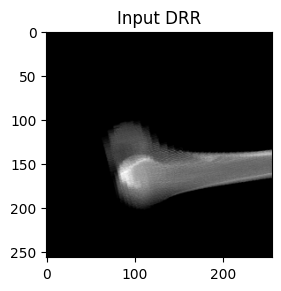

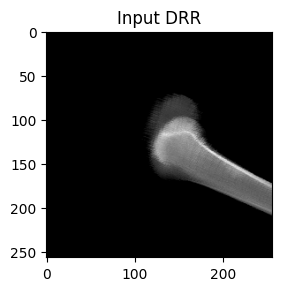

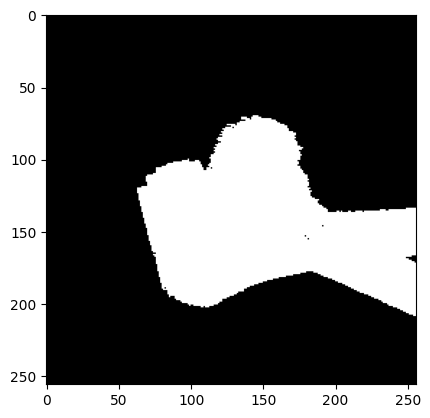

In [51]:
evaluate_metric(10, "femur", device)

In [57]:
def evaluate_train(specimen_id, volume_type, model_checkpoint, batch_size, device):
    height = 256
    model_name="resnet18"
    parameterization="se3_log_map"
    convention=None
    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
    }
    transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([972/2, 0,0], dtype=torch.float32, device=device))

    model = PoseRegressor(**model_params)

    if model_checkpoint is not None:
        print("Loading from checkpoint = " + str(model_checkpoint))
        ckpt = torch.load(model_checkpoint)
        model.load_state_dict(ckpt["model_state_dict"])
    model = model.to(device)
    # model.eval()

    

    


    specimen, isocenter_pose, transforms, drr = load(specimen_id, height, device, volume_type=volume_type)

    # print("gt_pose", gt_pose.get_translation())
    # print("gt_pose", gt_pose.get_rotation("euler_angles","XYZ"))
    contrast_distribution = torch.distributions.Uniform(1.0, 10.0)
    contrast = 2.0

    # drr_pixels = torch.zeros(batch_size)
    # ctr = 0

    # map = drr_pixels > 4000

    # while not all(i > 4000 for i in drr_pixels):
    offset = gen_random_offset(batch_size, device, volume_type)
    #     # print("Iso_Rot ", isocenter_pose.get_rotation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
    #     ctr+=1
        # generate artificial xray image (DRR) given a random pose 
    pose = transito.compose(offset.compose(isocenter_pose))


    # pose = isocenter_pose
    img = drr(None, None, None, pose=pose, bone_attenuation_multiplier=contrast)
    img = transforms(img)
    img = img.float()
    img = (img> 0).float()
    # print("img_size", img.squeeze().size())
    # drr_pixels = torch.sum(torch.sum(img.squeeze().cpu()>0, 1),1)
    # print(drr_pixels)
    # print("drr_pixels", drr_pixels)

    # print("img_drr", torch.sum(torch.sum(img.squeeze().cpu()>0, 1),1))
    # plt = plot_grad_flow(model.named_parameters())
    # plt.show()
    
    vis_drr(drr, pose, transforms=transforms, device=device)

    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("Input DRR")
    # drr_xray = pred_xray[0,:,:,:]
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")

    pred_offset = model(img)
    pred_pose = transito.compose(pred_offset.compose(isocenter_pose))

    # print("Iso_trans", isocenter_pose.get_translation())
    # print("Iso_rot", isocenter_pose.get_rotation("euler_angles","XYZ"))
    # print("Offset_trans", offset.get_translation())
    # print("Offset_rot", offset.get_rotation("euler_angles","XYZ"))

    # print("GT_trans", pose.get_translation())
    # print("GT_rot", pose.get_rotation("euler_angles","XYZ"))
    # print("----------------------------------------")
    # print("Pred_offset_trans", pred_offset.get_translation())
    # print("Pred_offset_rot", pred_offset.get_rotation("euler_angles","XYZ"))

    # print("Pred_trans", pred_pose.get_translation())
    # print("Pred_rot", pred_pose.get_rotation("euler_angles","XYZ"))

    vis_drr(drr, pred_pose, transforms=transforms, device=device, title="Train Pred Pose")
# 
# return ctr
    

In [ ]:
# ckpt = r"checkpoints\specimen_01_femur_epoch500.ckpt"
ckpt = r"checkpoints\specimen_10_femur_best.ckpt"
ckpt = r"checkpoints\save\\2657_specimen_10_femur_epoch200.ckpt"
ckpt = r"checkpoints\\3337_specimen_10_femur_epoch150.ckpt"
ckpt = r"checkpoints\\4037_specimen_10_femur_epoch100.ckpt"
ckpt = r"checkpoints\\1206_specimen_10_femur_epoch500.ckpt"

device = torch.device("cuda")

op = evaluate_train(10, volume_type= "femur", model_checkpoint=ckpt, batch_size=1, device=device)
# ctr_list.append(op) 
# ctr_list

In [ ]:
import statistics
statistics.mean(ctr_list)

In [147]:
# T1 = RigidTransform(torch.tensor([1,1,1], dtype=torch.float32), torch.tensor([1,2,3], dtype=torch.float32),device=device, parameterization="euler_angles", convention="XYZ")
# T2 = RigidTransform(torch.tensor([0,0,0], dtype=torch.float32), torch.tensor([100,1,1], dtype=torch.float32),device=device,  parameterization="euler_angles", convention="XYZ")
# T3 = T2.compose(T1)
# T4 = T1.compose(T2)
# print("comp_trans", T1.get_translation())
# print("comp_rot", T1.get_rotation("euler_angles","XYZ"))
# print("comp_trans", T2.get_translation())
# print("comp_rot", T2.get_rotation("euler_angles","XYZ"))
# print("comp_trans", T3.get_translation())
# print("comp_rot", T3.get_rotation("euler_angles","XYZ"))
# print("comp_trans", T4.get_translation())
# print("comp_rot", T4.get_rotation("euler_angles","XYZ"))

In [ ]:
# device = torch.device("cuda")

# ckpt = r"checkpoints\specimen_10_femur_best.ckpt"
# evaluate(10, 1, "femur", ckpt ,device)

In [29]:
# device = torch.device("cuda")

# ckpt2 = r"checkpoints\save\specimen_01_tibia_epoch350.ckpt"

# evaluate(1, 1, "tibia", ckpt2 ,device)

In [ ]:
# ckpt2 = r"checkpoints\save\specimen_01_tibia_epoch350.ckpt"
# evaluate_train(1, volume_type= "tibia", model_checkpoint=ckpt2, batch_size=1, device=device)


In [ ]:
# def val_synthetic_train(
#     run_id,
#     id_number,
#     model,
#     optimizer,
#     scheduler,
#     drr,
#     transforms,
#     specimen,
#     isocenter_pose,
#     device,
#     batch_size,
#     n_epochs,
#     n_batches_per_epoch,
#     model_params,
#     volume_type,
#     binary_imgs
# ):
#     # initialize losses
#     print("ISO = ", isocenter_pose.get_translation(), isocenter_pose.get_rotation("euler_angles", "XYZ"))
#     metric = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[16, 64], patch_weights=[0.75, 0.25], eps=1e-4)
#     # geodesic = GeodesicSE3(geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
#     # double = DoubleGeodesic(drr.detector.sdr, geo_weights=torch.tensor([1/2.1, 1/1.5, 1/0.5], dtype=torch.float))
#     double = DoubleGeodesic(drr.detector.sdr)
#     geodesic = GeodesicSE3()

#     # contrast_distribution = torch.distributions.Uniform(1.0, 10.0)
#     # pixel_threshold = 4000
#     transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([972/2, 0,0], dtype=torch.float32, device=device))
#     best_loss = torch.inf
#     # pixel_check = False
#     model = model.to(device)
#     model.train()
#     #  visualization part
#     # generate random R and t for CT volume
#     print("Debug", batch_size, device)


#     print(f"Training on {len(train_indices)} xrays, Testing on {len(val_indices)}")
    
#     random.shuffle(train_indices)
#     true_xray_tensor_batch, gt_pose_batch_femur, gt_pose_batch_tibia = process_specimens(specimen, isocenter_pose, val_indices, 4)

#     # ctr_break_ctr = 0

#     for epoch in range(n_epochs + 1):
#         # print("CTR Break triggered = ", ctr_break_ctr)
#         losses_ep = []
#         geodesic_ep = []
#         ncc_ep = []
#         double_geo_ep = []
#         geo_xyz_ep = []
#         geo_rot_ep = []
#         val_loss_ep = []


#         for _ in (itr := tqdm(range(n_batches_per_epoch), leave=False)):
#             # bone_attenuation is chosen randomly from a uniform distribution
#             contrast = 2.0
#             # generate random pose using normal distribution
#             new_offsets = gen_random_offset(batch_size, device)
#             poses = transito.compose(new_offsets.compose(isocenter_pose))

#             # generate artificial xray image (DRR) given a random pose 
#             imgs = drr(None, None, None, pose=poses, bone_attenuation_multiplier=contrast)
#             imgs = transforms(imgs)
#             imgs = imgs.float()
#             ip = imgs
#             if binary_imgs:
#                 actual_binary_images = (imgs> 0).float().cuda()
#                 ip = actual_binary_images
#             # apply predicted pose and generate predicted DRR
#             pred_offset = model(ip)
#             pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
#             pred_img = drr(None, None, None, pose=pred_pose)
#             pred_img = transforms(pred_img)
#             pred_img = pred_img.float()

#             # compute image reconstruction and numerical losses
#             ncc = metric(pred_img, ip)
#             log_geodesic = geodesic(pred_pose, poses)
#             geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, poses)
#             geodesic_weight = 1e-3

#             # Normalize NCC values to [0, 1]
#             # normalized_ncc = (ncc + 1) / 2

#             # print('normalized_ncc', normalized_ncc)
#             # print(double_geodesic.max())

#             # Compute weights as the inverse of the normalized loss
#             # weight_ncc = 1.0 / (normalized_ncc.mean())  # Add epsilon to avoid division by zero
#             # weight_geodesic = 1.0 / (geodesic_weight*(double_geodesic.max() + log_geodesic.max()))  # Add epsilon to avoid division by zero

#             # print('before normalization')
#             # print("weight_ncc", weight_ncc)
#             # print("weight_geodesic", weight_geodesic)

#             # Normalize weights to ensure they sum to 1
#             # total_weight = weight_ncc + weight_geodesic
#             # weight_ncc /= total_weight
#             # weight_geodesic /= total_weight

#             # print('after normalization')
#             # print("weight_ncc", weight_ncc)
#             # print("weight_geodesic", weight_geodesic)

#             # Calculate the final weighted loss
#             loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (1 - ncc)
#             # loss = 1 - ncc + geodesic_weight*double_geodesic
#             # loss = (1 - ncc) + geodesic_weight * (0.6*geodesic_rot + 0.4*geodesic_xyz)

            
#             if loss.isnan().any():
#                 print("Aaaaaaand we've crashed...")
#                 # print(ncc)
#                 print(geodesic_rot)
#                 print(geodesic_xyz)
#                 print(geodesic_ep)
#                 print(double_geodesic)
#                 print(poses.get_matrix())
#                 print(pred_pose.get_matrix())
#                 torch.save(
#                     {
#                         "model_state_dict": model.state_dict(),
#                         "optimizer_state_dict": optimizer.state_dict(),
#                         "height": drr.detector.height,
#                         "epoch": epoch,
#                         "batch_size": batch_size,
#                         "n_epochs": n_epochs,
#                         "n_batches_per_epoch": n_batches_per_epoch,
#                         "pose": poses.get_matrix().cpu(),
#                         "pred_pose": pred_pose.get_matrix().cpu(),
#                         "img": imgs.cpu(),
#                         # "pred_img": pred_img.cpu()
#                         **model_params,
#                     },
#                     f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_crashed.ckpt",
#                 )
#                 raise RuntimeError("NaN loss")

#             optimizer.zero_grad()
#             loss.mean().backward()
#             adaptive_clip_grad_(model.parameters())
#             optimizer.step()
#             scheduler.step()

#             ncc_ep.append(ncc.mean().item())
#             geodesic_ep.append(log_geodesic.mean().item())
#             double_geo_ep.append(double_geodesic.mean().item())
#             geo_xyz_ep.append(geodesic_xyz.mean().item())
#             geo_rot_ep.append(geodesic_rot.mean().item())
#             losses_ep.append(loss.mean().item())

#             # Update progress bar
#             itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
#             itr.set_postfix(
#                 geodesic_rot=geodesic_rot.mean().item(),
#                 geodesic_xyz=geodesic_xyz.mean().item(),
#                 geodesic_dou=double_geodesic.mean().item(),
#                 loss=loss.mean().item(),
#                 ncc=ncc.mean().item(),
#             )

    
#             # prev_pose = poses
#             # prev_pred_pose = pred_pose

#             log_memory_usage(int(epoch*batch_size + _))
        
        
#         # WANDB
#         # print(model)
#         # plt = plot_grad_flow(model.named_parameters())
#         # plt.show()
#         pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
#         ip_img_log = wandb.Image(ip[0].detach().cpu().numpy())
#         wandb.log({"pred_img": wandb.Image(pred_img_log),
#                     "ip_img" : wandb.Image(ip_img_log),
#                     # "gradient_chart": plt,
#                     })
#         wandb.log({"epoch": epoch,
#                    "ncc": statistics.mean(ncc_ep),
#                    "log_geodesic": statistics.mean(geodesic_ep),
#                    "final_loss":statistics.mean(losses_ep),
#                    "geodesic_rot":statistics.mean(geo_rot_ep),
#                    "geodesic_xyz":statistics.mean(geo_xyz_ep),
#                    "double_geodesic":statistics.mean(double_geo_ep)})
        


#         losses = torch.tensor(losses_ep)
#         tqdm.write(f"Epoch {epoch + 1:04d} | Loss {losses.mean().item():.4f}")

#         ### validation section
#         # print(len(gt_pose_batch_femur))
#         # print(len(true_xray_tensor_batch))
#         if epoch % 50 == 0:
#             for itr, (true_xray, gt_pose_femur) in enumerate(tqdm(zip(true_xray_tensor_batch, gt_pose_batch_femur), total=len(true_xray_tensor_batch), leave=False)):

#                 # print(true_xray, gt_pose_femur, gt_pose_tibia)
#                 true_xray = true_xray.to(device)
#                 gt_pose_femur = gt_pose_femur.to(device)

#                 # print(true_xray.shape)

#                 with torch.no_grad():
#                     output = segnet(true_xray)['out'][0]
#                 output_predictions = output.argmax(0)

#                 # print(output_predictions.shape)

#                 mask_num = 1 if volume_type == "femur" else 0

#                 seg_img = get_masked_img(true_xray, output_predictions, mask_num, device)

#                 # print(seg_img)

#                 pred_offset = model(seg_img)

#                 pred_pose = transito.compose(pred_offset.compose(isocenter_pose))
#                 pred_img = drr(None, None, None, pose=pred_pose)
#                 pred_img = transforms(pred_img)
#                 pred_img = pred_img.float()

#                 # compute image reconstruction and numerical losses
#                 ncc = metric(pred_img, seg_img)
#                 log_geodesic = geodesic(pred_pose, gt_pose_femur)
#                 geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, gt_pose_femur)
#                 geodesic_weight = 1e-3
#                 val_loss = ( geodesic_weight * (log_geodesic + double_geodesic)) + (1 - ncc)

#                 val_loss_ep.append(val_loss.mean().item())

#                 # # Update progress bar
#                 # itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
#                 # itr.set_postfix(
#                 #     val_loss=val_loss.mean().item()
#                 # )
            
#             pred_img_log = wandb.Image(pred_img[0].detach().cpu().numpy())
#             ip_img_log = wandb.Image(seg_img[0].detach().cpu().numpy())
#             wandb.log({"pred_gt_img": wandb.Image(pred_img_log),
#                         "seg_img" : wandb.Image(ip_img_log),
#                         # "gradient_chart": plt,
#                         })
#             wandb.log({"val_loss": statistics.mean(val_loss_ep)})

#             val_losses = torch.tensor(val_loss_ep)
#             tqdm.write(f"Epoch {epoch + 1:04d} | Loss {val_losses.mean().item():.4f}")





#         # if losses.mean() < best_loss and not losses.isnan().any():
#         #     best_loss = losses.mean().item()
#         #     torch.save(
#         #         {
#         #             "model_state_dict": model.state_dict(),
#         #             "optimizer_state_dict": optimizer.state_dict(),
#         #             "height": drr.detector.height,
#         #             "epoch": epoch,
#         #             "loss": losses.mean().item(),
#         #             "batch_size": batch_size,
#         #             "n_epochs": n_epochs,
#         #             "n_batches_per_epoch": n_batches_per_epoch,
#         #             **model_params,
#         #         },
#         #         f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_best.ckpt",
#         #     )

#         if epoch % 50 == 0:
#             torch.save(
#                 {
#                     "model_state_dict": model.state_dict(),
#                     "optimizer_state_dict": optimizer.state_dict(),
#                     "height": drr.detector.height,
#                     "epoch": epoch,
#                     "loss": losses.mean().item(),
#                     "batch_size": batch_size,
#                     "n_epochs": n_epochs,
#                     "n_batches_per_epoch": n_batches_per_epoch,
#                     **model_params,
#                 },
#                 f"checkpoints/{run_id}_specimen_{id_number:02d}_{volume_type}_epoch{epoch:03d}.ckpt",
#             )

#         torch.cuda.empty_cache()
#         gc.collect()